In [1]:
!pip install -U https://github.com/sberbank-ai-lab/LightAutoML/raw/fix/logging/LightAutoML-0.2.16.2-py3-none-any.whl
!pip install openpyxl

  Using cached https://github.com/sberbank-ai-lab/LightAutoML/raw/fix/logging/LightAutoML-0.2.16.2-py3-none-any.whl (263 kB)


# Step 0.1. Import libraries

Here we will import the libraries we use in this kernel:
- Standard python libraries for timing, working with OS etc.
- Essential python DS libraries like numpy, pandas, scikit-learn and torch (the last we will use in the next cell)
- LightAutoML modules: presets for AutoML, task and report generation module

In [2]:
# Standard python libraries
import os
import time

# Essential DS libraries
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_log_error
import matplotlib.pyplot as plt
import torch

# LightAutoML presets, task and report generation
from lightautoml.automl.presets.tabular_presets import TabularAutoML, TabularUtilizedAutoML
from lightautoml.tasks import Task
from lightautoml.dataset.roles import DatetimeRole
from lightautoml.report.report_deco import ReportDeco

# Step 0.2. Constants

Here we setup the constants to use in the kernel:
- `N_THREADS` - number of vCPUs for LightAutoML model creation
- `N_FOLDS` - number of folds in LightAutoML inner CV
- `RANDOM_STATE` - random seed for better reproducibility
- `TIMEOUT` - limit in seconds for model to train
- `TARGET_NAME` - target column name in dataset

In [3]:
N_THREADS = 4
N_FOLDS = 5
RANDOM_STATE = 42
TIMEOUT = 2 * 3600
TARGET_NAME = 'target'

# Step 0.3. Imported models setup

For better reproducibility we fix numpy random seed with max number of threads for Torch (which usually try to use all the threads on server):

In [4]:
np.random.seed(RANDOM_STATE)
torch.set_num_threads(N_THREADS)

# Step 0.4. Data loading
Let's check the data we have:

# Dataset Description
In this competition you are predicting the values of air pollution measurements over time, based on basic weather information (temperature and humidity) and the input values of 5 sensors.

The three target values to you to predict are: target_carbon_monoxide, target_benzene, and target_nitrogen_oxides

# Files
train.csv - the training data, including the weather data, sensor data, and values for the 3 targets
test.csv - the same format as train.csv, but without the target value; your task is to predict the value for each of these targets.
sample_submission.csv - a sample submission file in the correct format.

In [5]:
%%time

train_data = pd.read_csv('../input/tabular-playground-series-jul-2021/train.csv')
train_data.head()

CPU times: user 19 ms, sys: 1.11 ms, total: 20.1 ms
Wall time: 22.5 ms


,date_time,deg_C,relative_humidity,absolute_humidity,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,target_carbon_monoxide,target_benzene,target_nitrogen_oxides
0,2010-03-10 18:00:00,13.1,46.0,0.7578,1387.2,1087.8,1056.0,1742.8,1293.4,2.5,12.0,167.7
1,2010-03-10 19:00:00,13.2,45.3,0.7255,1279.1,888.2,1197.5,1449.9,1010.9,2.1,9.9,98.9
2,2010-03-10 20:00:00,12.6,56.2,0.7502,1331.9,929.6,1060.2,1586.1,1117.0,2.2,9.2,127.1
3,2010-03-10 21:00:00,11.0,62.4,0.7867,1321.0,929.0,1102.9,1536.5,1263.2,2.2,9.7,177.2
4,2010-03-10 22:00:00,11.9,59.0,0.7888,1272.0,852.7,1180.9,1415.5,1132.2,1.5,6.4,121.8


In [6]:
train_data.shape

(7111, 12)

In [7]:
%%time

test_data = pd.read_csv('../input/tabular-playground-series-jul-2021/test.csv')
test_data.head()

CPU times: user 6.14 ms, sys: 1.14 ms, total: 7.27 ms
Wall time: 8.87 ms


,date_time,deg_C,relative_humidity,absolute_humidity,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5
0,2011-01-01 00:00:00,8.0,41.3,0.4375,1108.8,745.7,797.1,880.0,1273.1
1,2011-01-01 01:00:00,5.1,51.7,0.4564,1249.5,864.9,687.9,972.8,1714.0
2,2011-01-01 02:00:00,5.8,51.5,0.4689,1102.6,878.0,693.7,941.9,1300.8
3,2011-01-01 03:00:00,5.0,52.3,0.4693,1139.7,916.2,725.6,1011.0,1283.0
4,2011-01-01 04:00:00,4.5,57.5,0.4650,1022.4,838.5,871.5,967.0,1142.3


In [8]:
test_data.shape

(2247, 9)

In [9]:
%%time

sample_sub = pd.read_csv('../input/tabular-playground-series-jul-2021/sample_submission.csv')
sample_sub.head()

CPU times: user 6.43 ms, sys: 933 µs, total: 7.36 ms
Wall time: 7.5 ms


,date_time,target_carbon_monoxide,target_benzene,target_nitrogen_oxides
0,2011-01-01 00:00:00,2.0,10.0,300.0
1,2011-01-01 01:00:00,2.0,10.0,300.0
2,2011-01-01 02:00:00,2.0,10.0,300.0
3,2011-01-01 03:00:00,2.0,10.0,300.0
4,2011-01-01 04:00:00,2.0,10.0,300.0


In [10]:
sample_sub.shape

(2247, 4)

## Don't know what to do with -200? Use pseudolabelling 🧐

In [11]:
# Pseudolabels from true dataset 
pseudolabels_true = pd.read_excel('/kaggle/input/air-quality-time-series-data-uci/AirQualityUCI.xlsx')
pseudolabels_true = pseudolabels_true.iloc[7110:].reset_index(drop = True)
pseudolabels_true.rename({'CO(GT)': 'target_carbon_monoxide', 'C6H6(GT)': 'target_benzene', 'NOx(GT)': 'target_nitrogen_oxides'}, axis = 1, inplace = True)
pseudolabels_true

,Date,Time,target_carbon_monoxide,PT08.S1(CO),NMHC(GT),target_benzene,PT08.S2(NMHC),target_nitrogen_oxides,PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Unnamed: 15,Unnamed: 16
0,2005-01-01,00:00:00,-200.0,1046.25,-200,4.247511,724.25,-200.0,848.00,-200.0,897.75,1201.25,8.200,40.099999,0.437451,NaN,NaN
1,2005-01-01,01:00:00,1.6,1274.50,-200,8.763027,930.00,214.9,648.50,106.3,1023.50,1617.00,5.325,50.725000,0.456368,NaN,NaN
2,2005-01-01,02:00:00,2.5,1172.75,-200,7.498693,878.25,299.8,738.00,128.6,1002.00,1355.25,5.925,50.049999,0.468928,NaN,NaN
3,2005-01-01,03:00:00,2.7,1162.50,-200,7.563761,881.00,-200.0,748.25,-200.0,1001.25,1295.50,4.850,53.875000,0.469339,NaN,NaN
4,2005-01-01,04:00:00,1.9,1054.00,-200,5.560496,791.00,253.1,829.50,126.0,966.50,1131.00,4.325,55.325000,0.465048,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2242,2005-04-04,10:00:00,3.1,1314.25,-200,13.529605,1101.25,471.7,538.50,189.8,1374.25,1728.50,21.850,29.250000,0.756824,NaN,NaN
2243,2005-04-04,11:00:00,2.4,1162.50,-200,11.355157,1027.00,353.3,603.75,179.2,1263.50,1269.00,24.325,23.725000,0.711864,NaN,NaN
2244,2005-04-04,12:00:00,2.4,1142.00,-200,12.374538,1062.50,293.0,603.25,174.7,1240.75,1092.00,26.900,18.350000,0.640649,NaN,NaN
2245,2005-04-04,13:00:00,2.1,1002.50,-200,9.547187,960.50,234.5,701.50,155.7,1041.00,769.75,28.325,13.550000,0.513866,NaN,NaN


In [12]:
pseudolabels_preds = pd.read_csv('../input/tps-lightautoml-baseline-with-pseudolabels/lightautoml_with_pseudolabelling_kernel_version_14.csv')
pseudolabels_preds

,date_time,target_carbon_monoxide,target_benzene,target_nitrogen_oxides
0,2011-01-01 00:00:00,1.701733,4.247511,242.543976
1,2011-01-01 01:00:00,1.600000,8.763027,214.900000
2,2011-01-01 02:00:00,2.500000,7.498693,299.800000
3,2011-01-01 03:00:00,2.700000,7.563761,319.493164
4,2011-01-01 04:00:00,1.900000,5.560496,253.100000
...,...,...,...,...
2242,2011-04-04 10:00:00,3.100000,13.529605,471.700000
2243,2011-04-04 11:00:00,2.400000,11.355157,353.300000
2244,2011-04-04 12:00:00,2.400000,12.374538,293.000000
2245,2011-04-04 13:00:00,2.100000,9.547187,234.500000


In [13]:
test_data['target_carbon_monoxide'] = np.where(pseudolabels_true['target_carbon_monoxide'].values >= 0, 
                                               pseudolabels_true['target_carbon_monoxide'].values, 
                                               pseudolabels_preds['target_carbon_monoxide'].values)
test_data['target_benzene'] = np.where(pseudolabels_true['target_benzene'].values >= 0, 
                                       pseudolabels_true['target_benzene'].values, 
                                       pseudolabels_preds['target_benzene'].values)
test_data['target_nitrogen_oxides'] = np.where(pseudolabels_true['target_nitrogen_oxides'].values >= 0, 
                                       pseudolabels_true['target_nitrogen_oxides'].values, 
                                       pseudolabels_preds['target_nitrogen_oxides'].values)
    
test_data

,date_time,deg_C,relative_humidity,absolute_humidity,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,target_carbon_monoxide,target_benzene,target_nitrogen_oxides
0,2011-01-01 00:00:00,8.0,41.3,0.4375,1108.8,745.7,797.1,880.0,1273.1,1.701733,4.247511,242.543976
1,2011-01-01 01:00:00,5.1,51.7,0.4564,1249.5,864.9,687.9,972.8,1714.0,1.600000,8.763027,214.900000
2,2011-01-01 02:00:00,5.8,51.5,0.4689,1102.6,878.0,693.7,941.9,1300.8,2.500000,7.498693,299.800000
3,2011-01-01 03:00:00,5.0,52.3,0.4693,1139.7,916.2,725.6,1011.0,1283.0,2.700000,7.563761,319.493164
4,2011-01-01 04:00:00,4.5,57.5,0.4650,1022.4,838.5,871.5,967.0,1142.3,1.900000,5.560496,253.100000
...,...,...,...,...,...,...,...,...,...,...,...,...
2242,2011-04-04 10:00:00,23.2,28.7,0.7568,1340.3,1023.9,522.8,1374.0,1659.8,3.100000,13.529605,471.700000
2243,2011-04-04 11:00:00,24.5,22.5,0.7119,1232.8,955.1,616.1,1226.1,1269.0,2.400000,11.355157,353.300000
2244,2011-04-04 12:00:00,26.6,19.0,0.6406,1187.7,1052.4,572.8,1253.4,1081.1,2.400000,12.374538,293.000000
2245,2011-04-04 13:00:00,29.1,12.7,0.5139,1053.2,1009.0,702.0,1009.8,808.5,2.100000,9.547187,234.500000


In [14]:
test_data['target_carbon_monoxide'].value_counts()

1.000000    104
1.400000     98
1.100000     96
1.500000     84
1.600000     82
           ... 
0.561886      1
0.772987      1
0.503274      1
0.465906      1
8.700000      1
Name: target_carbon_monoxide, Length: 174, dtype: int64

In [15]:
test_data['target_benzene'].value_counts()

5.151339     6
5.277768     5
7.928930     5
2.477658     4
7.258284     4
            ..
4.897490     1
17.440323    1
8.731502     1
0.111158     1
6.941043     1
Name: target_benzene, Length: 1756, dtype: int64

In [16]:
test_data['target_nitrogen_oxides'].value_counts()

156.1    4
253.7    3
95.3     3
131.9    3
122.0    3
        ..
185.9    1
302.7    1
100.4    1
566.7    1
166.7    1
Name: target_nitrogen_oxides, Length: 1892, dtype: int64

In [17]:
ALL_DF = pd.concat([train_data, test_data]).reset_index(drop = True)
print(ALL_DF.shape)

(9358, 12)


In [18]:
# Feature engineering func from Remek Kinas kernel with MLJAR (https://www.kaggle.com/remekkinas/mljar-code-minimal) - do not forget to upvote his kernel
    
import math

def pb_add(X):
    X['day'] = X.date_time.dt.weekday
    is_odd = (X['sensor_4'] < 646) & (X['absolute_humidity'] < 0.238)
    X['is_odd'] = is_odd
    diff = X['date_time'] - min(X['date_time'])
    trend = diff.dt.days
    X['f1s'] = np.sin(trend * 2 * math.pi / (365 * 1)) 
    X['f1c'] = np.cos(trend * 2 * math.pi / (365 * 1))
    X['f2s'] = np.sin(2 * math.pi * trend / (365 * 2)) 
    X['f2c'] = np.cos(2 * math.pi * trend / (365 * 2)) 
    X['f3s'] = np.sin(2 * math.pi * trend / (365 * 3)) 
    X['f3c'] = np.cos(2 * math.pi * trend / (365 * 3)) 
    X['f4s'] = np.sin(2 * math.pi * trend / (365 * 4)) 
    X['f4c'] = np.cos(2 * math.pi * trend / (365 * 4)) 
    X['fh1s'] = np.sin(diff.dt.seconds * 2 * math.pi / ( 3600 * 24 * 1))
    X['fh1c'] = np.cos(diff.dt.seconds * 2 * math.pi / ( 3600 * 24 * 1))
    X['fh2s'] = np.sin(diff.dt.seconds * 2 * math.pi / ( 3600 * 24 * 2))
    X['fh2c'] = np.cos(diff.dt.seconds * 2 * math.pi / ( 3600 * 24 * 2))
    X['fh3s'] = np.sin(diff.dt.seconds * 2 * math.pi / ( 3600 * 24 * 3))
    X['fh3c'] = np.cos(diff.dt.seconds * 2 * math.pi / ( 3600 * 24 * 3))
    
    sensor_features = [
        'deg_C', 
        'relative_humidity', 'absolute_humidity', 
        'sensor_1', 'sensor_2', 'sensor_3', 'sensor_4', 'sensor_5' ]
    
    lags = [-1, -4, -24, -7 * 24]  
    for sensor_feature in sensor_features:
        this = X[sensor_feature]

        for lag in lags:
            feature = f'{sensor_feature}_{abs(lag)}b'
            this_f = X[sensor_feature].shift(lag)
            X[feature] = (this_f - this).fillna(0)
        # look forwards
        for lag in lags:
            feature = f'{sensor_feature}_{abs(-lag)}f'
            this_f = X[sensor_feature].shift(-lag)
            X[feature] = (this_f - this).fillna(0)
            
    return X

ALL_DF['date_time'] = pd.to_datetime(ALL_DF['date_time'])
ALL_DF["hour"] = ALL_DF["date_time"].dt.hour
ALL_DF["working_hours"] =  ALL_DF["hour"].isin(np.arange(8, 21, 1)).astype("int")
ALL_DF["is_weekend"] = (ALL_DF["date_time"].dt.dayofweek >= 5).astype("int")
ALL_DF['hr'] = ALL_DF.date_time.dt.hour * 60 + ALL_DF.date_time.dt.minute
ALL_DF['satday'] = (ALL_DF.date_time.dt.weekday==5).astype("int")
ALL_DF["SMC"] = (ALL_DF["absolute_humidity"] * 100) / ALL_DF["relative_humidity"]
ALL_DF.drop(columns = 'hour', inplace = True)

pb_add(ALL_DF)

ALL_DF['date_time'] = ALL_DF['date_time'].astype(str)

## Important - cell below works only because of the data leak. In real life you can't create features using the future data. Be careful!

In [19]:
def create_target_feats(df):
    for lag in [1, 4, 24, 7 * 24]:
        for t in ['target_carbon_monoxide', 'target_benzene', 'target_nitrogen_oxides']:
            df['{}_lag_{}'.format(t, lag)] = df[t].shift(lag)
            df['{}_lag_m{}'.format(t, lag)] = df[t].shift(-lag)
            df['diff_{}_{}'.format(t, lag)] = df['{}_lag_m{}'.format(t, lag)] - df['{}_lag_{}'.format(t, lag)]
            df['div_{}_{}'.format(t, lag)] = df['{}_lag_m{}'.format(t, lag)] / df['{}_lag_{}'.format(t, lag)]
create_target_feats(ALL_DF)

In [20]:
ALL_DF

,date_time,deg_C,relative_humidity,absolute_humidity,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,target_carbon_monoxide,...,diff_target_carbon_monoxide_168,div_target_carbon_monoxide_168,target_benzene_lag_168,target_benzene_lag_m168,diff_target_benzene_168,div_target_benzene_168,target_nitrogen_oxides_lag_168,target_nitrogen_oxides_lag_m168,diff_target_nitrogen_oxides_168,div_target_nitrogen_oxides_168
0,2010-03-10 18:00:00,13.1,46.0,0.7578,1387.2,1087.8,1056.0,1742.8,1293.4,2.5,...,NaN,NaN,NaN,25.9,NaN,NaN,NaN,296.0,NaN,NaN
1,2010-03-10 19:00:00,13.2,45.3,0.7255,1279.1,888.2,1197.5,1449.9,1010.9,2.1,...,NaN,NaN,NaN,39.6,NaN,NaN,NaN,411.0,NaN,NaN
2,2010-03-10 20:00:00,12.6,56.2,0.7502,1331.9,929.6,1060.2,1586.1,1117.0,2.2,...,NaN,NaN,NaN,36.9,NaN,NaN,NaN,357.4,NaN,NaN
3,2010-03-10 21:00:00,11.0,62.4,0.7867,1321.0,929.0,1102.9,1536.5,1263.2,2.2,...,NaN,NaN,NaN,25.8,NaN,NaN,NaN,356.2,NaN,NaN
4,2010-03-10 22:00:00,11.9,59.0,0.7888,1272.0,852.7,1180.9,1415.5,1132.2,1.5,...,NaN,NaN,NaN,14.4,NaN,NaN,NaN,187.9,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9353,2011-04-04 10:00:00,23.2,28.7,0.7568,1340.3,1023.9,522.8,1374.0,1659.8,3.1,...,NaN,NaN,5.191654,NaN,NaN,NaN,216.0,NaN,NaN,NaN
9354,2011-04-04 11:00:00,24.5,22.5,0.7119,1232.8,955.1,616.1,1226.1,1269.0,2.4,...,NaN,NaN,5.493102,NaN,NaN,NaN,219.8,NaN,NaN,NaN
9355,2011-04-04 12:00:00,26.6,19.0,0.6406,1187.7,1052.4,572.8,1253.4,1081.1,2.4,...,NaN,NaN,4.187455,NaN,NaN,NaN,182.6,NaN,NaN,NaN
9356,2011-04-04 13:00:00,29.1,12.7,0.5139,1053.2,1009.0,702.0,1009.8,808.5,2.1,...,NaN,NaN,3.297505,NaN,NaN,NaN,153.7,NaN,NaN,NaN


In [21]:
train_data, test_data = ALL_DF.iloc[:(len(ALL_DF) - len(test_data)), :], ALL_DF.iloc[(len(ALL_DF) - len(test_data)):, :]
print(train_data.shape, test_data.shape)

(7111, 145) (2247, 145)


In [22]:
train_data.head()

,date_time,deg_C,relative_humidity,absolute_humidity,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,target_carbon_monoxide,...,diff_target_carbon_monoxide_168,div_target_carbon_monoxide_168,target_benzene_lag_168,target_benzene_lag_m168,diff_target_benzene_168,div_target_benzene_168,target_nitrogen_oxides_lag_168,target_nitrogen_oxides_lag_m168,diff_target_nitrogen_oxides_168,div_target_nitrogen_oxides_168
0,2010-03-10 18:00:00,13.1,46.0,0.7578,1387.2,1087.8,1056.0,1742.8,1293.4,2.5,...,NaN,NaN,NaN,25.9,NaN,NaN,NaN,296.0,NaN,NaN
1,2010-03-10 19:00:00,13.2,45.3,0.7255,1279.1,888.2,1197.5,1449.9,1010.9,2.1,...,NaN,NaN,NaN,39.6,NaN,NaN,NaN,411.0,NaN,NaN
2,2010-03-10 20:00:00,12.6,56.2,0.7502,1331.9,929.6,1060.2,1586.1,1117.0,2.2,...,NaN,NaN,NaN,36.9,NaN,NaN,NaN,357.4,NaN,NaN
3,2010-03-10 21:00:00,11.0,62.4,0.7867,1321.0,929.0,1102.9,1536.5,1263.2,2.2,...,NaN,NaN,NaN,25.8,NaN,NaN,NaN,356.2,NaN,NaN
4,2010-03-10 22:00:00,11.9,59.0,0.7888,1272.0,852.7,1180.9,1415.5,1132.2,1.5,...,NaN,NaN,NaN,14.4,NaN,NaN,NaN,187.9,NaN,NaN


In [23]:
test_data.head()

,date_time,deg_C,relative_humidity,absolute_humidity,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,target_carbon_monoxide,...,diff_target_carbon_monoxide_168,div_target_carbon_monoxide_168,target_benzene_lag_168,target_benzene_lag_m168,diff_target_benzene_168,div_target_benzene_168,target_nitrogen_oxides_lag_168,target_nitrogen_oxides_lag_m168,diff_target_nitrogen_oxides_168,div_target_nitrogen_oxides_168
7111,2011-01-01 00:00:00,8.0,41.3,0.4375,1108.8,745.7,797.1,880.0,1273.1,1.701733,...,-2.1,0.618182,14.2,13.039875,-1.160125,0.918301,495.4,566.700000,71.300000,1.143924
7112,2011-01-01 01:00:00,5.1,51.7,0.4564,1249.5,864.9,687.9,972.8,1714.0,1.600000,...,-3.3,0.421053,13.1,6.691615,-6.408385,0.510810,487.9,357.400000,-130.500000,0.732527
7113,2011-01-01 02:00:00,5.8,51.5,0.4689,1102.6,878.0,693.7,941.9,1300.8,2.500000,...,-3.5,0.285714,11.1,4.620274,-6.479726,0.416241,506.3,186.600000,-319.700000,0.368556
7114,2011-01-01 03:00:00,5.0,52.3,0.4693,1139.7,916.2,725.6,1011.0,1283.0,2.700000,...,-0.9,0.608696,9.8,3.830373,-5.969627,0.390854,365.7,183.972107,-181.727893,0.503068
7115,2011-01-01 04:00:00,4.5,57.5,0.4650,1022.4,838.5,871.5,967.0,1142.3,1.900000,...,-0.9,0.571429,8.9,3.351769,-5.548231,0.376603,257.6,169.100000,-88.500000,0.656444


# =============== LightAutoML model building ===============


# Step 1. Task setup

On the cell below we create Task object - the class to setup what task LightAutoML model should solve with specific loss and metric if necessary (more info can be found [here](https://lightautoml.readthedocs.io/en/latest/generated/lightautoml.tasks.base.Task.html#lightautoml.tasks.base.Task) in our documentation):

In [24]:
%%time

def rmsle_metric(y_true, y_pred, sample_weight, **kwargs):
    mask = (sample_weight > 1)
    return mean_squared_log_error(y_true[mask], np.clip(y_pred[mask], 0, None), **kwargs) ** 0.5

task = Task('reg', loss = 'rmsle', metric = rmsle_metric, greater_is_better=False)

CPU times: user 154 µs, sys: 13 µs, total: 167 µs
Wall time: 173 µs


# Step 2. Feature roles setup

To solve the task, we need to setup columns roles. The **only role you must setup is target role**, everything else (drop, numeric, categorical, group, weights etc.) is up to user - LightAutoML models have automatic columns typization inside:

In [25]:
?DatetimeRole

Init signature:
DatetimeRole(
    dtype: Union[Callable, type, str] = <class 'numpy.datetime64'>,
    seasonality: Union[Sequence[str], NoneType] = ('y', 'm', 'wd'),
    base_date: bool = False,
    date_format: Union[str, NoneType] = None,
    unit: Union[str, NoneType] = None,
    origin: Union[str, datetime.datetime] = 'unix',
    force_input: bool = False,
    base_feats: bool = True,
    country: Union[str, NoneType] = None,
    prov: Union[str, NoneType] = None,
    state: Union[str, NoneType] = None,
)
Docstring:      Datetime role.
Init docstring:
Create datetime role with specific dtype and attrs.

Args:
    dtype: Variable type.
    seasonality: Seasons to extract from date.
      Valid are: 'y', 'm', 'd', 'wd', 'hour',
      'min', 'sec', 'ms', 'ns'.
    base_date: Base date is used to calculate difference
      with other dates, like `age = report_dt - birth_dt`.
    date_format: Format to parse date.
    unit: The unit of the arg denote the unit, pandas like, see more:
   

### Checking BIZEN idea from comments - no drop for any target, another targets using as features

In [26]:
%%time

targets_and_drop = {
    'target_carbon_monoxide': [],
    'target_benzene': [],
    'target_nitrogen_oxides': []
}

roles = {
    # delete day of month from features
    DatetimeRole(base_date=False, base_feats=True, seasonality=('d', 'wd', 'hour')): 'date_time'
}

CPU times: user 41 µs, sys: 4 µs, total: 45 µs
Wall time: 48.9 µs


# Step 3. LightAutoML model creation - TabularAutoML preset

In next the cell we are going to create LightAutoML model with `TabularAutoML` class - preset with default model structure like in the image below:

<img src="https://github.com/sberbank-ai-lab/lightautoml-datafest-workshop/raw/master/imgs/tutorial_blackbox_pipeline.png" alt="TabularAutoML preset pipeline" style="width:70%;"/>

in just several lines. Let's discuss the params we can setup:
- `task` - the type of the ML task (the only **must have** parameter)
- `timeout` - time limit in seconds for model to train
- `cpu_limit` - vCPU count for model to use
- `reader_params` - parameter change for Reader object inside preset, which works on the first step of data preparation: automatic feature typization, preliminary almost-constant features, correct CV setup etc. For example, we setup `n_jobs` threads for typization algo, `cv` folds and `random_state` as inside CV seed.
- `general_params` - we use `use_algos` key to setup the model structure to work with (two LGBM models and two CatBoost models on the first level and their weighted composition creation on the second). This setup is only to speedup the kernel, you can remove this `general_params` setup if you want the whole LightAutoML model to run.

**Important note**: `reader_params` key is one of the YAML config keys, which is used inside `TabularAutoML` preset. [More details](https://github.com/sberbank-ai-lab/LightAutoML/blob/master/lightautoml/automl/presets/tabular_config.yml) on its structure with explanation comments can be found on the link attached. Each key from this config can be modified with user settings during preset object initialization. To get more info about different parameters setting (for example, ML algos which can be used in `general_params->use_algos`) please take a look at our [article on TowardsDataScience](https://towardsdatascience.com/lightautoml-preset-usage-tutorial-2cce7da6f936). 

In [27]:
%%time 
importances = {}
dt = pd.to_datetime(ALL_DF['date_time'])
for targ in targets_and_drop:
    print('='*50, '='*50, sep = '\n')
    automl = TabularAutoML(task = task, 
                           timeout = TIMEOUT,
                           cpu_limit = N_THREADS,
                           reader_params = {'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE},
                           general_params = {'use_algos': [['lgb', 'lgb_tuned', 'cb', 'cb_tuned']]},
                           verbose = 3 # 0 for no output, 1 - only main steps, 2 - more detailed, 3 - show everything including model scores, optuna iterations etc.
                          )
    
    ALL_DF['weight'] = [1.001] * len(train_data) + list(np.where(pseudolabels_true[targ].values >= 0, 1.001, 0.999))
    roles['weights'] = 'weight'

    roles['target'] = targ
    roles['drop'] = targets_and_drop[targ]

    if targ == 'target_nitrogen_oxides':
        oof_pred = automl.fit_predict(ALL_DF[dt >= np.datetime64('2010-09-01')], roles = roles)
    else:
        oof_pred = automl.fit_predict(ALL_DF, roles = roles)
    print('oof_pred:\n{}\nShape = {}'.format(oof_pred, oof_pred.shape))
    
    # MODEL STRUCTURE - NEW FEATURE
    print('\nFitted model structure:\n{}\n'.format(automl.create_model_str_desc()))
    
    # Fast feature importances calculation
    fast_fi = automl.get_feature_scores('fast')
    importances[targ] = fast_fi
    
    test_pred = automl.predict(test_data)
    print('Prediction for te_data:\n{}\nShape = {}'.format(test_pred, test_pred.shape))
    
    sample_sub[targ] = np.clip(test_pred.data[:, 0], 0, None)

[log_lvl_2] Copying TaskTimer may affect the parent PipelineTimer, so copy will create new unlimited TaskTimer
[log_lvl_1] Start automl preset with listed constraints:
[log_lvl_1] - time: 7200.00 seconds
[log_lvl_1] - cpus: 4 cores
[log_lvl_1] - memory: 16 gb

[log_lvl_1] Train data shape: (9358, 146)

[log_lvl_3] Feats was rejected during automatic roles guess: []
[log_lvl_1] Layer 1 ...

[log_lvl_1] Layer 1 train process start. Time left 7172.48 secs
[log_lvl_1] Start fitting Selector_LightGBM ...
Training until validation scores don't improve for 200 rounds
[100]	valid's l2: 0.0382064	valid's Opt metric: 0.195643
[200]	valid's l2: 0.0137286	valid's Opt metric: 0.117521
[300]	valid's l2: 0.00896854	valid's Opt metric: 0.0949133
[400]	valid's l2: 0.00771646	valid's Opt metric: 0.0879175
[500]	valid's l2: 0.00726126	valid's Opt metric: 0.0851976
[600]	valid's l2: 0.00702387	valid's Opt metric: 0.0837271
[700]	valid's l2: 0.00685829	valid's Opt metric: 0.0826835
[800]	valid's l2: 0.0067

[ 2021-07-22 10:05:36,185] A new study created in memory with name: no-name-4226947c-3c83-4fcb-b918-4aefca74b9a4


Training until validation scores don't improve for 200 rounds
[100]	valid's l2: 0.0339635	valid's Opt metric: 0.184399
[200]	valid's l2: 0.0115473	valid's Opt metric: 0.107637
[300]	valid's l2: 0.00788813	valid's Opt metric: 0.0887802
[400]	valid's l2: 0.00711942	valid's Opt metric: 0.0841726
[500]	valid's l2: 0.00688714	valid's Opt metric: 0.0826934
[600]	valid's l2: 0.00678321	valid's Opt metric: 0.0820142
[700]	valid's l2: 0.00673076	valid's Opt metric: 0.0816669
[800]	valid's l2: 0.00670551	valid's Opt metric: 0.0815029
[900]	valid's l2: 0.00669555	valid's Opt metric: 0.0814372
[1000]	valid's l2: 0.00668889	valid's Opt metric: 0.081388
[1100]	valid's l2: 0.00668414	valid's Opt metric: 0.0813567
[1200]	valid's l2: 0.00667892	valid's Opt metric: 0.08132
[1300]	valid's l2: 0.0066784	valid's Opt metric: 0.0813145
[1400]	valid's l2: 0.00667838	valid's Opt metric: 0.0813123
Early stopping, best iteration is:
[1271]	valid's l2: 0.00667677	valid's Opt metric: 0.0813052


[ 2021-07-22 10:07:21,486] Trial 0 finished with value: -0.08130524272619065 and parameters: {'feature_fraction': 0.6872700594236812, 'num_leaves': 244, 'bagging_fraction': 0.8659969709057025, 'min_sum_hessian_in_leaf': 0.24810409748678125, 'reg_alpha': 2.5361081166471375e-07, 'reg_lambda': 2.5348407664333426e-07}. Best is trial 0 with value: -0.08130524272619065.


Training until validation scores don't improve for 200 rounds
[100]	valid's l2: 0.0383101	valid's Opt metric: 0.195841
[200]	valid's l2: 0.0132529	valid's Opt metric: 0.115446
[300]	valid's l2: 0.00849137	valid's Opt metric: 0.0923609
[400]	valid's l2: 0.0072879	valid's Opt metric: 0.0854388
[500]	valid's l2: 0.00688966	valid's Opt metric: 0.0829606
[600]	valid's l2: 0.00671624	valid's Opt metric: 0.0818434
[700]	valid's l2: 0.00662318	valid's Opt metric: 0.081225
[800]	valid's l2: 0.00657207	valid's Opt metric: 0.0808769
[900]	valid's l2: 0.00654292	valid's Opt metric: 0.0806758
[1000]	valid's l2: 0.00651959	valid's Opt metric: 0.080519
[1100]	valid's l2: 0.00651206	valid's Opt metric: 0.080468
[1200]	valid's l2: 0.00650411	valid's Opt metric: 0.0804082
[1300]	valid's l2: 0.00650124	valid's Opt metric: 0.0803835
[1400]	valid's l2: 0.00649726	valid's Opt metric: 0.080356
[1500]	valid's l2: 0.00649481	valid's Opt metric: 0.0803371
[1600]	valid's l2: 0.00648977	valid's Opt metric: 0.0803

[ 2021-07-22 10:08:44,749] Trial 1 finished with value: -0.08029623259911563 and parameters: {'feature_fraction': 0.5290418060840998, 'num_leaves': 223, 'bagging_fraction': 0.8005575058716043, 'min_sum_hessian_in_leaf': 0.679657809075816, 'reg_alpha': 1.5320059381854043e-08, 'reg_lambda': 5.360294728728285}. Best is trial 1 with value: -0.08029623259911563.


Training until validation scores don't improve for 200 rounds
[100]	valid's l2: 0.0350889	valid's Opt metric: 0.187488
[200]	valid's l2: 0.0120457	valid's Opt metric: 0.110016
[300]	valid's l2: 0.00808471	valid's Opt metric: 0.0899604
[400]	valid's l2: 0.00715328	valid's Opt metric: 0.084435
[500]	valid's l2: 0.00683082	valid's Opt metric: 0.0823789
[600]	valid's l2: 0.00670178	valid's Opt metric: 0.0815172
[700]	valid's l2: 0.00663049	valid's Opt metric: 0.0810346
[800]	valid's l2: 0.00659354	valid's Opt metric: 0.0807835
[900]	valid's l2: 0.00655597	valid's Opt metric: 0.0805243
[1000]	valid's l2: 0.00654262	valid's Opt metric: 0.0804251
[1100]	valid's l2: 0.00652364	valid's Opt metric: 0.0803095
[1200]	valid's l2: 0.00651169	valid's Opt metric: 0.0802234
[1300]	valid's l2: 0.0065057	valid's Opt metric: 0.0801749
[1400]	valid's l2: 0.00649889	valid's Opt metric: 0.0801318
[1500]	valid's l2: 0.00649321	valid's Opt metric: 0.0800881
[1600]	valid's l2: 0.00648752	valid's Opt metric: 0.0

[ 2021-07-22 10:09:58,334] Trial 2 finished with value: -0.07990752259665546 and parameters: {'feature_fraction': 0.9162213204002109, 'num_leaves': 66, 'bagging_fraction': 0.5909124836035503, 'min_sum_hessian_in_leaf': 0.00541524411940254, 'reg_alpha': 5.472429642032198e-06, 'reg_lambda': 0.00052821153945323}. Best is trial 2 with value: -0.07990752259665546.


Training until validation scores don't improve for 200 rounds
[100]	valid's l2: 0.0347185	valid's Opt metric: 0.186449
[200]	valid's l2: 0.0117242	valid's Opt metric: 0.108507
[300]	valid's l2: 0.00786706	valid's Opt metric: 0.0887233
[400]	valid's l2: 0.00700742	valid's Opt metric: 0.0835747
[500]	valid's l2: 0.00671361	valid's Opt metric: 0.0816897
[600]	valid's l2: 0.00658442	valid's Opt metric: 0.0808438
[700]	valid's l2: 0.00651362	valid's Opt metric: 0.0803706
[800]	valid's l2: 0.0064805	valid's Opt metric: 0.0801443
[900]	valid's l2: 0.00646028	valid's Opt metric: 0.0800106
[1000]	valid's l2: 0.00643875	valid's Opt metric: 0.0798659
[1100]	valid's l2: 0.00643269	valid's Opt metric: 0.0798224
[1200]	valid's l2: 0.00642261	valid's Opt metric: 0.0797526
[1300]	valid's l2: 0.00641385	valid's Opt metric: 0.0796965
[1400]	valid's l2: 0.00640953	valid's Opt metric: 0.0796656
[1500]	valid's l2: 0.00639924	valid's Opt metric: 0.0796009
[1600]	valid's l2: 0.00639875	valid's Opt metric: 0.

[ 2021-07-22 10:10:57,092] Trial 3 finished with value: -0.07959004495453235 and parameters: {'feature_fraction': 0.7159725093210578, 'num_leaves': 85, 'bagging_fraction': 0.8059264473611898, 'min_sum_hessian_in_leaf': 0.003613894271216527, 'reg_alpha': 4.258943089524393e-06, 'reg_lambda': 1.9826980964985924e-05}. Best is trial 3 with value: -0.07959004495453235.


[log_lvl_2] Selected params by Optuna: {'feature_fraction': 0.7159725093210578, 'num_leaves': 85, 'bagging_fraction': 0.8059264473611898, 'min_sum_hessian_in_leaf': 0.003613894271216527, 'reg_alpha': 4.258943089524393e-06, 'reg_lambda': 1.9826980964985924e-05}
[log_lvl_1] Start fitting Lvl_0_Pipe_0_Mod_1_Tuned_LightGBM ...
[log_lvl_2] ===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_1_Tuned_LightGBM =====
Training until validation scores don't improve for 100 rounds
[100]	valid's l2: 0.00682729	valid's Opt metric: 0.0823702
[200]	valid's l2: 0.00657117	valid's Opt metric: 0.0807058
[300]	valid's l2: 0.00653433	valid's Opt metric: 0.080463
[400]	valid's l2: 0.00653422	valid's Opt metric: 0.0804478
Early stopping, best iteration is:
[337]	valid's l2: 0.00652282	valid's Opt metric: 0.0803875
[log_lvl_2] ===== Start working with fold 1 for Lvl_0_Pipe_0_Mod_1_Tuned_LightGBM =====
Training until validation scores don't improve for 100 rounds
[100]	valid's l2: 0.00576638	valid's Opt metri

[ 2021-07-22 10:12:49,115] A new study created in memory with name: no-name-45b8a958-f970-426a-9c06-f5feef68d6ea


0:	learn: 0.4101891	test: 0.4183210	best: 0.4183210 (0)	total: 5.92ms	remaining: 11.8s
100:	learn: 0.0899985	test: 0.0989434	best: 0.0989434 (100)	total: 461ms	remaining: 8.68s
200:	learn: 0.0787906	test: 0.0903845	best: 0.0903845 (200)	total: 832ms	remaining: 7.45s
300:	learn: 0.0724540	test: 0.0867021	best: 0.0867020 (298)	total: 1.21s	remaining: 6.83s
400:	learn: 0.0683095	test: 0.0848946	best: 0.0848946 (400)	total: 1.59s	remaining: 6.34s
500:	learn: 0.0652080	test: 0.0838190	best: 0.0838190 (500)	total: 1.96s	remaining: 5.87s
600:	learn: 0.0626144	test: 0.0830903	best: 0.0830903 (600)	total: 2.33s	remaining: 5.44s
700:	learn: 0.0603962	test: 0.0827006	best: 0.0826970 (699)	total: 2.72s	remaining: 5.04s
800:	learn: 0.0584073	test: 0.0822535	best: 0.0822515 (799)	total: 3.11s	remaining: 4.66s
900:	learn: 0.0566317	test: 0.0819817	best: 0.0819693 (898)	total: 3.49s	remaining: 4.26s
1000:	learn: 0.0550190	test: 0.0818640	best: 0.0818615 (999)	total: 3.87s	remaining: 3.86s
1100:	learn:

[ 2021-07-22 10:12:57,075] Trial 0 finished with value: -0.08090402165451005 and parameters: {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 0.0024430162614261413, 'min_data_in_leaf': 4}. Best is trial 0 with value: -0.08090402165451005.


1999:	learn: 0.0432964	test: 0.0813924	best: 0.0813367 (1817)	total: 7.64s	remaining: 0us

bestTest = 0.08133673437
bestIteration = 1817

Shrink model to first 1818 iterations.
0:	learn: 0.4105760	test: 0.4186179	best: 0.4186179 (0)	total: 3.6ms	remaining: 7.2s
100:	learn: 0.0951593	test: 0.1017352	best: 0.1017352 (100)	total: 295ms	remaining: 5.54s
200:	learn: 0.0837959	test: 0.0926917	best: 0.0926836 (199)	total: 626ms	remaining: 5.6s
300:	learn: 0.0775978	test: 0.0877571	best: 0.0877571 (300)	total: 914ms	remaining: 5.16s
400:	learn: 0.0738934	test: 0.0854111	best: 0.0854111 (400)	total: 1.2s	remaining: 4.79s
500:	learn: 0.0710879	test: 0.0843956	best: 0.0843956 (500)	total: 1.49s	remaining: 4.47s
600:	learn: 0.0688388	test: 0.0834214	best: 0.0834214 (600)	total: 1.78s	remaining: 4.15s
700:	learn: 0.0668931	test: 0.0827066	best: 0.0827037 (699)	total: 2.07s	remaining: 3.84s
800:	learn: 0.0652683	test: 0.0822354	best: 0.0822354 (800)	total: 2.37s	remaining: 3.55s
900:	learn: 0.063837

[ 2021-07-22 10:13:03,292] Trial 1 finished with value: -0.08000691033574554 and parameters: {'max_depth': 3, 'nan_mode': 'Min', 'l2_leaf_reg': 0.002570603566117598, 'min_data_in_leaf': 15}. Best is trial 1 with value: -0.08000691033574554.


1999:	learn: 0.0534158	test: 0.0802174	best: 0.0802078 (1938)	total: 5.92s	remaining: 0us

bestTest = 0.08020782103
bestIteration = 1938

Shrink model to first 1939 iterations.
0:	learn: 0.4102538	test: 0.4183582	best: 0.4183582 (0)	total: 3.32ms	remaining: 6.64s
100:	learn: 0.0939389	test: 0.1004557	best: 0.1004557 (100)	total: 296ms	remaining: 5.56s
200:	learn: 0.0826090	test: 0.0913834	best: 0.0913724 (199)	total: 581ms	remaining: 5.2s
300:	learn: 0.0770470	test: 0.0873345	best: 0.0873345 (300)	total: 865ms	remaining: 4.88s
400:	learn: 0.0734910	test: 0.0852513	best: 0.0852513 (400)	total: 1.15s	remaining: 4.59s
500:	learn: 0.0709705	test: 0.0843686	best: 0.0843143 (498)	total: 1.44s	remaining: 4.3s
600:	learn: 0.0687781	test: 0.0835912	best: 0.0835899 (599)	total: 1.74s	remaining: 4.05s
700:	learn: 0.0668588	test: 0.0829624	best: 0.0829624 (700)	total: 2.04s	remaining: 3.78s
800:	learn: 0.0652082	test: 0.0824762	best: 0.0824718 (799)	total: 2.33s	remaining: 3.49s
900:	learn: 0.0637

[ 2021-07-22 10:13:09,473] Trial 2 finished with value: -0.08045681937700658 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 8.148018307012941e-07, 'min_data_in_leaf': 4}. Best is trial 1 with value: -0.08000691033574554.


1999:	learn: 0.0533605	test: 0.0807210	best: 0.0806992 (1939)	total: 5.89s	remaining: 0us

bestTest = 0.08069921503
bestIteration = 1939

Shrink model to first 1940 iterations.
0:	learn: 0.4105760	test: 0.4186179	best: 0.4186179 (0)	total: 3.36ms	remaining: 6.71s
100:	learn: 0.0951588	test: 0.1017347	best: 0.1017347 (100)	total: 299ms	remaining: 5.62s
200:	learn: 0.0837952	test: 0.0926913	best: 0.0926833 (199)	total: 590ms	remaining: 5.28s
300:	learn: 0.0775967	test: 0.0877568	best: 0.0877568 (300)	total: 874ms	remaining: 4.93s
400:	learn: 0.0738920	test: 0.0854109	best: 0.0854109 (400)	total: 1.17s	remaining: 4.65s
500:	learn: 0.0710863	test: 0.0843955	best: 0.0843955 (500)	total: 1.45s	remaining: 4.33s
600:	learn: 0.0688370	test: 0.0834213	best: 0.0834213 (600)	total: 1.73s	remaining: 4.03s
700:	learn: 0.0668912	test: 0.0827065	best: 0.0827036 (699)	total: 2.01s	remaining: 3.73s
800:	learn: 0.0652663	test: 0.0822354	best: 0.0822354 (800)	total: 2.3s	remaining: 3.44s
900:	learn: 0.063

[ 2021-07-22 10:13:15,551] Trial 3 finished with value: -0.0798653191705672 and parameters: {'max_depth': 3, 'nan_mode': 'Min', 'l2_leaf_reg': 7.71800699380605e-05, 'min_data_in_leaf': 6}. Best is trial 3 with value: -0.0798653191705672.


1999:	learn: 0.0534031	test: 0.0800602	best: 0.0800602 (1999)	total: 5.79s	remaining: 0us

bestTest = 0.08006015688
bestIteration = 1999

0:	learn: 0.4095357	test: 0.4176183	best: 0.4176183 (0)	total: 7.9ms	remaining: 15.8s
100:	learn: 0.0841559	test: 0.0955124	best: 0.0955124 (100)	total: 621ms	remaining: 11.7s
200:	learn: 0.0716976	test: 0.0881807	best: 0.0881807 (200)	total: 1.22s	remaining: 11s
300:	learn: 0.0637407	test: 0.0852342	best: 0.0852342 (300)	total: 1.83s	remaining: 10.3s
400:	learn: 0.0579367	test: 0.0835534	best: 0.0835465 (399)	total: 2.45s	remaining: 9.76s
500:	learn: 0.0534705	test: 0.0827158	best: 0.0827158 (500)	total: 3.07s	remaining: 9.19s
600:	learn: 0.0497020	test: 0.0821857	best: 0.0821857 (600)	total: 3.69s	remaining: 8.58s
700:	learn: 0.0462746	test: 0.0819417	best: 0.0819215 (697)	total: 4.38s	remaining: 8.12s
800:	learn: 0.0432263	test: 0.0817841	best: 0.0817759 (798)	total: 5.01s	remaining: 7.51s
900:	learn: 0.0404268	test: 0.0815518	best: 0.0815456 (888

[ 2021-07-22 10:13:27,425] Trial 4 finished with value: -0.08082289179498141 and parameters: {'max_depth': 6, 'nan_mode': 'Min', 'l2_leaf_reg': 1.9826980964985924e-05, 'min_data_in_leaf': 10}. Best is trial 3 with value: -0.0798653191705672.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.08105959716
bestIteration = 1493

Shrink model to first 1494 iterations.
0:	learn: 0.4095359	test: 0.4176184	best: 0.4176184 (0)	total: 7.04ms	remaining: 14.1s
100:	learn: 0.0841104	test: 0.0953777	best: 0.0953777 (100)	total: 631ms	remaining: 11.9s
200:	learn: 0.0717252	test: 0.0881196	best: 0.0881196 (200)	total: 1.25s	remaining: 11.2s
300:	learn: 0.0637547	test: 0.0851142	best: 0.0851142 (300)	total: 1.87s	remaining: 10.5s
400:	learn: 0.0580367	test: 0.0835805	best: 0.0835805 (400)	total: 2.49s	remaining: 9.93s
500:	learn: 0.0536176	test: 0.0826499	best: 0.0826499 (500)	total: 3.16s	remaining: 9.46s
600:	learn: 0.0497043	test: 0.0822218	best: 0.0822178 (597)	total: 3.79s	remaining: 8.82s
700:	learn: 0.0463474	test: 0.0819363	best: 0.0819016 (697)	total: 4.44s	remaining: 8.22s
800:	learn: 0.0432214	test: 0.0816940	best: 0.0816854 (791)	total: 5.07s	remaining: 7.59s
900:	learn: 0.0405473	test: 0.0815858	best: 0.08157

[ 2021-07-22 10:13:40,493] Trial 5 finished with value: -0.08076933140355666 and parameters: {'max_depth': 6, 'nan_mode': 'Min', 'l2_leaf_reg': 0.0021465011216654484, 'min_data_in_leaf': 1}. Best is trial 3 with value: -0.0798653191705672.


1999:	learn: 0.0212846	test: 0.0810455	best: 0.0810247 (1943)	total: 12.7s	remaining: 0us

bestTest = 0.08102470998
bestIteration = 1943

Shrink model to first 1944 iterations.
0:	learn: 0.4096934	test: 0.4178757	best: 0.4178757 (0)	total: 7.74ms	remaining: 15.5s
100:	learn: 0.0863733	test: 0.0964109	best: 0.0964109 (100)	total: 638ms	remaining: 12s
200:	learn: 0.0751183	test: 0.0889779	best: 0.0889779 (200)	total: 1.3s	remaining: 11.7s
300:	learn: 0.0679805	test: 0.0858058	best: 0.0858058 (300)	total: 1.91s	remaining: 10.8s
400:	learn: 0.0626946	test: 0.0840189	best: 0.0840189 (400)	total: 2.53s	remaining: 10.1s
500:	learn: 0.0586319	test: 0.0831916	best: 0.0831916 (500)	total: 3.14s	remaining: 9.39s
600:	learn: 0.0551453	test: 0.0825784	best: 0.0825680 (587)	total: 3.75s	remaining: 8.74s
700:	learn: 0.0520000	test: 0.0820347	best: 0.0820347 (700)	total: 4.39s	remaining: 8.13s
800:	learn: 0.0491637	test: 0.0817300	best: 0.0817173 (798)	total: 5.01s	remaining: 7.5s
900:	learn: 0.046492

[ 2021-07-22 10:13:53,582] Trial 6 finished with value: -0.080104435032015 and parameters: {'max_depth': 6, 'nan_mode': 'Max', 'l2_leaf_reg': 3.4671276804481113, 'min_data_in_leaf': 20}. Best is trial 3 with value: -0.0798653191705672.


1999:	learn: 0.0273416	test: 0.0804052	best: 0.0803653 (1941)	total: 12.7s	remaining: 0us

bestTest = 0.08036534156
bestIteration = 1941

Shrink model to first 1942 iterations.
0:	learn: 0.4093645	test: 0.4175781	best: 0.4175781 (0)	total: 12.1ms	remaining: 24.2s
100:	learn: 0.0789260	test: 0.0922052	best: 0.0922052 (100)	total: 885ms	remaining: 16.6s
200:	learn: 0.0658333	test: 0.0866960	best: 0.0866960 (200)	total: 1.76s	remaining: 15.8s
300:	learn: 0.0567248	test: 0.0843686	best: 0.0843686 (300)	total: 2.63s	remaining: 14.8s
400:	learn: 0.0501049	test: 0.0833795	best: 0.0833795 (400)	total: 3.51s	remaining: 14s
500:	learn: 0.0448191	test: 0.0825228	best: 0.0825228 (500)	total: 4.41s	remaining: 13.2s
600:	learn: 0.0402076	test: 0.0821749	best: 0.0821749 (600)	total: 5.43s	remaining: 12.6s
700:	learn: 0.0362284	test: 0.0817711	best: 0.0817711 (700)	total: 6.46s	remaining: 12s
800:	learn: 0.0328375	test: 0.0816583	best: 0.0816378 (793)	total: 7.34s	remaining: 11s
900:	learn: 0.0297350	

[ 2021-07-22 10:14:12,146] Trial 7 finished with value: -0.08133184820917705 and parameters: {'max_depth': 7, 'nan_mode': 'Max', 'l2_leaf_reg': 0.014391207615728067, 'min_data_in_leaf': 9}. Best is trial 3 with value: -0.0798653191705672.


1999:	learn: 0.0106813	test: 0.0815979	best: 0.0815705 (1874)	total: 18.2s	remaining: 0us

bestTest = 0.0815704887
bestIteration = 1874

Shrink model to first 1875 iterations.
0:	learn: 0.4102777	test: 0.4183809	best: 0.4183809 (0)	total: 3.48ms	remaining: 6.95s
100:	learn: 0.0942453	test: 0.1008048	best: 0.1008048 (100)	total: 301ms	remaining: 5.67s
200:	learn: 0.0832494	test: 0.0917756	best: 0.0917756 (200)	total: 586ms	remaining: 5.25s
300:	learn: 0.0773472	test: 0.0870166	best: 0.0870166 (300)	total: 874ms	remaining: 4.93s
400:	learn: 0.0740381	test: 0.0850260	best: 0.0850260 (400)	total: 1.16s	remaining: 4.62s
500:	learn: 0.0714223	test: 0.0837995	best: 0.0837995 (500)	total: 1.45s	remaining: 4.34s
600:	learn: 0.0693410	test: 0.0829402	best: 0.0829396 (599)	total: 1.74s	remaining: 4.04s
700:	learn: 0.0675213	test: 0.0823348	best: 0.0823162 (698)	total: 2.03s	remaining: 3.76s
800:	learn: 0.0659536	test: 0.0818720	best: 0.0818720 (800)	total: 2.33s	remaining: 3.49s
900:	learn: 0.064

[ 2021-07-22 10:14:18,269] Trial 8 finished with value: -0.07945877765935443 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 1.527156759251193, 'min_data_in_leaf': 6}. Best is trial 8 with value: -0.07945877765935443.


1999:	learn: 0.0546634	test: 0.0796181	best: 0.0796181 (1999)	total: 5.83s	remaining: 0us

bestTest = 0.07961807042
bestIteration = 1999

0:	learn: 0.4095358	test: 0.4176183	best: 0.4176183 (0)	total: 6.98ms	remaining: 14s
100:	learn: 0.0841569	test: 0.0955127	best: 0.0955127 (100)	total: 626ms	remaining: 11.8s
200:	learn: 0.0717381	test: 0.0882090	best: 0.0882090 (200)	total: 1.25s	remaining: 11.2s
300:	learn: 0.0636986	test: 0.0851689	best: 0.0851689 (300)	total: 1.87s	remaining: 10.5s
400:	learn: 0.0578263	test: 0.0835151	best: 0.0835151 (400)	total: 2.51s	remaining: 10s
500:	learn: 0.0533840	test: 0.0827707	best: 0.0827707 (500)	total: 3.13s	remaining: 9.37s
600:	learn: 0.0495784	test: 0.0821596	best: 0.0821596 (600)	total: 3.75s	remaining: 8.73s
700:	learn: 0.0461867	test: 0.0819888	best: 0.0819888 (700)	total: 4.39s	remaining: 8.13s
800:	learn: 0.0431717	test: 0.0815831	best: 0.0815816 (799)	total: 5.03s	remaining: 7.53s
900:	learn: 0.0404834	test: 0.0814352	best: 0.0814227 (898)

[ 2021-07-22 10:14:28,280] Trial 9 finished with value: -0.08079401818623 and parameters: {'max_depth': 6, 'nan_mode': 'Min', 'l2_leaf_reg': 0.0008325158565947976, 'min_data_in_leaf': 4}. Best is trial 8 with value: -0.07945877765935443.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.0810913158
bestIteration = 1178

Shrink model to first 1179 iterations.
0:	learn: 0.4102526	test: 0.4183837	best: 0.4183837 (0)	total: 4.35ms	remaining: 8.7s
100:	learn: 0.0901875	test: 0.0989831	best: 0.0989831 (100)	total: 381ms	remaining: 7.16s
200:	learn: 0.0797915	test: 0.0906714	best: 0.0906714 (200)	total: 748ms	remaining: 6.7s
300:	learn: 0.0737625	test: 0.0868112	best: 0.0868112 (300)	total: 1.12s	remaining: 6.31s
400:	learn: 0.0700928	test: 0.0851191	best: 0.0851146 (399)	total: 1.48s	remaining: 5.9s
500:	learn: 0.0671830	test: 0.0839571	best: 0.0839429 (497)	total: 1.85s	remaining: 5.54s
600:	learn: 0.0645940	test: 0.0832241	best: 0.0832241 (600)	total: 2.23s	remaining: 5.2s
700:	learn: 0.0624322	test: 0.0825720	best: 0.0825669 (699)	total: 2.62s	remaining: 4.85s
800:	learn: 0.0605128	test: 0.0820371	best: 0.0820161 (798)	total: 2.99s	remaining: 4.48s
900:	learn: 0.0587252	test: 0.0816079	best: 0.0816079 (9

[ 2021-07-22 10:14:36,396] Trial 10 finished with value: -0.08019732973885257 and parameters: {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 2.1087213792218824, 'min_data_in_leaf': 15}. Best is trial 8 with value: -0.07945877765935443.


1999:	learn: 0.0458345	test: 0.0805542	best: 0.0804740 (1929)	total: 7.8s	remaining: 0us

bestTest = 0.08047398205
bestIteration = 1929

Shrink model to first 1930 iterations.
0:	learn: 0.4104936	test: 0.4185512	best: 0.4185512 (0)	total: 4.28ms	remaining: 8.55s
100:	learn: 0.0892110	test: 0.0974332	best: 0.0974332 (100)	total: 446ms	remaining: 8.38s
200:	learn: 0.0784697	test: 0.0890727	best: 0.0890727 (200)	total: 818ms	remaining: 7.32s
300:	learn: 0.0721073	test: 0.0855402	best: 0.0855402 (300)	total: 1.19s	remaining: 6.7s
400:	learn: 0.0681734	test: 0.0839119	best: 0.0839119 (400)	total: 1.56s	remaining: 6.21s
500:	learn: 0.0652003	test: 0.0828875	best: 0.0828875 (500)	total: 1.93s	remaining: 5.76s
600:	learn: 0.0626804	test: 0.0820791	best: 0.0820791 (600)	total: 2.29s	remaining: 5.34s
700:	learn: 0.0604220	test: 0.0815770	best: 0.0815770 (700)	total: 2.67s	remaining: 4.95s
800:	learn: 0.0584368	test: 0.0811618	best: 0.0811586 (798)	total: 3.06s	remaining: 4.57s
900:	learn: 0.0567

[ 2021-07-22 10:14:44,335] Trial 11 finished with value: -0.07970206940225862 and parameters: {'max_depth': 4, 'nan_mode': 'Min', 'l2_leaf_reg': 4.849097664911824e-08, 'min_data_in_leaf': 7}. Best is trial 8 with value: -0.07945877765935443.


1999:	learn: 0.0433423	test: 0.0801264	best: 0.0801161 (1968)	total: 7.62s	remaining: 0us

bestTest = 0.08011606571
bestIteration = 1968

Shrink model to first 1969 iterations.
0:	learn: 0.4104936	test: 0.4185512	best: 0.4185512 (0)	total: 4.39ms	remaining: 8.77s
100:	learn: 0.0892110	test: 0.0974332	best: 0.0974332 (100)	total: 377ms	remaining: 7.08s
200:	learn: 0.0784697	test: 0.0890727	best: 0.0890727 (200)	total: 740ms	remaining: 6.63s
300:	learn: 0.0721073	test: 0.0855402	best: 0.0855402 (300)	total: 1.11s	remaining: 6.25s
400:	learn: 0.0681734	test: 0.0839119	best: 0.0839119 (400)	total: 1.48s	remaining: 5.92s
500:	learn: 0.0652003	test: 0.0828875	best: 0.0828875 (500)	total: 1.86s	remaining: 5.56s
600:	learn: 0.0626804	test: 0.0820791	best: 0.0820791 (600)	total: 2.24s	remaining: 5.21s
700:	learn: 0.0604220	test: 0.0815770	best: 0.0815770 (700)	total: 2.62s	remaining: 4.85s
800:	learn: 0.0584368	test: 0.0811618	best: 0.0811586 (798)	total: 3s	remaining: 4.5s
900:	learn: 0.056732

[ 2021-07-22 10:14:52,237] Trial 12 finished with value: -0.07970206887240694 and parameters: {'max_depth': 4, 'nan_mode': 'Min', 'l2_leaf_reg': 1.8042828464994476e-08, 'min_data_in_leaf': 8}. Best is trial 8 with value: -0.07945877765935443.


1999:	learn: 0.0433423	test: 0.0801264	best: 0.0801161 (1968)	total: 7.59s	remaining: 0us

bestTest = 0.08011606572
bestIteration = 1968

Shrink model to first 1969 iterations.
0:	learn: 0.4101948	test: 0.4183267	best: 0.4183267 (0)	total: 4.29ms	remaining: 8.57s
100:	learn: 0.0899858	test: 0.0988527	best: 0.0988527 (100)	total: 381ms	remaining: 7.16s
200:	learn: 0.0789218	test: 0.0905424	best: 0.0905424 (200)	total: 743ms	remaining: 6.65s
300:	learn: 0.0725100	test: 0.0867708	best: 0.0867708 (300)	total: 1.11s	remaining: 6.28s
400:	learn: 0.0685953	test: 0.0851272	best: 0.0851272 (400)	total: 1.48s	remaining: 5.91s
500:	learn: 0.0654264	test: 0.0841276	best: 0.0841276 (500)	total: 1.85s	remaining: 5.53s
600:	learn: 0.0629168	test: 0.0834533	best: 0.0834427 (599)	total: 2.22s	remaining: 5.17s
700:	learn: 0.0607890	test: 0.0829955	best: 0.0829955 (700)	total: 2.6s	remaining: 4.82s
800:	learn: 0.0587491	test: 0.0823832	best: 0.0823782 (797)	total: 2.99s	remaining: 4.47s
900:	learn: 0.056

[ 2021-07-22 10:15:00,096] Trial 13 finished with value: -0.0806172996742432 and parameters: {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 0.1898915144236574, 'min_data_in_leaf': 13}. Best is trial 8 with value: -0.07945877765935443.


1999:	learn: 0.0437159	test: 0.0810097	best: 0.0809698 (1831)	total: 7.55s	remaining: 0us

bestTest = 0.08096981177
bestIteration = 1831

Shrink model to first 1832 iterations.
0:	learn: 0.4100637	test: 0.4182329	best: 0.4182329 (0)	total: 5.58ms	remaining: 11.1s
100:	learn: 0.0856959	test: 0.0951152	best: 0.0951152 (100)	total: 491ms	remaining: 9.24s
200:	learn: 0.0745684	test: 0.0874586	best: 0.0874586 (200)	total: 966ms	remaining: 8.65s
300:	learn: 0.0678184	test: 0.0845324	best: 0.0845324 (300)	total: 1.44s	remaining: 8.12s
400:	learn: 0.0630556	test: 0.0832058	best: 0.0832058 (400)	total: 1.91s	remaining: 7.63s
500:	learn: 0.0593724	test: 0.0821630	best: 0.0821608 (499)	total: 2.38s	remaining: 7.12s
600:	learn: 0.0563237	test: 0.0815760	best: 0.0815760 (600)	total: 2.85s	remaining: 6.64s
700:	learn: 0.0535887	test: 0.0812968	best: 0.0812939 (698)	total: 3.33s	remaining: 6.18s
800:	learn: 0.0511901	test: 0.0810488	best: 0.0810477 (799)	total: 3.83s	remaining: 5.74s
900:	learn: 0.04

[ 2021-07-22 10:15:10,424] Trial 14 finished with value: -0.07971134417906905 and parameters: {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 1.1457311597636659e-08, 'min_data_in_leaf': 1}. Best is trial 8 with value: -0.07945877765935443.


1999:	learn: 0.0324409	test: 0.0800489	best: 0.0800329 (1994)	total: 10s	remaining: 0us

bestTest = 0.08003287385
bestIteration = 1994

Shrink model to first 1995 iterations.
0:	learn: 0.4102765	test: 0.4183271	best: 0.4183271 (0)	total: 7.85ms	remaining: 15.7s
100:	learn: 0.0861298	test: 0.0962093	best: 0.0962093 (100)	total: 509ms	remaining: 9.56s
200:	learn: 0.0748821	test: 0.0885855	best: 0.0885855 (200)	total: 995ms	remaining: 8.9s
300:	learn: 0.0681027	test: 0.0854088	best: 0.0854087 (299)	total: 1.47s	remaining: 8.28s
400:	learn: 0.0634249	test: 0.0838607	best: 0.0838595 (397)	total: 1.94s	remaining: 7.73s
500:	learn: 0.0597936	test: 0.0829058	best: 0.0828783 (493)	total: 2.42s	remaining: 7.26s
600:	learn: 0.0567007	test: 0.0822362	best: 0.0822362 (600)	total: 2.91s	remaining: 6.78s
700:	learn: 0.0540015	test: 0.0817772	best: 0.0817563 (694)	total: 3.39s	remaining: 6.29s
800:	learn: 0.0515035	test: 0.0814950	best: 0.0814950 (800)	total: 3.87s	remaining: 5.8s
900:	learn: 0.049318

[ 2021-07-22 10:15:20,523] Trial 15 finished with value: -0.07975874217624705 and parameters: {'max_depth': 5, 'nan_mode': 'Min', 'l2_leaf_reg': 6.820585802174101e-07, 'min_data_in_leaf': 8}. Best is trial 8 with value: -0.07945877765935443.


1999:	learn: 0.0326000	test: 0.0801410	best: 0.0801029 (1926)	total: 9.77s	remaining: 0us

bestTest = 0.08010294877
bestIteration = 1926

Shrink model to first 1927 iterations.
0:	learn: 0.4105768	test: 0.4186187	best: 0.4186187 (0)	total: 3.42ms	remaining: 6.85s
100:	learn: 0.0951700	test: 0.1017460	best: 0.1017460 (100)	total: 294ms	remaining: 5.53s
200:	learn: 0.0838936	test: 0.0928340	best: 0.0928259 (199)	total: 574ms	remaining: 5.14s
300:	learn: 0.0777572	test: 0.0879950	best: 0.0879950 (300)	total: 874ms	remaining: 4.93s
400:	learn: 0.0739520	test: 0.0857245	best: 0.0857245 (400)	total: 1.16s	remaining: 4.63s
500:	learn: 0.0712182	test: 0.0847253	best: 0.0847253 (500)	total: 1.45s	remaining: 4.33s
600:	learn: 0.0690008	test: 0.0837778	best: 0.0837778 (600)	total: 1.74s	remaining: 4.06s
700:	learn: 0.0670550	test: 0.0830666	best: 0.0830637 (699)	total: 2.04s	remaining: 3.79s
800:	learn: 0.0653697	test: 0.0825963	best: 0.0825922 (799)	total: 2.33s	remaining: 3.49s
900:	learn: 0.06

[ 2021-07-22 10:15:26,678] Trial 16 finished with value: -0.08017516157109494 and parameters: {'max_depth': 3, 'nan_mode': 'Min', 'l2_leaf_reg': 0.06342129905985504, 'min_data_in_leaf': 12}. Best is trial 8 with value: -0.07945877765935443.


1999:	learn: 0.0535272	test: 0.0804761	best: 0.0804408 (1968)	total: 5.83s	remaining: 0us

bestTest = 0.08044078036
bestIteration = 1968

Shrink model to first 1969 iterations.
0:	learn: 0.4101890	test: 0.4183210	best: 0.4183210 (0)	total: 4.2ms	remaining: 8.39s
100:	learn: 0.0899977	test: 0.0989431	best: 0.0989431 (100)	total: 390ms	remaining: 7.34s
200:	learn: 0.0787891	test: 0.0903845	best: 0.0903845 (200)	total: 767ms	remaining: 6.87s
300:	learn: 0.0724518	test: 0.0867022	best: 0.0867022 (298)	total: 1.15s	remaining: 6.47s
400:	learn: 0.0683068	test: 0.0848949	best: 0.0848949 (400)	total: 1.52s	remaining: 6.05s
500:	learn: 0.0652049	test: 0.0838193	best: 0.0838193 (500)	total: 1.89s	remaining: 5.65s
600:	learn: 0.0626320	test: 0.0830787	best: 0.0830787 (600)	total: 2.27s	remaining: 5.28s
700:	learn: 0.0603913	test: 0.0826048	best: 0.0826017 (699)	total: 2.66s	remaining: 4.92s
800:	learn: 0.0583702	test: 0.0821313	best: 0.0821299 (799)	total: 3.04s	remaining: 4.56s
900:	learn: 0.056

[ 2021-07-22 10:15:34,701] Trial 17 finished with value: -0.08074469487739776 and parameters: {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 6.720523956235089e-06, 'min_data_in_leaf': 6}. Best is trial 8 with value: -0.07945877765935443.


1999:	learn: 0.0433183	test: 0.0811896	best: 0.0811722 (1916)	total: 7.71s	remaining: 0us

bestTest = 0.08117224389
bestIteration = 1916

Shrink model to first 1917 iterations.
0:	learn: 0.4103574	test: 0.4184569	best: 0.4184569 (0)	total: 3.44ms	remaining: 6.89s
100:	learn: 0.0949383	test: 0.1012820	best: 0.1012820 (100)	total: 300ms	remaining: 5.65s
200:	learn: 0.0836128	test: 0.0920564	best: 0.0920564 (200)	total: 591ms	remaining: 5.29s
300:	learn: 0.0780096	test: 0.0877056	best: 0.0877056 (300)	total: 888ms	remaining: 5.01s
400:	learn: 0.0746202	test: 0.0854343	best: 0.0854343 (400)	total: 1.17s	remaining: 4.67s
500:	learn: 0.0722760	test: 0.0843707	best: 0.0843479 (498)	total: 1.48s	remaining: 4.42s
600:	learn: 0.0702900	test: 0.0834274	best: 0.0834274 (600)	total: 1.84s	remaining: 4.3s
700:	learn: 0.0685602	test: 0.0827688	best: 0.0827557 (699)	total: 2.21s	remaining: 4.09s
800:	learn: 0.0671326	test: 0.0822693	best: 0.0822693 (800)	total: 2.56s	remaining: 3.83s
900:	learn: 0.065

[ 2021-07-22 10:15:41,101] Trial 18 finished with value: -0.08002818544008608 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 6.7529579574704535, 'min_data_in_leaf': 11}. Best is trial 8 with value: -0.07945877765935443.


1999:	learn: 0.0562525	test: 0.0803009	best: 0.0802547 (1942)	total: 6.09s	remaining: 0us

bestTest = 0.08025471995
bestIteration = 1942

Shrink model to first 1943 iterations.
0:	learn: 0.4102995	test: 0.4183505	best: 0.4183505 (0)	total: 5.59ms	remaining: 11.2s
100:	learn: 0.0862154	test: 0.0959807	best: 0.0959807 (100)	total: 486ms	remaining: 9.13s
200:	learn: 0.0754607	test: 0.0883752	best: 0.0883752 (200)	total: 956ms	remaining: 8.56s
300:	learn: 0.0687655	test: 0.0849513	best: 0.0849513 (300)	total: 1.48s	remaining: 8.33s
400:	learn: 0.0641757	test: 0.0832186	best: 0.0832186 (400)	total: 1.96s	remaining: 7.81s
500:	learn: 0.0606514	test: 0.0822449	best: 0.0822374 (495)	total: 2.44s	remaining: 7.29s
600:	learn: 0.0574635	test: 0.0814207	best: 0.0814207 (600)	total: 2.93s	remaining: 6.81s
700:	learn: 0.0548173	test: 0.0810311	best: 0.0810311 (700)	total: 3.41s	remaining: 6.33s
800:	learn: 0.0524232	test: 0.0807440	best: 0.0807398 (798)	total: 3.9s	remaining: 5.83s
900:	learn: 0.050

[ 2021-07-22 10:15:51,199] Trial 19 finished with value: -0.079172395017342 and parameters: {'max_depth': 5, 'nan_mode': 'Min', 'l2_leaf_reg': 0.38762187509192136, 'min_data_in_leaf': 3}. Best is trial 19 with value: -0.079172395017342.


1999:	learn: 0.0336124	test: 0.0796355	best: 0.0796184 (1994)	total: 9.76s	remaining: 0us

bestTest = 0.07961839321
bestIteration = 1994

Shrink model to first 1995 iterations.
0:	learn: 0.4103020	test: 0.4183531	best: 0.4183531 (0)	total: 5.26ms	remaining: 10.5s
100:	learn: 0.0861950	test: 0.0958744	best: 0.0958744 (100)	total: 486ms	remaining: 9.15s
200:	learn: 0.0753706	test: 0.0880985	best: 0.0880985 (200)	total: 958ms	remaining: 8.58s
300:	learn: 0.0688772	test: 0.0847009	best: 0.0847009 (300)	total: 1.44s	remaining: 8.1s
400:	learn: 0.0643106	test: 0.0831974	best: 0.0831974 (400)	total: 1.9s	remaining: 7.57s
500:	learn: 0.0607934	test: 0.0822500	best: 0.0822297 (495)	total: 2.42s	remaining: 7.26s
600:	learn: 0.0576998	test: 0.0816925	best: 0.0816925 (600)	total: 2.89s	remaining: 6.74s
700:	learn: 0.0549590	test: 0.0813141	best: 0.0813141 (700)	total: 3.37s	remaining: 6.25s
800:	learn: 0.0525735	test: 0.0808954	best: 0.0808954 (800)	total: 3.85s	remaining: 5.77s
900:	learn: 0.0504

[ 2021-07-22 10:16:00,722] Trial 20 finished with value: -0.07916232154202997 and parameters: {'max_depth': 5, 'nan_mode': 'Min', 'l2_leaf_reg': 0.4315150455053437, 'min_data_in_leaf': 2}. Best is trial 20 with value: -0.07916232154202997.


1900:	learn: 0.0348440	test: 0.0796048	best: 0.0795636 (1612)	total: 9.13s	remaining: 476ms
Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.079563612
bestIteration = 1612

Shrink model to first 1613 iterations.
0:	learn: 0.4103040	test: 0.4183551	best: 0.4183551 (0)	total: 5.42ms	remaining: 10.8s
100:	learn: 0.0862123	test: 0.0958277	best: 0.0958277 (100)	total: 475ms	remaining: 8.94s
200:	learn: 0.0751678	test: 0.0881311	best: 0.0881311 (200)	total: 947ms	remaining: 8.47s
300:	learn: 0.0687481	test: 0.0852963	best: 0.0852963 (300)	total: 1.41s	remaining: 7.98s
400:	learn: 0.0642517	test: 0.0837504	best: 0.0837504 (400)	total: 1.89s	remaining: 7.54s
500:	learn: 0.0605817	test: 0.0827101	best: 0.0827038 (499)	total: 2.36s	remaining: 7.07s
600:	learn: 0.0574620	test: 0.0820092	best: 0.0820092 (600)	total: 2.84s	remaining: 6.61s
700:	learn: 0.0547827	test: 0.0816375	best: 0.0815819 (690)	total: 3.31s	remaining: 6.14s
800:	learn: 0.0523819	test: 0.0812984	best: 0.08129

[ 2021-07-22 10:16:09,870] Trial 21 finished with value: -0.07992244896463375 and parameters: {'max_depth': 5, 'nan_mode': 'Min', 'l2_leaf_reg': 0.46482808685743415, 'min_data_in_leaf': 2}. Best is trial 20 with value: -0.07916232154202997.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.08035505855
bestIteration = 1479

Shrink model to first 1480 iterations.
0:	learn: 0.4102792	test: 0.4183298	best: 0.4183298 (0)	total: 5.7ms	remaining: 11.4s
100:	learn: 0.0860324	test: 0.0961282	best: 0.0961282 (100)	total: 484ms	remaining: 9.1s
200:	learn: 0.0747941	test: 0.0883636	best: 0.0883636 (200)	total: 971ms	remaining: 8.69s
300:	learn: 0.0681132	test: 0.0852736	best: 0.0852736 (300)	total: 1.45s	remaining: 8.17s
400:	learn: 0.0634747	test: 0.0836396	best: 0.0836396 (400)	total: 1.93s	remaining: 7.7s
500:	learn: 0.0598463	test: 0.0826464	best: 0.0826313 (495)	total: 2.4s	remaining: 7.18s
600:	learn: 0.0567174	test: 0.0819858	best: 0.0819858 (600)	total: 2.89s	remaining: 6.72s
700:	learn: 0.0540380	test: 0.0815003	best: 0.0815003 (700)	total: 3.36s	remaining: 6.22s
800:	learn: 0.0515882	test: 0.0812093	best: 0.0812007 (799)	total: 3.83s	remaining: 5.73s
900:	learn: 0.0494284	test: 0.0809563	best: 0.0809336 (

[ 2021-07-22 10:16:19,903] Trial 22 finished with value: -0.07973280989238188 and parameters: {'max_depth': 5, 'nan_mode': 'Min', 'l2_leaf_reg': 0.04399920427448336, 'min_data_in_leaf': 3}. Best is trial 20 with value: -0.07916232154202997.


1999:	learn: 0.0326581	test: 0.0800594	best: 0.0800391 (1990)	total: 9.7s	remaining: 0us

bestTest = 0.0800390835
bestIteration = 1990

Shrink model to first 1991 iterations.
0:	learn: 0.4096209	test: 0.4177208	best: 0.4177208 (0)	total: 10.3ms	remaining: 20.6s
100:	learn: 0.0807060	test: 0.0929378	best: 0.0929378 (100)	total: 891ms	remaining: 16.8s
200:	learn: 0.0684519	test: 0.0873189	best: 0.0873127 (199)	total: 1.74s	remaining: 15.6s
300:	learn: 0.0595298	test: 0.0844924	best: 0.0844924 (300)	total: 2.6s	remaining: 14.7s
400:	learn: 0.0531722	test: 0.0828968	best: 0.0828968 (400)	total: 3.46s	remaining: 13.8s
500:	learn: 0.0480099	test: 0.0821731	best: 0.0821731 (500)	total: 4.32s	remaining: 12.9s
600:	learn: 0.0434706	test: 0.0817710	best: 0.0817710 (600)	total: 5.17s	remaining: 12s
700:	learn: 0.0396108	test: 0.0815519	best: 0.0815493 (698)	total: 6.05s	remaining: 11.2s
800:	learn: 0.0360993	test: 0.0813935	best: 0.0813935 (800)	total: 6.98s	remaining: 10.4s
900:	learn: 0.0331044

[ 2021-07-22 10:16:37,825] Trial 23 finished with value: -0.0806314258758142 and parameters: {'max_depth': 7, 'nan_mode': 'Min', 'l2_leaf_reg': 0.8258413180737094, 'min_data_in_leaf': 5}. Best is trial 20 with value: -0.07916232154202997.


1999:	learn: 0.0130654	test: 0.0809383	best: 0.0808936 (1875)	total: 17.5s	remaining: 0us

bestTest = 0.0808936134
bestIteration = 1875

Shrink model to first 1876 iterations.
0:	learn: 0.4106276	test: 0.4186846	best: 0.4186846 (0)	total: 5.77ms	remaining: 11.5s
100:	learn: 0.0880301	test: 0.0970605	best: 0.0970605 (100)	total: 525ms	remaining: 9.87s
200:	learn: 0.0774630	test: 0.0888800	best: 0.0888800 (200)	total: 1.03s	remaining: 9.26s
300:	learn: 0.0715699	test: 0.0859973	best: 0.0859973 (300)	total: 1.53s	remaining: 8.65s
400:	learn: 0.0676880	test: 0.0843660	best: 0.0843624 (399)	total: 2.04s	remaining: 8.13s
500:	learn: 0.0644395	test: 0.0833008	best: 0.0833008 (500)	total: 2.54s	remaining: 7.58s
600:	learn: 0.0616018	test: 0.0826980	best: 0.0826980 (600)	total: 3.05s	remaining: 7.11s
700:	learn: 0.0591797	test: 0.0821168	best: 0.0821168 (700)	total: 3.67s	remaining: 6.81s
800:	learn: 0.0570323	test: 0.0817373	best: 0.0817373 (800)	total: 4.27s	remaining: 6.39s
900:	learn: 0.055

[ 2021-07-22 10:16:48,336] Trial 24 finished with value: -0.08013103756429789 and parameters: {'max_depth': 5, 'nan_mode': 'Min', 'l2_leaf_reg': 6.598007612804039, 'min_data_in_leaf': 1}. Best is trial 20 with value: -0.07916232154202997.


1999:	learn: 0.0392646	test: 0.0804905	best: 0.0804533 (1793)	total: 10.2s	remaining: 0us

bestTest = 0.08045327586
bestIteration = 1793

Shrink model to first 1794 iterations.
0:	learn: 0.4095373	test: 0.4176197	best: 0.4176197 (0)	total: 7.2ms	remaining: 14.4s
100:	learn: 0.0845593	test: 0.0957944	best: 0.0957944 (100)	total: 697ms	remaining: 13.1s
200:	learn: 0.0721358	test: 0.0890354	best: 0.0890354 (200)	total: 1.31s	remaining: 11.8s
300:	learn: 0.0639678	test: 0.0854955	best: 0.0854853 (299)	total: 1.96s	remaining: 11s
400:	learn: 0.0579536	test: 0.0837782	best: 0.0837401 (397)	total: 2.59s	remaining: 10.3s
500:	learn: 0.0534703	test: 0.0828065	best: 0.0828065 (500)	total: 3.22s	remaining: 9.63s
600:	learn: 0.0496245	test: 0.0824215	best: 0.0824164 (579)	total: 3.88s	remaining: 9.04s
700:	learn: 0.0462993	test: 0.0819739	best: 0.0819341 (695)	total: 4.54s	remaining: 8.42s
800:	learn: 0.0432804	test: 0.0817214	best: 0.0817188 (798)	total: 5.18s	remaining: 7.75s
900:	learn: 0.04059

[ 2021-07-22 10:17:01,658] Trial 25 finished with value: -0.08077176012198524 and parameters: {'max_depth': 6, 'nan_mode': 'Min', 'l2_leaf_reg': 0.018157523133991743, 'min_data_in_leaf': 3}. Best is trial 20 with value: -0.07916232154202997.


1999:	learn: 0.0213670	test: 0.0810736	best: 0.0810585 (1895)	total: 13s	remaining: 0us

bestTest = 0.08105846829
bestIteration = 1895

Shrink model to first 1896 iterations.
0:	learn: 0.4102868	test: 0.4183375	best: 0.4183375 (0)	total: 5.65ms	remaining: 11.3s
100:	learn: 0.0860920	test: 0.0961254	best: 0.0961254 (100)	total: 487ms	remaining: 9.16s
200:	learn: 0.0749587	test: 0.0884987	best: 0.0884987 (200)	total: 975ms	remaining: 8.72s
300:	learn: 0.0683331	test: 0.0853044	best: 0.0853044 (300)	total: 1.45s	remaining: 8.17s
400:	learn: 0.0636915	test: 0.0836256	best: 0.0836177 (399)	total: 1.92s	remaining: 7.66s
500:	learn: 0.0601669	test: 0.0826619	best: 0.0826619 (500)	total: 2.4s	remaining: 7.18s
600:	learn: 0.0570010	test: 0.0821018	best: 0.0821018 (600)	total: 2.88s	remaining: 6.7s
700:	learn: 0.0542839	test: 0.0816701	best: 0.0816701 (700)	total: 3.36s	remaining: 6.23s
800:	learn: 0.0518408	test: 0.0813198	best: 0.0813198 (800)	total: 3.84s	remaining: 5.74s
900:	learn: 0.049676

[ 2021-07-22 10:17:11,675] Trial 26 finished with value: -0.0796693812265955 and parameters: {'max_depth': 5, 'nan_mode': 'Min', 'l2_leaf_reg': 0.17229722780137063, 'min_data_in_leaf': 2}. Best is trial 20 with value: -0.07916232154202997.


1999:	learn: 0.0331487	test: 0.0800324	best: 0.0800242 (1990)	total: 9.68s	remaining: 0us

bestTest = 0.08002417061
bestIteration = 1990

Shrink model to first 1991 iterations.
0:	learn: 0.4101309	test: 0.4182974	best: 0.4182974 (0)	total: 5.26ms	remaining: 10.5s
100:	learn: 0.0864549	test: 0.0960989	best: 0.0960989 (100)	total: 482ms	remaining: 9.07s
200:	learn: 0.0756013	test: 0.0880341	best: 0.0880341 (200)	total: 955ms	remaining: 8.55s
300:	learn: 0.0690198	test: 0.0852315	best: 0.0852315 (300)	total: 1.43s	remaining: 8.08s
400:	learn: 0.0644955	test: 0.0836305	best: 0.0836305 (400)	total: 1.91s	remaining: 7.62s
500:	learn: 0.0609750	test: 0.0827804	best: 0.0827804 (500)	total: 2.49s	remaining: 7.46s
600:	learn: 0.0580642	test: 0.0820474	best: 0.0820474 (600)	total: 3.11s	remaining: 7.23s
700:	learn: 0.0554931	test: 0.0815611	best: 0.0815611 (700)	total: 3.61s	remaining: 6.69s
800:	learn: 0.0531598	test: 0.0813283	best: 0.0812992 (778)	total: 4.08s	remaining: 6.1s
900:	learn: 0.051

[ 2021-07-22 10:17:20,808] Trial 27 finished with value: -0.07993184830836665 and parameters: {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 0.9936657133408981, 'min_data_in_leaf': 6}. Best is trial 20 with value: -0.07916232154202997.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.08028875945
bestIteration = 1492

Shrink model to first 1493 iterations.
0:	learn: 0.4100474	test: 0.4181272	best: 0.4181272 (0)	total: 6.84ms	remaining: 13.7s
100:	learn: 0.0872884	test: 0.0968485	best: 0.0968485 (100)	total: 632ms	remaining: 11.9s
200:	learn: 0.0763446	test: 0.0895431	best: 0.0895431 (200)	total: 1.28s	remaining: 11.4s
300:	learn: 0.0694904	test: 0.0859702	best: 0.0859702 (300)	total: 1.89s	remaining: 10.7s
400:	learn: 0.0647936	test: 0.0842258	best: 0.0842220 (399)	total: 2.5s	remaining: 9.99s
500:	learn: 0.0610057	test: 0.0833283	best: 0.0833283 (500)	total: 3.12s	remaining: 9.33s
600:	learn: 0.0577213	test: 0.0826572	best: 0.0826508 (598)	total: 3.72s	remaining: 8.67s
700:	learn: 0.0546825	test: 0.0820514	best: 0.0820285 (693)	total: 4.35s	remaining: 8.06s
800:	learn: 0.0519494	test: 0.0817399	best: 0.0817389 (798)	total: 4.97s	remaining: 7.43s
900:	learn: 0.0494336	test: 0.0815478	best: 0.081528

[ 2021-07-22 10:17:33,729] Trial 28 finished with value: -0.08044246895790677 and parameters: {'max_depth': 6, 'nan_mode': 'Min', 'l2_leaf_reg': 7.069553049260217, 'min_data_in_leaf': 5}. Best is trial 20 with value: -0.07916232154202997.


1999:	learn: 0.0304779	test: 0.0807922	best: 0.0807072 (1801)	total: 12.6s	remaining: 0us

bestTest = 0.08070721993
bestIteration = 1801

Shrink model to first 1802 iterations.
0:	learn: 0.4101892	test: 0.4183211	best: 0.4183211 (0)	total: 4.36ms	remaining: 8.72s
100:	learn: 0.0899999	test: 0.0989438	best: 0.0989438 (100)	total: 385ms	remaining: 7.24s
200:	learn: 0.0787929	test: 0.0903845	best: 0.0903845 (200)	total: 755ms	remaining: 6.76s
300:	learn: 0.0724574	test: 0.0867018	best: 0.0867018 (298)	total: 1.13s	remaining: 6.39s
400:	learn: 0.0683137	test: 0.0848940	best: 0.0848940 (400)	total: 1.5s	remaining: 5.98s
500:	learn: 0.0652128	test: 0.0838185	best: 0.0838185 (500)	total: 1.87s	remaining: 5.61s
600:	learn: 0.0626568	test: 0.0830456	best: 0.0830456 (600)	total: 2.26s	remaining: 5.25s
700:	learn: 0.0604431	test: 0.0826726	best: 0.0826695 (699)	total: 2.63s	remaining: 4.88s
800:	learn: 0.0584347	test: 0.0822561	best: 0.0822542 (799)	total: 3.01s	remaining: 4.51s
900:	learn: 0.056

[ 2021-07-22 10:17:41,624] Trial 29 finished with value: -0.08058284044004288 and parameters: {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 0.006235704518436875, 'min_data_in_leaf': 3}. Best is trial 20 with value: -0.07916232154202997.


1999:	learn: 0.0433346	test: 0.0810364	best: 0.0810038 (1939)	total: 7.58s	remaining: 0us

bestTest = 0.08100377672
bestIteration = 1939

Shrink model to first 1940 iterations.
0:	learn: 0.4100725	test: 0.4182415	best: 0.4182415 (0)	total: 5.42ms	remaining: 10.8s
100:	learn: 0.0859170	test: 0.0954245	best: 0.0954245 (100)	total: 497ms	remaining: 9.34s
200:	learn: 0.0746787	test: 0.0877819	best: 0.0877819 (200)	total: 981ms	remaining: 8.78s
300:	learn: 0.0676630	test: 0.0843280	best: 0.0843280 (300)	total: 1.46s	remaining: 8.26s
400:	learn: 0.0630945	test: 0.0832163	best: 0.0832163 (400)	total: 1.99s	remaining: 7.93s
500:	learn: 0.0595501	test: 0.0823577	best: 0.0823561 (498)	total: 2.47s	remaining: 7.39s
600:	learn: 0.0564642	test: 0.0818325	best: 0.0818325 (600)	total: 2.96s	remaining: 6.9s
700:	learn: 0.0537511	test: 0.0814565	best: 0.0814565 (700)	total: 3.45s	remaining: 6.39s
800:	learn: 0.0513117	test: 0.0811534	best: 0.0811528 (799)	total: 3.94s	remaining: 5.9s
900:	learn: 0.0492

[ 2021-07-22 10:17:52,217] Trial 30 finished with value: -0.07983332667297775 and parameters: {'max_depth': 5, 'nan_mode': 'Max', 'l2_leaf_reg': 0.12497880214506969, 'min_data_in_leaf': 5}. Best is trial 20 with value: -0.07916232154202997.


1999:	learn: 0.0327977	test: 0.0802079	best: 0.0801836 (1932)	total: 10.3s	remaining: 0us

bestTest = 0.08018359707
bestIteration = 1932

Shrink model to first 1933 iterations.
[log_lvl_2] Selected params by Optuna: {'max_depth': 5, 'nan_mode': 'Min', 'l2_leaf_reg': 0.4315150455053437, 'min_data_in_leaf': 2}
[log_lvl_1] Start fitting Lvl_0_Pipe_0_Mod_3_Tuned_CatBoost ...
[log_lvl_2] ===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_3_Tuned_CatBoost =====
0:	learn: 0.4167027	test: 0.4248618	best: 0.4248618 (0)	total: 5.6ms	remaining: 16.8s
100:	learn: 0.1014214	test: 0.1097376	best: 0.1097376 (100)	total: 507ms	remaining: 14.5s
200:	learn: 0.0828642	test: 0.0936414	best: 0.0936414 (200)	total: 984ms	remaining: 13.7s
300:	learn: 0.0766698	test: 0.0894424	best: 0.0894424 (300)	total: 1.47s	remaining: 13.2s
400:	learn: 0.0716423	test: 0.0868365	best: 0.0868365 (400)	total: 1.95s	remaining: 12.6s
500:	learn: 0.0681509	test: 0.0854109	best: 0.0854109 (500)	total: 2.47s	remaining: 12.3s
60

[ 2021-07-22 10:24:08,792] A new study created in memory with name: no-name-d063f53c-ff6d-4fa6-ab72-f92c305729b2


Training until validation scores don't improve for 200 rounds
[100]	valid's l2: 0.093837	valid's Opt metric: 0.293029
[200]	valid's l2: 0.0182031	valid's Opt metric: 0.131238
[300]	valid's l2: 0.00752635	valid's Opt metric: 0.0864921
[400]	valid's l2: 0.00586335	valid's Opt metric: 0.0770713
[500]	valid's l2: 0.00553578	valid's Opt metric: 0.0750171
[600]	valid's l2: 0.00542175	valid's Opt metric: 0.0742605
[700]	valid's l2: 0.00537119	valid's Opt metric: 0.0739184
[800]	valid's l2: 0.00534154	valid's Opt metric: 0.0737155
[900]	valid's l2: 0.00532307	valid's Opt metric: 0.0735883
[1000]	valid's l2: 0.00531274	valid's Opt metric: 0.0735172
[1100]	valid's l2: 0.00530688	valid's Opt metric: 0.0734769
[1200]	valid's l2: 0.00530354	valid's Opt metric: 0.0734542
[1300]	valid's l2: 0.00530067	valid's Opt metric: 0.0734344
[1400]	valid's l2: 0.00529767	valid's Opt metric: 0.0734138
[1500]	valid's l2: 0.00529657	valid's Opt metric: 0.0734062
[1600]	valid's l2: 0.00529509	valid's Opt metric: 0.

[ 2021-07-22 10:27:45,551] Trial 0 finished with value: -0.07331966548917337 and parameters: {'feature_fraction': 0.6872700594236812, 'num_leaves': 244, 'bagging_fraction': 0.8659969709057025, 'min_sum_hessian_in_leaf': 0.24810409748678125, 'reg_alpha': 2.5361081166471375e-07, 'reg_lambda': 2.5348407664333426e-07}. Best is trial 0 with value: -0.07331966548917337.


Training until validation scores don't improve for 200 rounds
[100]	valid's l2: 0.102983	valid's Opt metric: 0.306785
[200]	valid's l2: 0.0212717	valid's Opt metric: 0.141691
[300]	valid's l2: 0.0085429	valid's Opt metric: 0.0918527
[400]	valid's l2: 0.00623341	valid's Opt metric: 0.0792883
[500]	valid's l2: 0.00566805	valid's Opt metric: 0.0758012
[600]	valid's l2: 0.00546232	valid's Opt metric: 0.0744634
[700]	valid's l2: 0.0053624	valid's Opt metric: 0.0737952
[800]	valid's l2: 0.00531125	valid's Opt metric: 0.0734488
[900]	valid's l2: 0.00527494	valid's Opt metric: 0.0732007
[1000]	valid's l2: 0.0052471	valid's Opt metric: 0.0730106
[1100]	valid's l2: 0.00522801	valid's Opt metric: 0.0728785
[1200]	valid's l2: 0.00521386	valid's Opt metric: 0.0727792
[1300]	valid's l2: 0.00520399	valid's Opt metric: 0.0727105
[1400]	valid's l2: 0.00519831	valid's Opt metric: 0.0726715
[1500]	valid's l2: 0.00519251	valid's Opt metric: 0.0726307
[1600]	valid's l2: 0.00518779	valid's Opt metric: 0.072

[ 2021-07-22 10:30:05,310] Trial 1 finished with value: -0.07246333235833237 and parameters: {'feature_fraction': 0.5290418060840998, 'num_leaves': 223, 'bagging_fraction': 0.8005575058716043, 'min_sum_hessian_in_leaf': 0.679657809075816, 'reg_alpha': 1.5320059381854043e-08, 'reg_lambda': 5.360294728728285}. Best is trial 1 with value: -0.07246333235833237.


[log_lvl_2] Selected params by Optuna: {'feature_fraction': 0.5290418060840998, 'num_leaves': 223, 'bagging_fraction': 0.8005575058716043, 'min_sum_hessian_in_leaf': 0.679657809075816, 'reg_alpha': 1.5320059381854043e-08, 'reg_lambda': 5.360294728728285}
[log_lvl_1] Start fitting Lvl_0_Pipe_0_Mod_1_Tuned_LightGBM ...
[log_lvl_2] ===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_1_Tuned_LightGBM =====
Training until validation scores don't improve for 100 rounds
[100]	valid's l2: 0.00571538	valid's Opt metric: 0.0760622
[200]	valid's l2: 0.00536494	valid's Opt metric: 0.0737858
[300]	valid's l2: 0.00533551	valid's Opt metric: 0.0735912
[400]	valid's l2: 0.00531221	valid's Opt metric: 0.0734311
[500]	valid's l2: 0.0053066	valid's Opt metric: 0.0733906
[600]	valid's l2: 0.00530227	valid's Opt metric: 0.0733609
[700]	valid's l2: 0.00529982	valid's Opt metric: 0.0733426
[800]	valid's l2: 0.00529733	valid's Opt metric: 0.0733247
[900]	valid's l2: 0.00529481	valid's Opt metric: 0.0733071
[

[ 2021-07-22 10:38:27,387] A new study created in memory with name: no-name-d78d3a37-3d10-4b74-9cbf-36e441386bbd


0:	learn: 0.7526064	test: 0.7681725	best: 0.7681725 (0)	total: 4.82ms	remaining: 9.64s
100:	learn: 0.0936931	test: 0.0949503	best: 0.0949503 (100)	total: 435ms	remaining: 8.17s
200:	learn: 0.0836075	test: 0.0872848	best: 0.0872848 (200)	total: 960ms	remaining: 8.59s
300:	learn: 0.0775405	test: 0.0834484	best: 0.0834484 (300)	total: 1.43s	remaining: 8.08s
400:	learn: 0.0735870	test: 0.0814177	best: 0.0814177 (400)	total: 1.83s	remaining: 7.3s
500:	learn: 0.0704820	test: 0.0801182	best: 0.0801139 (499)	total: 2.21s	remaining: 6.61s
600:	learn: 0.0678064	test: 0.0789007	best: 0.0789007 (600)	total: 2.6s	remaining: 6.04s
700:	learn: 0.0655998	test: 0.0782899	best: 0.0782875 (699)	total: 2.97s	remaining: 5.51s
800:	learn: 0.0635550	test: 0.0775901	best: 0.0775901 (800)	total: 3.37s	remaining: 5.05s
900:	learn: 0.0616850	test: 0.0770764	best: 0.0770764 (900)	total: 3.75s	remaining: 4.58s
1000:	learn: 0.0600370	test: 0.0767867	best: 0.0767672 (985)	total: 4.15s	remaining: 4.14s
1100:	learn: 0

[ 2021-07-22 10:38:36,755] Trial 0 finished with value: -0.0755283922108228 and parameters: {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 0.0024430162614261413, 'min_data_in_leaf': 4}. Best is trial 0 with value: -0.0755283922108228.


1999:	learn: 0.0472315	test: 0.0749922	best: 0.0749910 (1998)	total: 9.02s	remaining: 0us

bestTest = 0.07499103771
bestIteration = 1998

Shrink model to first 1999 iterations.
0:	learn: 0.7544588	test: 0.7699180	best: 0.7699180 (0)	total: 4.57ms	remaining: 9.14s
100:	learn: 0.0973884	test: 0.0981734	best: 0.0981734 (100)	total: 357ms	remaining: 6.7s
200:	learn: 0.0870258	test: 0.0893956	best: 0.0893956 (200)	total: 729ms	remaining: 6.53s
300:	learn: 0.0816076	test: 0.0854972	best: 0.0854972 (300)	total: 1.16s	remaining: 6.56s
400:	learn: 0.0783351	test: 0.0834158	best: 0.0834158 (400)	total: 1.52s	remaining: 6.06s
500:	learn: 0.0756015	test: 0.0819147	best: 0.0819147 (500)	total: 1.86s	remaining: 5.58s
600:	learn: 0.0734453	test: 0.0809361	best: 0.0809310 (599)	total: 2.2s	remaining: 5.12s
700:	learn: 0.0715120	test: 0.0800038	best: 0.0800038 (700)	total: 2.54s	remaining: 4.72s
800:	learn: 0.0699161	test: 0.0793313	best: 0.0793313 (800)	total: 2.89s	remaining: 4.32s
900:	learn: 0.0684

[ 2021-07-22 10:38:44,395] Trial 1 finished with value: -0.07616680783578511 and parameters: {'max_depth': 3, 'nan_mode': 'Min', 'l2_leaf_reg': 0.002570603566117598, 'min_data_in_leaf': 15}. Best is trial 0 with value: -0.0755283922108228.


1999:	learn: 0.0574644	test: 0.0756659	best: 0.0756582 (1995)	total: 7.31s	remaining: 0us

bestTest = 0.07565818721
bestIteration = 1995

Shrink model to first 1996 iterations.
0:	learn: 0.7544586	test: 0.7699178	best: 0.7699178 (0)	total: 3.26ms	remaining: 6.53s
100:	learn: 0.0984327	test: 0.0995141	best: 0.0995141 (100)	total: 306ms	remaining: 5.75s
200:	learn: 0.0883686	test: 0.0908196	best: 0.0908196 (200)	total: 606ms	remaining: 5.43s
300:	learn: 0.0825122	test: 0.0864380	best: 0.0864380 (300)	total: 909ms	remaining: 5.13s
400:	learn: 0.0789069	test: 0.0840978	best: 0.0840978 (400)	total: 1.21s	remaining: 4.8s
500:	learn: 0.0760742	test: 0.0824142	best: 0.0824142 (500)	total: 1.51s	remaining: 4.51s
600:	learn: 0.0737618	test: 0.0809630	best: 0.0809566 (599)	total: 1.81s	remaining: 4.21s
700:	learn: 0.0718578	test: 0.0800937	best: 0.0800937 (700)	total: 2.1s	remaining: 3.89s
800:	learn: 0.0702617	test: 0.0793336	best: 0.0793280 (797)	total: 2.4s	remaining: 3.59s
900:	learn: 0.06877

[ 2021-07-22 10:38:50,742] Trial 2 finished with value: -0.07590973790650188 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 8.148018307012941e-07, 'min_data_in_leaf': 4}. Best is trial 0 with value: -0.0755283922108228.


1999:	learn: 0.0576447	test: 0.0754110	best: 0.0754017 (1994)	total: 6.04s	remaining: 0us

bestTest = 0.07540166921
bestIteration = 1994

Shrink model to first 1995 iterations.
0:	learn: 0.7544586	test: 0.7699178	best: 0.7699178 (0)	total: 3.3ms	remaining: 6.6s
100:	learn: 0.0973879	test: 0.0981733	best: 0.0981733 (100)	total: 303ms	remaining: 5.7s
200:	learn: 0.0869896	test: 0.0892567	best: 0.0892567 (200)	total: 613ms	remaining: 5.49s
300:	learn: 0.0816212	test: 0.0854841	best: 0.0854841 (300)	total: 914ms	remaining: 5.16s
400:	learn: 0.0782061	test: 0.0834094	best: 0.0834094 (400)	total: 1.22s	remaining: 4.85s
500:	learn: 0.0754917	test: 0.0819872	best: 0.0819872 (500)	total: 1.51s	remaining: 4.52s
600:	learn: 0.0734335	test: 0.0809362	best: 0.0809362 (600)	total: 1.81s	remaining: 4.23s
700:	learn: 0.0714969	test: 0.0799570	best: 0.0799570 (700)	total: 2.11s	remaining: 3.91s
800:	learn: 0.0699380	test: 0.0793075	best: 0.0793010 (794)	total: 2.41s	remaining: 3.61s
900:	learn: 0.06846

[ 2021-07-22 10:38:57,089] Trial 3 finished with value: -0.07607676370753981 and parameters: {'max_depth': 3, 'nan_mode': 'Min', 'l2_leaf_reg': 7.71800699380605e-05, 'min_data_in_leaf': 6}. Best is trial 0 with value: -0.0755283922108228.


1999:	learn: 0.0574658	test: 0.0755506	best: 0.0755472 (1995)	total: 6.03s	remaining: 0us

bestTest = 0.07554723902
bestIteration = 1995

Shrink model to first 1996 iterations.
0:	learn: 0.7512584	test: 0.7666890	best: 0.7666890 (0)	total: 8.74ms	remaining: 17.5s
100:	learn: 0.0874812	test: 0.0912860	best: 0.0912860 (100)	total: 662ms	remaining: 12.5s
200:	learn: 0.0759341	test: 0.0842068	best: 0.0842068 (200)	total: 1.33s	remaining: 11.9s
300:	learn: 0.0680703	test: 0.0806802	best: 0.0806802 (300)	total: 1.99s	remaining: 11.3s
400:	learn: 0.0621900	test: 0.0790223	best: 0.0790187 (399)	total: 2.8s	remaining: 11.2s
500:	learn: 0.0574024	test: 0.0778756	best: 0.0778728 (496)	total: 3.67s	remaining: 11s
600:	learn: 0.0533739	test: 0.0772745	best: 0.0772730 (599)	total: 4.34s	remaining: 10.1s
700:	learn: 0.0498143	test: 0.0768304	best: 0.0768304 (700)	total: 5s	remaining: 9.27s
800:	learn: 0.0465569	test: 0.0762360	best: 0.0762360 (800)	total: 5.66s	remaining: 8.47s
900:	learn: 0.0436154	

[ 2021-07-22 10:39:11,163] Trial 4 finished with value: -0.07537419118116245 and parameters: {'max_depth': 6, 'nan_mode': 'Min', 'l2_leaf_reg': 1.9826980964985924e-05, 'min_data_in_leaf': 10}. Best is trial 4 with value: -0.07537419118116245.


1999:	learn: 0.0227537	test: 0.0748824	best: 0.0748569 (1859)	total: 13.7s	remaining: 0us

bestTest = 0.07485691337
bestIteration = 1859

Shrink model to first 1860 iterations.
0:	learn: 0.7512594	test: 0.7666899	best: 0.7666899 (0)	total: 7.07ms	remaining: 14.1s
100:	learn: 0.0874828	test: 0.0912865	best: 0.0912865 (100)	total: 669ms	remaining: 12.6s
200:	learn: 0.0759366	test: 0.0842073	best: 0.0842073 (200)	total: 1.34s	remaining: 12s
300:	learn: 0.0680736	test: 0.0806806	best: 0.0806806 (300)	total: 2.01s	remaining: 11.4s
400:	learn: 0.0621939	test: 0.0790224	best: 0.0790188 (399)	total: 2.67s	remaining: 10.7s
500:	learn: 0.0574068	test: 0.0778756	best: 0.0778728 (496)	total: 3.34s	remaining: 9.98s
600:	learn: 0.0533797	test: 0.0773259	best: 0.0773204 (597)	total: 4s	remaining: 9.3s
700:	learn: 0.0497672	test: 0.0768589	best: 0.0768589 (699)	total: 4.64s	remaining: 8.61s
800:	learn: 0.0465224	test: 0.0765628	best: 0.0765628 (800)	total: 5.3s	remaining: 7.93s
900:	learn: 0.0435762	t

[ 2021-07-22 10:39:24,844] Trial 5 finished with value: -0.07580465288794111 and parameters: {'max_depth': 6, 'nan_mode': 'Min', 'l2_leaf_reg': 0.0021465011216654484, 'min_data_in_leaf': 1}. Best is trial 4 with value: -0.07537419118116245.


1999:	learn: 0.0228183	test: 0.0752930	best: 0.0752822 (1992)	total: 13.3s	remaining: 0us

bestTest = 0.07528219823
bestIteration = 1992

Shrink model to first 1993 iterations.
0:	learn: 0.7521394	test: 0.7676287	best: 0.7676287 (0)	total: 7.14ms	remaining: 14.3s
100:	learn: 0.0890989	test: 0.0923330	best: 0.0923330 (100)	total: 668ms	remaining: 12.6s
200:	learn: 0.0783965	test: 0.0852662	best: 0.0852662 (200)	total: 1.33s	remaining: 12s
300:	learn: 0.0710455	test: 0.0817588	best: 0.0817588 (300)	total: 2s	remaining: 11.3s
400:	learn: 0.0657899	test: 0.0798161	best: 0.0798111 (399)	total: 2.64s	remaining: 10.5s
500:	learn: 0.0615314	test: 0.0786737	best: 0.0786737 (500)	total: 3.29s	remaining: 9.84s
600:	learn: 0.0577048	test: 0.0779820	best: 0.0779820 (600)	total: 3.94s	remaining: 9.18s
700:	learn: 0.0544139	test: 0.0774711	best: 0.0774711 (700)	total: 4.59s	remaining: 8.52s
800:	learn: 0.0513510	test: 0.0769452	best: 0.0769445 (798)	total: 5.25s	remaining: 7.87s
900:	learn: 0.0486425

[ 2021-07-22 10:39:39,030] Trial 6 finished with value: -0.0759869405314605 and parameters: {'max_depth': 6, 'nan_mode': 'Max', 'l2_leaf_reg': 3.4671276804481113, 'min_data_in_leaf': 20}. Best is trial 4 with value: -0.07537419118116245.


1999:	learn: 0.0280919	test: 0.0754030	best: 0.0753988 (1998)	total: 13.8s	remaining: 0us

bestTest = 0.07539883033
bestIteration = 1998

Shrink model to first 1999 iterations.
0:	learn: 0.7508213	test: 0.7664342	best: 0.7664342 (0)	total: 11.6ms	remaining: 23.1s
100:	learn: 0.0836340	test: 0.0895823	best: 0.0895823 (100)	total: 920ms	remaining: 17.3s
200:	learn: 0.0706135	test: 0.0828741	best: 0.0828741 (200)	total: 1.86s	remaining: 16.6s
300:	learn: 0.0610417	test: 0.0802168	best: 0.0802147 (299)	total: 2.78s	remaining: 15.7s
400:	learn: 0.0539400	test: 0.0790118	best: 0.0790118 (400)	total: 3.71s	remaining: 14.8s
500:	learn: 0.0482182	test: 0.0782606	best: 0.0782570 (494)	total: 4.69s	remaining: 14s
600:	learn: 0.0432512	test: 0.0777401	best: 0.0777401 (600)	total: 5.61s	remaining: 13.1s
700:	learn: 0.0389698	test: 0.0773993	best: 0.0773912 (699)	total: 6.54s	remaining: 12.1s
800:	learn: 0.0351555	test: 0.0772562	best: 0.0772562 (800)	total: 7.47s	remaining: 11.2s
900:	learn: 0.0317

[ 2021-07-22 10:39:58,061] Trial 7 finished with value: -0.07724500987333777 and parameters: {'max_depth': 7, 'nan_mode': 'Max', 'l2_leaf_reg': 0.014391207615728067, 'min_data_in_leaf': 9}. Best is trial 4 with value: -0.07537419118116245.


1999:	learn: 0.0111441	test: 0.0766726	best: 0.0766652 (1953)	total: 18.6s	remaining: 0us

bestTest = 0.07666516643
bestIteration = 1953

Shrink model to first 1954 iterations.
0:	learn: 0.7545878	test: 0.7700428	best: 0.7700428 (0)	total: 3.23ms	remaining: 6.45s
100:	learn: 0.0976161	test: 0.0991695	best: 0.0991695 (100)	total: 301ms	remaining: 5.66s
200:	learn: 0.0875700	test: 0.0905712	best: 0.0905712 (200)	total: 603ms	remaining: 5.4s
300:	learn: 0.0820208	test: 0.0863739	best: 0.0863739 (300)	total: 901ms	remaining: 5.08s
400:	learn: 0.0784702	test: 0.0839800	best: 0.0839800 (400)	total: 1.2s	remaining: 4.77s
500:	learn: 0.0758687	test: 0.0824937	best: 0.0824937 (500)	total: 1.49s	remaining: 4.46s
600:	learn: 0.0737025	test: 0.0811939	best: 0.0811939 (600)	total: 1.8s	remaining: 4.18s
700:	learn: 0.0718622	test: 0.0802885	best: 0.0802885 (700)	total: 2.1s	remaining: 3.88s
800:	learn: 0.0702360	test: 0.0794594	best: 0.0794594 (800)	total: 2.41s	remaining: 3.61s
900:	learn: 0.068825

[ 2021-07-22 10:40:04,565] Trial 8 finished with value: -0.07576428413940031 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 1.527156759251193, 'min_data_in_leaf': 6}. Best is trial 4 with value: -0.07537419118116245.


1999:	learn: 0.0579917	test: 0.0753031	best: 0.0752989 (1995)	total: 6.19s	remaining: 0us

bestTest = 0.07529893394
bestIteration = 1995

Shrink model to first 1996 iterations.
0:	learn: 0.7512588	test: 0.7666893	best: 0.7666893 (0)	total: 8.66ms	remaining: 17.3s
100:	learn: 0.0874818	test: 0.0912862	best: 0.0912862 (100)	total: 685ms	remaining: 12.9s
200:	learn: 0.0759351	test: 0.0842070	best: 0.0842070 (200)	total: 1.4s	remaining: 12.5s
300:	learn: 0.0680716	test: 0.0806804	best: 0.0806804 (300)	total: 2.06s	remaining: 11.6s
400:	learn: 0.0621915	test: 0.0790223	best: 0.0790188 (399)	total: 2.73s	remaining: 10.9s
500:	learn: 0.0574041	test: 0.0778756	best: 0.0778728 (496)	total: 3.38s	remaining: 10.1s
600:	learn: 0.0533768	test: 0.0773259	best: 0.0773204 (597)	total: 4.04s	remaining: 9.41s
700:	learn: 0.0497641	test: 0.0768591	best: 0.0768590 (699)	total: 4.71s	remaining: 8.74s
800:	learn: 0.0465191	test: 0.0765630	best: 0.0765630 (800)	total: 5.39s	remaining: 8.06s
900:	learn: 0.043

[ 2021-07-22 10:40:18,327] Trial 9 finished with value: -0.07554206334027243 and parameters: {'max_depth': 6, 'nan_mode': 'Min', 'l2_leaf_reg': 0.0008325158565947976, 'min_data_in_leaf': 4}. Best is trial 4 with value: -0.07537419118116245.


1999:	learn: 0.0228444	test: 0.0750167	best: 0.0750137 (1997)	total: 13.4s	remaining: 0us

bestTest = 0.07501372481
bestIteration = 1997

Shrink model to first 1998 iterations.
0:	learn: 0.7513234	test: 0.7666174	best: 0.7666174 (0)	total: 5.94ms	remaining: 11.9s
100:	learn: 0.0907804	test: 0.0927777	best: 0.0927777 (100)	total: 498ms	remaining: 9.37s
200:	learn: 0.0799535	test: 0.0850325	best: 0.0850325 (200)	total: 995ms	remaining: 8.9s
300:	learn: 0.0730860	test: 0.0814392	best: 0.0814392 (300)	total: 1.49s	remaining: 8.4s
400:	learn: 0.0685251	test: 0.0798565	best: 0.0798565 (400)	total: 1.98s	remaining: 7.88s
500:	learn: 0.0645753	test: 0.0784019	best: 0.0784019 (500)	total: 2.47s	remaining: 7.39s
600:	learn: 0.0614167	test: 0.0776579	best: 0.0776579 (600)	total: 2.97s	remaining: 6.91s
700:	learn: 0.0586132	test: 0.0771359	best: 0.0771359 (700)	total: 3.46s	remaining: 6.42s
800:	learn: 0.0560166	test: 0.0765913	best: 0.0765913 (800)	total: 3.95s	remaining: 5.92s
900:	learn: 0.0536

[ 2021-07-22 10:40:28,649] Trial 10 finished with value: -0.07508882405963856 and parameters: {'max_depth': 5, 'nan_mode': 'Min', 'l2_leaf_reg': 1.896457440169053e-08, 'min_data_in_leaf': 14}. Best is trial 10 with value: -0.07508882405963856.


1999:	learn: 0.0353816	test: 0.0745783	best: 0.0745600 (1959)	total: 9.97s	remaining: 0us

bestTest = 0.07455995719
bestIteration = 1959

Shrink model to first 1960 iterations.
0:	learn: 0.7513234	test: 0.7666174	best: 0.7666174 (0)	total: 5.45ms	remaining: 10.9s
100:	learn: 0.0907804	test: 0.0927777	best: 0.0927777 (100)	total: 495ms	remaining: 9.31s
200:	learn: 0.0799535	test: 0.0850325	best: 0.0850325 (200)	total: 987ms	remaining: 8.83s
300:	learn: 0.0730860	test: 0.0814392	best: 0.0814392 (300)	total: 1.48s	remaining: 8.34s
400:	learn: 0.0685251	test: 0.0798565	best: 0.0798565 (400)	total: 1.97s	remaining: 7.86s
500:	learn: 0.0645753	test: 0.0784019	best: 0.0784019 (500)	total: 2.46s	remaining: 7.37s
600:	learn: 0.0614167	test: 0.0776579	best: 0.0776579 (600)	total: 2.95s	remaining: 6.87s
700:	learn: 0.0586132	test: 0.0771359	best: 0.0771359 (700)	total: 3.44s	remaining: 6.38s
800:	learn: 0.0560166	test: 0.0765913	best: 0.0765913 (800)	total: 3.93s	remaining: 5.88s
900:	learn: 0.05

[ 2021-07-22 10:40:39,238] Trial 11 finished with value: -0.07508882403966799 and parameters: {'max_depth': 5, 'nan_mode': 'Min', 'l2_leaf_reg': 1.4174429829422488e-08, 'min_data_in_leaf': 14}. Best is trial 11 with value: -0.07508882403966799.


1999:	learn: 0.0353816	test: 0.0745783	best: 0.0745600 (1959)	total: 10.2s	remaining: 0us

bestTest = 0.07455995719
bestIteration = 1959

Shrink model to first 1960 iterations.
0:	learn: 0.7513234	test: 0.7666174	best: 0.7666174 (0)	total: 5.17ms	remaining: 10.3s
100:	learn: 0.0907804	test: 0.0927777	best: 0.0927777 (100)	total: 497ms	remaining: 9.34s
200:	learn: 0.0799535	test: 0.0850325	best: 0.0850325 (200)	total: 1s	remaining: 8.98s
300:	learn: 0.0730860	test: 0.0814392	best: 0.0814392 (300)	total: 1.5s	remaining: 8.49s
400:	learn: 0.0685251	test: 0.0798565	best: 0.0798565 (400)	total: 1.99s	remaining: 7.94s
500:	learn: 0.0645753	test: 0.0784019	best: 0.0784019 (500)	total: 2.49s	remaining: 7.44s
600:	learn: 0.0614167	test: 0.0776579	best: 0.0776579 (600)	total: 2.98s	remaining: 6.93s
700:	learn: 0.0586132	test: 0.0771359	best: 0.0771359 (700)	total: 3.47s	remaining: 6.43s
800:	learn: 0.0560166	test: 0.0765913	best: 0.0765913 (800)	total: 3.96s	remaining: 5.93s
900:	learn: 0.053626

[ 2021-07-22 10:40:49,554] Trial 12 finished with value: -0.07508882403966799 and parameters: {'max_depth': 5, 'nan_mode': 'Min', 'l2_leaf_reg': 1.3854887799735428e-08, 'min_data_in_leaf': 15}. Best is trial 11 with value: -0.07508882403966799.


1999:	learn: 0.0353816	test: 0.0745783	best: 0.0745600 (1959)	total: 9.96s	remaining: 0us

bestTest = 0.07455995719
bestIteration = 1959

Shrink model to first 1960 iterations.
0:	learn: 0.7513234	test: 0.7666174	best: 0.7666174 (0)	total: 5.37ms	remaining: 10.7s
100:	learn: 0.0907804	test: 0.0927777	best: 0.0927777 (100)	total: 503ms	remaining: 9.45s
200:	learn: 0.0799535	test: 0.0850325	best: 0.0850325 (200)	total: 1.01s	remaining: 9.07s
300:	learn: 0.0730860	test: 0.0814392	best: 0.0814392 (300)	total: 1.52s	remaining: 8.56s
400:	learn: 0.0685251	test: 0.0798565	best: 0.0798565 (400)	total: 2.02s	remaining: 8.05s
500:	learn: 0.0645753	test: 0.0784019	best: 0.0784019 (500)	total: 2.51s	remaining: 7.52s
600:	learn: 0.0614167	test: 0.0776579	best: 0.0776579 (600)	total: 3.01s	remaining: 7.02s
700:	learn: 0.0586132	test: 0.0771359	best: 0.0771359 (700)	total: 3.51s	remaining: 6.5s
800:	learn: 0.0560166	test: 0.0765913	best: 0.0765913 (800)	total: 4s	remaining: 5.99s
900:	learn: 0.053626

[ 2021-07-22 10:40:59,922] Trial 13 finished with value: -0.07508882412697324 and parameters: {'max_depth': 5, 'nan_mode': 'Min', 'l2_leaf_reg': 5.6622106545221446e-08, 'min_data_in_leaf': 16}. Best is trial 11 with value: -0.07508882403966799.


1999:	learn: 0.0353816	test: 0.0745783	best: 0.0745600 (1959)	total: 9.98s	remaining: 0us

bestTest = 0.0745599572
bestIteration = 1959

Shrink model to first 1960 iterations.
0:	learn: 0.7526060	test: 0.7681722	best: 0.7681722 (0)	total: 4.56ms	remaining: 9.11s
100:	learn: 0.0936768	test: 0.0945742	best: 0.0945742 (100)	total: 392ms	remaining: 7.37s
200:	learn: 0.0832166	test: 0.0865164	best: 0.0865164 (200)	total: 841ms	remaining: 7.52s
300:	learn: 0.0772747	test: 0.0827389	best: 0.0827389 (300)	total: 1.23s	remaining: 6.96s
400:	learn: 0.0734002	test: 0.0809856	best: 0.0809856 (400)	total: 1.62s	remaining: 6.45s
500:	learn: 0.0703492	test: 0.0797054	best: 0.0796993 (499)	total: 2s	remaining: 5.99s
600:	learn: 0.0677507	test: 0.0788135	best: 0.0788117 (599)	total: 2.38s	remaining: 5.54s
700:	learn: 0.0655829	test: 0.0782413	best: 0.0782282 (698)	total: 2.75s	remaining: 5.1s
800:	learn: 0.0635341	test: 0.0775632	best: 0.0775632 (800)	total: 3.14s	remaining: 4.7s
900:	learn: 0.0616114	

[ 2021-07-22 10:41:08,136] Trial 14 finished with value: -0.07520611782538117 and parameters: {'max_depth': 4, 'nan_mode': 'Min', 'l2_leaf_reg': 3.7702368130848213e-07, 'min_data_in_leaf': 19}. Best is trial 11 with value: -0.07508882403966799.


1999:	learn: 0.0473791	test: 0.0747004	best: 0.0747004 (1999)	total: 7.88s	remaining: 0us

bestTest = 0.0747004244
bestIteration = 1999

0:	learn: 0.7526060	test: 0.7681722	best: 0.7681722 (0)	total: 5.35ms	remaining: 10.7s
100:	learn: 0.0936768	test: 0.0945742	best: 0.0945742 (100)	total: 449ms	remaining: 8.44s
200:	learn: 0.0832166	test: 0.0865164	best: 0.0865164 (200)	total: 838ms	remaining: 7.5s
300:	learn: 0.0772747	test: 0.0827389	best: 0.0827389 (300)	total: 1.23s	remaining: 6.92s
400:	learn: 0.0734002	test: 0.0809856	best: 0.0809856 (400)	total: 1.61s	remaining: 6.42s
500:	learn: 0.0703492	test: 0.0797054	best: 0.0796993 (499)	total: 1.99s	remaining: 5.97s
600:	learn: 0.0677507	test: 0.0788135	best: 0.0788117 (599)	total: 2.38s	remaining: 5.55s
700:	learn: 0.0655829	test: 0.0782413	best: 0.0782282 (698)	total: 2.76s	remaining: 5.12s
800:	learn: 0.0635341	test: 0.0775632	best: 0.0775632 (800)	total: 3.14s	remaining: 4.7s
900:	learn: 0.0616114	test: 0.0769672	best: 0.0769672 (900

[ 2021-07-22 10:41:16,325] Trial 15 finished with value: -0.07520611791633505 and parameters: {'max_depth': 4, 'nan_mode': 'Min', 'l2_leaf_reg': 1.0822556344178255e-08, 'min_data_in_leaf': 13}. Best is trial 11 with value: -0.07508882403966799.


1999:	learn: 0.0473791	test: 0.0747004	best: 0.0747004 (1999)	total: 7.81s	remaining: 0us

bestTest = 0.07470042436
bestIteration = 1999

0:	learn: 0.7513234	test: 0.7666174	best: 0.7666174 (0)	total: 5.41ms	remaining: 10.8s
100:	learn: 0.0907804	test: 0.0927778	best: 0.0927778 (100)	total: 492ms	remaining: 9.26s
200:	learn: 0.0799535	test: 0.0850325	best: 0.0850325 (200)	total: 980ms	remaining: 8.77s
300:	learn: 0.0730860	test: 0.0814392	best: 0.0814392 (300)	total: 1.48s	remaining: 8.36s
400:	learn: 0.0685251	test: 0.0798565	best: 0.0798565 (400)	total: 1.98s	remaining: 7.88s
500:	learn: 0.0645754	test: 0.0784019	best: 0.0784019 (500)	total: 2.47s	remaining: 7.39s
600:	learn: 0.0614167	test: 0.0776579	best: 0.0776579 (600)	total: 2.96s	remaining: 6.9s
700:	learn: 0.0586132	test: 0.0771359	best: 0.0771359 (700)	total: 3.45s	remaining: 6.39s
800:	learn: 0.0560166	test: 0.0765913	best: 0.0765913 (800)	total: 3.94s	remaining: 5.9s
900:	learn: 0.0536263	test: 0.0760923	best: 0.0760883 (89

[ 2021-07-22 10:41:26,547] Trial 16 finished with value: -0.07508882353426381 and parameters: {'max_depth': 5, 'nan_mode': 'Min', 'l2_leaf_reg': 3.592670963166233e-06, 'min_data_in_leaf': 18}. Best is trial 16 with value: -0.07508882353426381.


1999:	learn: 0.0353816	test: 0.0745783	best: 0.0745600 (1959)	total: 9.88s	remaining: 0us

bestTest = 0.07455995783
bestIteration = 1959

Shrink model to first 1960 iterations.
0:	learn: 0.7507334	test: 0.7662220	best: 0.7662220 (0)	total: 9.96ms	remaining: 19.9s
100:	learn: 0.0839137	test: 0.0898208	best: 0.0898208 (100)	total: 905ms	remaining: 17s
200:	learn: 0.0706746	test: 0.0830099	best: 0.0830099 (200)	total: 1.81s	remaining: 16.2s
300:	learn: 0.0612302	test: 0.0803742	best: 0.0803742 (300)	total: 2.69s	remaining: 15.2s
400:	learn: 0.0541772	test: 0.0789706	best: 0.0789706 (400)	total: 3.58s	remaining: 14.3s
500:	learn: 0.0483844	test: 0.0782196	best: 0.0782155 (499)	total: 4.48s	remaining: 13.4s
600:	learn: 0.0434033	test: 0.0779364	best: 0.0779364 (600)	total: 5.38s	remaining: 12.5s
700:	learn: 0.0390098	test: 0.0774950	best: 0.0774823 (697)	total: 6.3s	remaining: 11.7s
800:	learn: 0.0351607	test: 0.0773217	best: 0.0773197 (799)	total: 7.28s	remaining: 10.9s
900:	learn: 0.03185

[ 2021-07-22 10:41:45,339] Trial 17 finished with value: -0.07741247045805542 and parameters: {'max_depth': 7, 'nan_mode': 'Min', 'l2_leaf_reg': 5.040046727997838e-06, 'min_data_in_leaf': 18}. Best is trial 16 with value: -0.07508882353426381.


1999:	learn: 0.0112092	test: 0.0768505	best: 0.0768437 (1996)	total: 18.4s	remaining: 0us

bestTest = 0.07684373406
bestIteration = 1996

Shrink model to first 1997 iterations.
0:	learn: 0.7526060	test: 0.7681722	best: 0.7681722 (0)	total: 4.45ms	remaining: 8.9s
100:	learn: 0.0936768	test: 0.0945742	best: 0.0945742 (100)	total: 392ms	remaining: 7.38s
200:	learn: 0.0832166	test: 0.0865164	best: 0.0865164 (200)	total: 772ms	remaining: 6.91s
300:	learn: 0.0772747	test: 0.0827389	best: 0.0827389 (300)	total: 1.14s	remaining: 6.45s
400:	learn: 0.0734002	test: 0.0809856	best: 0.0809856 (400)	total: 1.52s	remaining: 6.06s
500:	learn: 0.0703492	test: 0.0797054	best: 0.0796993 (499)	total: 1.89s	remaining: 5.67s
600:	learn: 0.0677507	test: 0.0788135	best: 0.0788117 (599)	total: 2.28s	remaining: 5.3s
700:	learn: 0.0655829	test: 0.0782413	best: 0.0782282 (698)	total: 2.64s	remaining: 4.9s
800:	learn: 0.0635341	test: 0.0775632	best: 0.0775632 (800)	total: 3.02s	remaining: 4.51s
900:	learn: 0.06161

[ 2021-07-22 10:41:53,239] Trial 18 finished with value: -0.07520611798940821 and parameters: {'max_depth': 4, 'nan_mode': 'Min', 'l2_leaf_reg': 2.669145929466829e-07, 'min_data_in_leaf': 17}. Best is trial 16 with value: -0.07508882353426381.


1999:	learn: 0.0473791	test: 0.0747004	best: 0.0747004 (1999)	total: 7.58s	remaining: 0us

bestTest = 0.07470042439
bestIteration = 1999

0:	learn: 0.7513234	test: 0.7666174	best: 0.7666174 (0)	total: 5.02ms	remaining: 10s
100:	learn: 0.0907804	test: 0.0927778	best: 0.0927778 (100)	total: 488ms	remaining: 9.17s
200:	learn: 0.0799535	test: 0.0850325	best: 0.0850325 (200)	total: 990ms	remaining: 8.86s
300:	learn: 0.0730860	test: 0.0814392	best: 0.0814392 (300)	total: 1.48s	remaining: 8.36s
400:	learn: 0.0685251	test: 0.0798565	best: 0.0798565 (400)	total: 1.96s	remaining: 7.81s
500:	learn: 0.0645754	test: 0.0784019	best: 0.0784019 (500)	total: 2.49s	remaining: 7.45s
600:	learn: 0.0614167	test: 0.0776579	best: 0.0776579 (600)	total: 2.98s	remaining: 6.93s
700:	learn: 0.0586132	test: 0.0771359	best: 0.0771359 (700)	total: 3.47s	remaining: 6.42s
800:	learn: 0.0560166	test: 0.0765913	best: 0.0765913 (800)	total: 3.94s	remaining: 5.9s
900:	learn: 0.0536263	test: 0.0760923	best: 0.0760883 (893

[ 2021-07-22 10:42:03,416] Trial 19 finished with value: -0.07508882425684801 and parameters: {'max_depth': 5, 'nan_mode': 'Min', 'l2_leaf_reg': 2.5670689906997724e-06, 'min_data_in_leaf': 12}. Best is trial 16 with value: -0.07508882353426381.


1999:	learn: 0.0353816	test: 0.0745783	best: 0.0745600 (1959)	total: 9.84s	remaining: 0us

bestTest = 0.07455995764
bestIteration = 1959

Shrink model to first 1960 iterations.
0:	learn: 0.7513234	test: 0.7666174	best: 0.7666174 (0)	total: 5.33ms	remaining: 10.7s
100:	learn: 0.0907805	test: 0.0927778	best: 0.0927778 (100)	total: 489ms	remaining: 9.2s
200:	learn: 0.0799536	test: 0.0850325	best: 0.0850325 (200)	total: 963ms	remaining: 8.62s
300:	learn: 0.0730861	test: 0.0814393	best: 0.0814393 (300)	total: 1.45s	remaining: 8.19s
400:	learn: 0.0685252	test: 0.0798565	best: 0.0798565 (400)	total: 1.93s	remaining: 7.69s
500:	learn: 0.0645755	test: 0.0784020	best: 0.0784020 (500)	total: 2.41s	remaining: 7.21s
600:	learn: 0.0614168	test: 0.0776579	best: 0.0776579 (600)	total: 2.9s	remaining: 6.75s
700:	learn: 0.0586133	test: 0.0771359	best: 0.0771359 (700)	total: 3.43s	remaining: 6.36s
800:	learn: 0.0560168	test: 0.0765914	best: 0.0765914 (800)	total: 3.91s	remaining: 5.86s
900:	learn: 0.0536

[ 2021-07-22 10:42:13,543] Trial 20 finished with value: -0.07508884031053605 and parameters: {'max_depth': 5, 'nan_mode': 'Min', 'l2_leaf_reg': 9.282178596204267e-05, 'min_data_in_leaf': 20}. Best is trial 16 with value: -0.07508882353426381.


1999:	learn: 0.0353817	test: 0.0745783	best: 0.0745600 (1959)	total: 9.79s	remaining: 0us

bestTest = 0.07455997365
bestIteration = 1959

Shrink model to first 1960 iterations.
0:	learn: 0.7513234	test: 0.7666174	best: 0.7666174 (0)	total: 5.55ms	remaining: 11.1s
100:	learn: 0.0907804	test: 0.0927777	best: 0.0927777 (100)	total: 671ms	remaining: 12.6s
200:	learn: 0.0799535	test: 0.0850325	best: 0.0850325 (200)	total: 1.25s	remaining: 11.2s
300:	learn: 0.0730860	test: 0.0814392	best: 0.0814392 (300)	total: 1.75s	remaining: 9.89s
400:	learn: 0.0685251	test: 0.0798565	best: 0.0798565 (400)	total: 2.22s	remaining: 8.87s
500:	learn: 0.0645753	test: 0.0784019	best: 0.0784019 (500)	total: 2.7s	remaining: 8.07s
600:	learn: 0.0614167	test: 0.0776579	best: 0.0776579 (600)	total: 3.18s	remaining: 7.41s
700:	learn: 0.0586132	test: 0.0771359	best: 0.0771359 (700)	total: 3.66s	remaining: 6.79s
800:	learn: 0.0560166	test: 0.0765913	best: 0.0765913 (800)	total: 4.2s	remaining: 6.28s
900:	learn: 0.0536

[ 2021-07-22 10:42:23,856] Trial 21 finished with value: -0.07508882412560697 and parameters: {'max_depth': 5, 'nan_mode': 'Min', 'l2_leaf_reg': 6.830615134873904e-08, 'min_data_in_leaf': 12}. Best is trial 16 with value: -0.07508882353426381.


1999:	learn: 0.0353816	test: 0.0745783	best: 0.0745600 (1959)	total: 9.95s	remaining: 0us

bestTest = 0.0745599572
bestIteration = 1959

Shrink model to first 1960 iterations.
0:	learn: 0.7512584	test: 0.7666889	best: 0.7666889 (0)	total: 6.62ms	remaining: 13.2s
100:	learn: 0.0874812	test: 0.0912860	best: 0.0912860 (100)	total: 627ms	remaining: 11.8s
200:	learn: 0.0759341	test: 0.0842068	best: 0.0842068 (200)	total: 1.26s	remaining: 11.3s
300:	learn: 0.0680703	test: 0.0806802	best: 0.0806802 (300)	total: 1.89s	remaining: 10.7s
400:	learn: 0.0621900	test: 0.0790223	best: 0.0790187 (399)	total: 2.49s	remaining: 9.93s
500:	learn: 0.0574024	test: 0.0778756	best: 0.0778728 (496)	total: 3.1s	remaining: 9.26s
600:	learn: 0.0533739	test: 0.0772745	best: 0.0772730 (599)	total: 3.71s	remaining: 8.64s
700:	learn: 0.0498143	test: 0.0768304	best: 0.0768304 (700)	total: 4.35s	remaining: 8.05s
800:	learn: 0.0465569	test: 0.0762360	best: 0.0762360 (800)	total: 5.03s	remaining: 7.53s
900:	learn: 0.0436

[ 2021-07-22 10:42:36,983] Trial 22 finished with value: -0.07537419727285671 and parameters: {'max_depth': 6, 'nan_mode': 'Min', 'l2_leaf_reg': 1.410175743652977e-08, 'min_data_in_leaf': 16}. Best is trial 16 with value: -0.07508882353426381.


1999:	learn: 0.0227537	test: 0.0748824	best: 0.0748569 (1859)	total: 12.8s	remaining: 0us

bestTest = 0.07485692
bestIteration = 1859

Shrink model to first 1860 iterations.
0:	learn: 0.7526060	test: 0.7681722	best: 0.7681722 (0)	total: 4.32ms	remaining: 8.63s
100:	learn: 0.0936768	test: 0.0945742	best: 0.0945742 (100)	total: 384ms	remaining: 7.23s
200:	learn: 0.0832166	test: 0.0865164	best: 0.0865164 (200)	total: 770ms	remaining: 6.89s
300:	learn: 0.0772747	test: 0.0827389	best: 0.0827389 (300)	total: 1.15s	remaining: 6.52s
400:	learn: 0.0734002	test: 0.0809856	best: 0.0809856 (400)	total: 1.54s	remaining: 6.15s
500:	learn: 0.0703492	test: 0.0797054	best: 0.0796993 (499)	total: 1.92s	remaining: 5.74s
600:	learn: 0.0677507	test: 0.0788135	best: 0.0788117 (599)	total: 2.33s	remaining: 5.41s
700:	learn: 0.0655829	test: 0.0782413	best: 0.0782282 (698)	total: 2.7s	remaining: 5s
800:	learn: 0.0635341	test: 0.0775632	best: 0.0775632 (800)	total: 3.08s	remaining: 4.61s
900:	learn: 0.0616114	t

[ 2021-07-22 10:42:45,212] Trial 23 finished with value: -0.07520611791633505 and parameters: {'max_depth': 4, 'nan_mode': 'Min', 'l2_leaf_reg': 9.554951818596777e-08, 'min_data_in_leaf': 18}. Best is trial 16 with value: -0.07508882353426381.


1999:	learn: 0.0473791	test: 0.0747004	best: 0.0747004 (1999)	total: 7.66s	remaining: 0us

bestTest = 0.07470042437
bestIteration = 1999

0:	learn: 0.7513234	test: 0.7666174	best: 0.7666174 (0)	total: 5.44ms	remaining: 10.9s
100:	learn: 0.0907804	test: 0.0927778	best: 0.0927778 (100)	total: 481ms	remaining: 9.04s
200:	learn: 0.0799535	test: 0.0850325	best: 0.0850325 (200)	total: 957ms	remaining: 8.57s
300:	learn: 0.0730860	test: 0.0814392	best: 0.0814392 (300)	total: 1.48s	remaining: 8.36s
400:	learn: 0.0685251	test: 0.0798565	best: 0.0798565 (400)	total: 2.1s	remaining: 8.37s
500:	learn: 0.0645754	test: 0.0784019	best: 0.0784019 (500)	total: 2.67s	remaining: 7.99s
600:	learn: 0.0614167	test: 0.0776579	best: 0.0776579 (600)	total: 3.17s	remaining: 7.37s
700:	learn: 0.0586132	test: 0.0771359	best: 0.0771359 (700)	total: 3.65s	remaining: 6.77s
800:	learn: 0.0560166	test: 0.0765913	best: 0.0765913 (800)	total: 4.16s	remaining: 6.22s
900:	learn: 0.0536263	test: 0.0760923	best: 0.0760883 (8

[ 2021-07-22 10:42:55,620] Trial 24 finished with value: -0.07508882287542366 and parameters: {'max_depth': 5, 'nan_mode': 'Min', 'l2_leaf_reg': 4.100948217040463e-06, 'min_data_in_leaf': 14}. Best is trial 24 with value: -0.07508882287542366.


1999:	learn: 0.0353816	test: 0.0745783	best: 0.0745600 (1959)	total: 10.1s	remaining: 0us

bestTest = 0.07455995792
bestIteration = 1959

Shrink model to first 1960 iterations.
0:	learn: 0.7513234	test: 0.7666174	best: 0.7666174 (0)	total: 5.25ms	remaining: 10.5s
100:	learn: 0.0907804	test: 0.0927778	best: 0.0927778 (100)	total: 485ms	remaining: 9.12s
200:	learn: 0.0799535	test: 0.0850325	best: 0.0850325 (200)	total: 968ms	remaining: 8.67s
300:	learn: 0.0730860	test: 0.0814392	best: 0.0814392 (300)	total: 1.45s	remaining: 8.18s
400:	learn: 0.0685251	test: 0.0798565	best: 0.0798565 (400)	total: 1.92s	remaining: 7.64s
500:	learn: 0.0645754	test: 0.0784019	best: 0.0784019 (500)	total: 2.39s	remaining: 7.17s
600:	learn: 0.0614167	test: 0.0776579	best: 0.0776579 (600)	total: 2.88s	remaining: 6.71s
700:	learn: 0.0586132	test: 0.0771359	best: 0.0771359 (700)	total: 3.36s	remaining: 6.23s
800:	learn: 0.0560167	test: 0.0765913	best: 0.0765913 (800)	total: 3.85s	remaining: 5.76s
900:	learn: 0.05

[ 2021-07-22 10:43:05,670] Trial 25 finished with value: -0.07508882532039705 and parameters: {'max_depth': 5, 'nan_mode': 'Min', 'l2_leaf_reg': 6.288459743628502e-06, 'min_data_in_leaf': 11}. Best is trial 24 with value: -0.07508882287542366.


1999:	learn: 0.0353816	test: 0.0745783	best: 0.0745600 (1959)	total: 9.72s	remaining: 0us

bestTest = 0.0745599583
bestIteration = 1959

Shrink model to first 1960 iterations.
0:	learn: 0.7512584	test: 0.7666889	best: 0.7666889 (0)	total: 6.81ms	remaining: 13.6s
100:	learn: 0.0874812	test: 0.0912860	best: 0.0912860 (100)	total: 633ms	remaining: 11.9s
200:	learn: 0.0759341	test: 0.0842068	best: 0.0842068 (200)	total: 1.26s	remaining: 11.3s
300:	learn: 0.0680703	test: 0.0806802	best: 0.0806802 (300)	total: 1.89s	remaining: 10.7s
400:	learn: 0.0621900	test: 0.0790223	best: 0.0790187 (399)	total: 2.51s	remaining: 10s
500:	learn: 0.0574024	test: 0.0778756	best: 0.0778728 (496)	total: 3.13s	remaining: 9.38s
600:	learn: 0.0533739	test: 0.0772745	best: 0.0772730 (599)	total: 3.77s	remaining: 8.79s
700:	learn: 0.0498143	test: 0.0768304	best: 0.0768304 (700)	total: 4.42s	remaining: 8.19s
800:	learn: 0.0465569	test: 0.0762360	best: 0.0762360 (800)	total: 5.07s	remaining: 7.58s
900:	learn: 0.04361

[ 2021-07-22 10:43:18,781] Trial 26 finished with value: -0.07537419657651132 and parameters: {'max_depth': 6, 'nan_mode': 'Min', 'l2_leaf_reg': 1.3134186068129557e-06, 'min_data_in_leaf': 15}. Best is trial 24 with value: -0.07508882287542366.


1999:	learn: 0.0227537	test: 0.0748824	best: 0.0748569 (1859)	total: 12.8s	remaining: 0us

bestTest = 0.07485691957
bestIteration = 1859

Shrink model to first 1860 iterations.
0:	learn: 0.7526060	test: 0.7681722	best: 0.7681722 (0)	total: 4.26ms	remaining: 8.52s
100:	learn: 0.0936768	test: 0.0945742	best: 0.0945742 (100)	total: 374ms	remaining: 7.04s
200:	learn: 0.0832166	test: 0.0865164	best: 0.0865164 (200)	total: 802ms	remaining: 7.17s
300:	learn: 0.0772747	test: 0.0827389	best: 0.0827389 (300)	total: 1.28s	remaining: 7.23s
400:	learn: 0.0734002	test: 0.0809856	best: 0.0809856 (400)	total: 1.75s	remaining: 6.98s
500:	learn: 0.0703493	test: 0.0797054	best: 0.0796993 (499)	total: 2.13s	remaining: 6.36s
600:	learn: 0.0677507	test: 0.0788135	best: 0.0788117 (599)	total: 2.51s	remaining: 5.85s
700:	learn: 0.0655829	test: 0.0782413	best: 0.0782282 (698)	total: 2.89s	remaining: 5.35s
800:	learn: 0.0635341	test: 0.0775632	best: 0.0775632 (800)	total: 3.25s	remaining: 4.87s
900:	learn: 0.06

[ 2021-07-22 10:43:26,876] Trial 27 finished with value: -0.07520612478514056 and parameters: {'max_depth': 4, 'nan_mode': 'Min', 'l2_leaf_reg': 3.972336601961644e-05, 'min_data_in_leaf': 13}. Best is trial 24 with value: -0.07508882287542366.


1999:	learn: 0.0473792	test: 0.0747004	best: 0.0747004 (1999)	total: 7.78s	remaining: 0us

bestTest = 0.0747004285
bestIteration = 1999

0:	learn: 0.7513317	test: 0.7666239	best: 0.7666239 (0)	total: 5.45ms	remaining: 10.9s
100:	learn: 0.0907963	test: 0.0927868	best: 0.0927868 (100)	total: 481ms	remaining: 9.04s
200:	learn: 0.0800556	test: 0.0850897	best: 0.0850897 (200)	total: 950ms	remaining: 8.5s
300:	learn: 0.0730467	test: 0.0815929	best: 0.0815929 (300)	total: 1.43s	remaining: 8.06s
400:	learn: 0.0682989	test: 0.0799270	best: 0.0799270 (400)	total: 1.9s	remaining: 7.59s
500:	learn: 0.0644515	test: 0.0786333	best: 0.0786333 (500)	total: 2.38s	remaining: 7.12s
600:	learn: 0.0612523	test: 0.0781298	best: 0.0781298 (600)	total: 2.86s	remaining: 6.65s
700:	learn: 0.0584176	test: 0.0775890	best: 0.0775890 (700)	total: 3.33s	remaining: 6.17s
800:	learn: 0.0557963	test: 0.0769607	best: 0.0769607 (800)	total: 3.82s	remaining: 5.72s
900:	learn: 0.0534242	test: 0.0765621	best: 0.0765610 (899

[ 2021-07-22 10:43:36,936] Trial 28 finished with value: -0.07578400250867587 and parameters: {'max_depth': 5, 'nan_mode': 'Min', 'l2_leaf_reg': 0.034832858141522614, 'min_data_in_leaf': 17}. Best is trial 24 with value: -0.07508882287542366.


1999:	learn: 0.0354106	test: 0.0752032	best: 0.0752021 (1998)	total: 9.73s	remaining: 0us

bestTest = 0.07520206159
bestIteration = 1998

Shrink model to first 1999 iterations.
[log_lvl_2] Selected params by Optuna: {'max_depth': 5, 'nan_mode': 'Min', 'l2_leaf_reg': 4.100948217040463e-06, 'min_data_in_leaf': 14}
[log_lvl_1] Start fitting Lvl_0_Pipe_0_Mod_3_Tuned_CatBoost ...
[log_lvl_2] ===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_3_Tuned_CatBoost =====
0:	learn: 0.7648537	test: 0.7803045	best: 0.7803045 (0)	total: 5.66ms	remaining: 17s
100:	learn: 0.1095597	test: 0.1119885	best: 0.1119885 (100)	total: 507ms	remaining: 14.5s
200:	learn: 0.0857274	test: 0.0886499	best: 0.0886499 (200)	total: 1.01s	remaining: 14s
300:	learn: 0.0800783	test: 0.0850331	best: 0.0850331 (300)	total: 1.52s	remaining: 13.6s
400:	learn: 0.0753344	test: 0.0822420	best: 0.0822376 (399)	total: 2.01s	remaining: 13s
500:	learn: 0.0717624	test: 0.0806344	best: 0.0806344 (500)	total: 2.5s	remaining: 12.5s
600:

[ 2021-07-22 10:47:27,292] A new study created in memory with name: no-name-c617a6fa-7d07-4ef1-90e6-398207208b67


Training until validation scores don't improve for 200 rounds
[100]	valid's l2: 0.0949049	valid's Opt metric: 0.307009
[200]	valid's l2: 0.0318596	valid's Opt metric: 0.178813
[300]	valid's l2: 0.0217264	valid's Opt metric: 0.147866
[400]	valid's l2: 0.0196681	valid's Opt metric: 0.140648
[500]	valid's l2: 0.0191217	valid's Opt metric: 0.138618
[600]	valid's l2: 0.0188971	valid's Opt metric: 0.137754
[700]	valid's l2: 0.0188084	valid's Opt metric: 0.13739
[800]	valid's l2: 0.0187702	valid's Opt metric: 0.137227
[900]	valid's l2: 0.0187527	valid's Opt metric: 0.137147
[1000]	valid's l2: 0.0187316	valid's Opt metric: 0.137061
[1100]	valid's l2: 0.0187392	valid's Opt metric: 0.137082
[1200]	valid's l2: 0.0187201	valid's Opt metric: 0.13701
[1300]	valid's l2: 0.0187176	valid's Opt metric: 0.136997
[1400]	valid's l2: 0.018713	valid's Opt metric: 0.136975
[1500]	valid's l2: 0.0187028	valid's Opt metric: 0.136937
[1600]	valid's l2: 0.0186962	valid's Opt metric: 0.136909
[1700]	valid's l2: 0.0

[ 2021-07-22 10:49:21,596] Trial 0 finished with value: -0.13679223427282639 and parameters: {'feature_fraction': 0.6872700594236812, 'num_leaves': 244, 'bagging_fraction': 0.8659969709057025, 'min_sum_hessian_in_leaf': 0.24810409748678125, 'reg_alpha': 2.5361081166471375e-07, 'reg_lambda': 2.5348407664333426e-07}. Best is trial 0 with value: -0.13679223427282639.


Training until validation scores don't improve for 200 rounds
[100]	valid's l2: 0.109255	valid's Opt metric: 0.328987
[200]	valid's l2: 0.0379127	valid's Opt metric: 0.194851
[300]	valid's l2: 0.0241109	valid's Opt metric: 0.155854
[400]	valid's l2: 0.0206795	valid's Opt metric: 0.144364
[500]	valid's l2: 0.0195283	valid's Opt metric: 0.140201
[600]	valid's l2: 0.01901	valid's Opt metric: 0.138252
[700]	valid's l2: 0.0187893	valid's Opt metric: 0.137383
[800]	valid's l2: 0.0186577	valid's Opt metric: 0.136857
[900]	valid's l2: 0.0185913	valid's Opt metric: 0.136585
[1000]	valid's l2: 0.0185521	valid's Opt metric: 0.136426
[1100]	valid's l2: 0.0185281	valid's Opt metric: 0.136319
[1200]	valid's l2: 0.0185085	valid's Opt metric: 0.136237
[1300]	valid's l2: 0.0184939	valid's Opt metric: 0.136178
[1400]	valid's l2: 0.0184833	valid's Opt metric: 0.136132
[1500]	valid's l2: 0.018474	valid's Opt metric: 0.136095
[1600]	valid's l2: 0.0184727	valid's Opt metric: 0.136082
[1700]	valid's l2: 0.01

[ 2021-07-22 10:50:30,774] Trial 1 finished with value: -0.13597822073428079 and parameters: {'feature_fraction': 0.5290418060840998, 'num_leaves': 223, 'bagging_fraction': 0.8005575058716043, 'min_sum_hessian_in_leaf': 0.679657809075816, 'reg_alpha': 1.5320059381854043e-08, 'reg_lambda': 5.360294728728285}. Best is trial 1 with value: -0.13597822073428079.


Training until validation scores don't improve for 200 rounds
[100]	valid's l2: 0.0955142	valid's Opt metric: 0.308025
[200]	valid's l2: 0.0321766	valid's Opt metric: 0.179625
[300]	valid's l2: 0.0218609	valid's Opt metric: 0.14822
[400]	valid's l2: 0.0197317	valid's Opt metric: 0.140692
[500]	valid's l2: 0.0191488	valid's Opt metric: 0.138505
[600]	valid's l2: 0.0189184	valid's Opt metric: 0.137597
[700]	valid's l2: 0.0188506	valid's Opt metric: 0.137297
[800]	valid's l2: 0.0188635	valid's Opt metric: 0.137296
[900]	valid's l2: 0.0188411	valid's Opt metric: 0.137193
[1000]	valid's l2: 0.0188117	valid's Opt metric: 0.137072
[1100]	valid's l2: 0.0188266	valid's Opt metric: 0.137117
[1200]	valid's l2: 0.0188421	valid's Opt metric: 0.137172
Early stopping, best iteration is:
[1010]	valid's l2: 0.0188041	valid's Opt metric: 0.137042


[ 2021-07-22 10:51:03,369] Trial 2 finished with value: -0.13704239813938784 and parameters: {'feature_fraction': 0.9162213204002109, 'num_leaves': 66, 'bagging_fraction': 0.5909124836035503, 'min_sum_hessian_in_leaf': 0.00541524411940254, 'reg_alpha': 5.472429642032198e-06, 'reg_lambda': 0.00052821153945323}. Best is trial 1 with value: -0.13597822073428079.


Training until validation scores don't improve for 200 rounds
[100]	valid's l2: 0.095348	valid's Opt metric: 0.307847
[200]	valid's l2: 0.032014	valid's Opt metric: 0.179293
[300]	valid's l2: 0.0217503	valid's Opt metric: 0.14794
[400]	valid's l2: 0.0196778	valid's Opt metric: 0.140623
[500]	valid's l2: 0.0191667	valid's Opt metric: 0.138709
[600]	valid's l2: 0.0189097	valid's Opt metric: 0.137714
[700]	valid's l2: 0.0187867	valid's Opt metric: 0.137235
[800]	valid's l2: 0.0187522	valid's Opt metric: 0.137073
[900]	valid's l2: 0.0187379	valid's Opt metric: 0.137011
[1000]	valid's l2: 0.0187072	valid's Opt metric: 0.136879
[1100]	valid's l2: 0.0187077	valid's Opt metric: 0.136869
[1200]	valid's l2: 0.0186989	valid's Opt metric: 0.136825
Early stopping, best iteration is:
[1051]	valid's l2: 0.0186963	valid's Opt metric: 0.136834


[ 2021-07-22 10:51:39,121] Trial 3 finished with value: -0.13683418562255587 and parameters: {'feature_fraction': 0.7159725093210578, 'num_leaves': 85, 'bagging_fraction': 0.8059264473611898, 'min_sum_hessian_in_leaf': 0.003613894271216527, 'reg_alpha': 4.258943089524393e-06, 'reg_lambda': 1.9826980964985924e-05}. Best is trial 1 with value: -0.13597822073428079.


Training until validation scores don't improve for 200 rounds
[100]	valid's l2: 0.0959534	valid's Opt metric: 0.308649
[200]	valid's l2: 0.0322026	valid's Opt metric: 0.179698
[300]	valid's l2: 0.0219387	valid's Opt metric: 0.148569
[400]	valid's l2: 0.0197985	valid's Opt metric: 0.141064
[500]	valid's l2: 0.019199	valid's Opt metric: 0.13882
[600]	valid's l2: 0.0189228	valid's Opt metric: 0.137759
[700]	valid's l2: 0.0188029	valid's Opt metric: 0.137284
[800]	valid's l2: 0.0187253	valid's Opt metric: 0.136961
[900]	valid's l2: 0.0186863	valid's Opt metric: 0.136795
[1000]	valid's l2: 0.0186846	valid's Opt metric: 0.13677
[1100]	valid's l2: 0.0186991	valid's Opt metric: 0.13681
Early stopping, best iteration is:
[955]	valid's l2: 0.0186813	valid's Opt metric: 0.136767


[ 2021-07-22 10:52:10,442] Trial 4 finished with value: -0.1367671812437501 and parameters: {'feature_fraction': 0.728034992108518, 'num_leaves': 204, 'bagging_fraction': 0.5998368910791798, 'min_sum_hessian_in_leaf': 0.11400863701127326, 'reg_alpha': 0.0021465011216654484, 'reg_lambda': 2.6185068507773707e-08}. Best is trial 1 with value: -0.13597822073428079.


Training until validation scores don't improve for 200 rounds
[100]	valid's l2: 0.11798	valid's Opt metric: 0.341379
[200]	valid's l2: 0.046047	valid's Opt metric: 0.213937
[300]	valid's l2: 0.0303727	valid's Opt metric: 0.174363
[400]	valid's l2: 0.0258437	valid's Opt metric: 0.161055
[500]	valid's l2: 0.0240519	valid's Opt metric: 0.155435
[600]	valid's l2: 0.0231351	valid's Opt metric: 0.152454
[700]	valid's l2: 0.0225984	valid's Opt metric: 0.150692
[800]	valid's l2: 0.0222149	valid's Opt metric: 0.149404
[900]	valid's l2: 0.0219191	valid's Opt metric: 0.148398
[1000]	valid's l2: 0.0217214	valid's Opt metric: 0.14772
[1100]	valid's l2: 0.0215372	valid's Opt metric: 0.147089
[1200]	valid's l2: 0.0214053	valid's Opt metric: 0.146634
[1300]	valid's l2: 0.0212876	valid's Opt metric: 0.146225
[1400]	valid's l2: 0.021185	valid's Opt metric: 0.14586
[1500]	valid's l2: 0.0211089	valid's Opt metric: 0.145586
[1600]	valid's l2: 0.0210429	valid's Opt metric: 0.145353
[1700]	valid's l2: 0.0210

[ 2021-07-22 10:52:22,838] Trial 5 finished with value: -0.1444859942157339 and parameters: {'feature_fraction': 0.8037724259507192, 'num_leaves': 56, 'bagging_fraction': 0.5325257964926398, 'min_sum_hessian_in_leaf': 6.245139574743075, 'reg_alpha': 4.905556676028774, 'reg_lambda': 0.18861495878553936}. Best is trial 1 with value: -0.13597822073428079.


Training until validation scores don't improve for 200 rounds
[100]	valid's l2: 0.0990256	valid's Opt metric: 0.313746
[200]	valid's l2: 0.0337008	valid's Opt metric: 0.183949
[300]	valid's l2: 0.0224471	valid's Opt metric: 0.150335
[400]	valid's l2: 0.0200049	valid's Opt metric: 0.141852
[500]	valid's l2: 0.0191738	valid's Opt metric: 0.13878
[600]	valid's l2: 0.0188127	valid's Opt metric: 0.137407
[700]	valid's l2: 0.0186492	valid's Opt metric: 0.136765
[800]	valid's l2: 0.0184848	valid's Opt metric: 0.136145
[900]	valid's l2: 0.0184509	valid's Opt metric: 0.135988
[1000]	valid's l2: 0.0184096	valid's Opt metric: 0.135824
[1100]	valid's l2: 0.0184034	valid's Opt metric: 0.135791
[1200]	valid's l2: 0.0183679	valid's Opt metric: 0.135636
[1300]	valid's l2: 0.018372	valid's Opt metric: 0.135634
[1400]	valid's l2: 0.0183668	valid's Opt metric: 0.135593
[1500]	valid's l2: 0.0183707	valid's Opt metric: 0.135599
Early stopping, best iteration is:
[1338]	valid's l2: 0.0183569	valid's Opt met

[ 2021-07-22 10:52:46,292] Trial 6 finished with value: -0.13557150955614006 and parameters: {'feature_fraction': 0.6523068845866853, 'num_leaves': 39, 'bagging_fraction': 0.8421165132560784, 'min_sum_hessian_in_leaf': 0.057624872164786026, 'reg_alpha': 1.254134495897175e-07, 'reg_lambda': 0.00028614897264046574}. Best is trial 6 with value: -0.13557150955614006.


[log_lvl_2] Selected params by Optuna: {'feature_fraction': 0.6523068845866853, 'num_leaves': 39, 'bagging_fraction': 0.8421165132560784, 'min_sum_hessian_in_leaf': 0.057624872164786026, 'reg_alpha': 1.254134495897175e-07, 'reg_lambda': 0.00028614897264046574}
[log_lvl_1] Start fitting Lvl_0_Pipe_0_Mod_1_Tuned_LightGBM ...
[log_lvl_2] ===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_1_Tuned_LightGBM =====
Training until validation scores don't improve for 100 rounds
[100]	valid's l2: 0.0197377	valid's Opt metric: 0.140708
[200]	valid's l2: 0.0192769	valid's Opt metric: 0.138747
Early stopping, best iteration is:
[153]	valid's l2: 0.019151	valid's Opt metric: 0.138387
[log_lvl_2] ===== Start working with fold 1 for Lvl_0_Pipe_0_Mod_1_Tuned_LightGBM =====
Training until validation scores don't improve for 100 rounds
[100]	valid's l2: 0.0227207	valid's Opt metric: 0.150229
[200]	valid's l2: 0.0221471	valid's Opt metric: 0.148043
Early stopping, best iteration is:
[198]	valid's l2: 0.0

[ 2021-07-22 10:53:39,616] A new study created in memory with name: no-name-db8e6744-87a7-4e55-bf62-6c0753eaff02


0:	learn: 0.7091720	test: 0.6957591	best: 0.6957591 (0)	total: 4.58ms	remaining: 9.16s
100:	learn: 0.1565974	test: 0.1603507	best: 0.1603507 (100)	total: 304ms	remaining: 5.72s
200:	learn: 0.1373695	test: 0.1480956	best: 0.1480956 (200)	total: 599ms	remaining: 5.36s
300:	learn: 0.1258396	test: 0.1437705	best: 0.1437705 (300)	total: 895ms	remaining: 5.05s
400:	learn: 0.1178138	test: 0.1416322	best: 0.1416126 (398)	total: 1.18s	remaining: 4.71s
500:	learn: 0.1117156	test: 0.1412902	best: 0.1412464 (456)	total: 1.47s	remaining: 4.41s
600:	learn: 0.1061674	test: 0.1401673	best: 0.1401545 (599)	total: 1.76s	remaining: 4.11s
700:	learn: 0.1014584	test: 0.1396279	best: 0.1396067 (698)	total: 2.06s	remaining: 3.82s
800:	learn: 0.0972230	test: 0.1394323	best: 0.1393768 (782)	total: 2.35s	remaining: 3.52s
900:	learn: 0.0931529	test: 0.1396385	best: 0.1393768 (782)	total: 2.65s	remaining: 3.23s
1000:	learn: 0.0893392	test: 0.1394415	best: 0.1393459 (970)	total: 2.94s	remaining: 2.94s
1100:	learn:

[ 2021-07-22 10:53:44,755] Trial 0 finished with value: -0.13889102652333235 and parameters: {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 0.0024430162614261413, 'min_data_in_leaf': 4}. Best is trial 0 with value: -0.13889102652333235.


1600:	learn: 0.0713718	test: 0.1391797	best: 0.1388449 (1344)	total: 4.72s	remaining: 1.18s
Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.1388449432
bestIteration = 1344

Shrink model to first 1345 iterations.
0:	learn: 0.7091441	test: 0.6953498	best: 0.6953498 (0)	total: 3.08ms	remaining: 6.17s
100:	learn: 0.1661072	test: 0.1683011	best: 0.1683011 (100)	total: 308ms	remaining: 5.78s
200:	learn: 0.1458337	test: 0.1540568	best: 0.1540568 (200)	total: 596ms	remaining: 5.33s
300:	learn: 0.1355401	test: 0.1486143	best: 0.1485445 (297)	total: 861ms	remaining: 4.86s
400:	learn: 0.1292279	test: 0.1465794	best: 0.1465646 (391)	total: 1.12s	remaining: 4.45s
500:	learn: 0.1243514	test: 0.1451757	best: 0.1451614 (493)	total: 1.33s	remaining: 3.98s
600:	learn: 0.1203112	test: 0.1444399	best: 0.1444253 (590)	total: 1.55s	remaining: 3.6s
700:	learn: 0.1166456	test: 0.1441606	best: 0.1441598 (699)	total: 1.76s	remaining: 3.27s
800:	learn: 0.1131851	test: 0.1437809	best: 0.14377

[ 2021-07-22 10:53:49,671] Trial 1 finished with value: -0.1415707298890796 and parameters: {'max_depth': 3, 'nan_mode': 'Min', 'l2_leaf_reg': 0.002570603566117598, 'min_data_in_leaf': 15}. Best is trial 0 with value: -0.13889102652333235.


1999:	learn: 0.0860882	test: 0.1414598	best: 0.1414428 (1987)	total: 4.64s	remaining: 0us

bestTest = 0.14144282
bestIteration = 1987

Shrink model to first 1988 iterations.
0:	learn: 0.7092280	test: 0.6957134	best: 0.6957134 (0)	total: 2.67ms	remaining: 5.33s
100:	learn: 0.1657329	test: 0.1689353	best: 0.1689353 (100)	total: 220ms	remaining: 4.13s
200:	learn: 0.1455248	test: 0.1545530	best: 0.1545530 (200)	total: 435ms	remaining: 3.89s
300:	learn: 0.1350080	test: 0.1484999	best: 0.1484860 (298)	total: 653ms	remaining: 3.68s
400:	learn: 0.1286155	test: 0.1467041	best: 0.1467011 (394)	total: 915ms	remaining: 3.65s
500:	learn: 0.1237461	test: 0.1455962	best: 0.1455893 (498)	total: 1.13s	remaining: 3.39s
600:	learn: 0.1193945	test: 0.1443153	best: 0.1443088 (596)	total: 1.36s	remaining: 3.16s
700:	learn: 0.1157528	test: 0.1439077	best: 0.1438908 (697)	total: 1.57s	remaining: 2.91s
800:	learn: 0.1124953	test: 0.1436615	best: 0.1436039 (784)	total: 1.79s	remaining: 2.67s
900:	learn: 0.10941

[ 2021-07-22 10:53:54,314] Trial 2 finished with value: -0.14182936814229638 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 8.148018307012941e-07, 'min_data_in_leaf': 4}. Best is trial 0 with value: -0.13889102652333235.


1999:	learn: 0.0853904	test: 0.1418243	best: 0.1417688 (1992)	total: 4.38s	remaining: 0us

bestTest = 0.141768774
bestIteration = 1992

Shrink model to first 1993 iterations.
0:	learn: 0.7091440	test: 0.6953497	best: 0.6953497 (0)	total: 2.82ms	remaining: 5.64s
100:	learn: 0.1661062	test: 0.1683006	best: 0.1683006 (100)	total: 225ms	remaining: 4.22s
200:	learn: 0.1458316	test: 0.1540562	best: 0.1540562 (200)	total: 440ms	remaining: 3.94s
300:	learn: 0.1355314	test: 0.1485644	best: 0.1484914 (297)	total: 655ms	remaining: 3.69s
400:	learn: 0.1292805	test: 0.1465717	best: 0.1465625 (391)	total: 873ms	remaining: 3.48s
500:	learn: 0.1243777	test: 0.1454569	best: 0.1454546 (498)	total: 1.09s	remaining: 3.26s
600:	learn: 0.1201467	test: 0.1450208	best: 0.1449391 (583)	total: 1.31s	remaining: 3.05s
700:	learn: 0.1164844	test: 0.1449828	best: 0.1448856 (645)	total: 1.53s	remaining: 2.84s
800:	learn: 0.1132715	test: 0.1447931	best: 0.1447644 (737)	total: 1.75s	remaining: 2.61s
900:	learn: 0.1102

[ 2021-07-22 10:53:58,920] Trial 3 finished with value: -0.14207451521650066 and parameters: {'max_depth': 3, 'nan_mode': 'Min', 'l2_leaf_reg': 7.71800699380605e-05, 'min_data_in_leaf': 6}. Best is trial 0 with value: -0.13889102652333235.


1999:	learn: 0.0861604	test: 0.1419789	best: 0.1419789 (1999)	total: 4.35s	remaining: 0us

bestTest = 0.1419788515
bestIteration = 1999

0:	learn: 0.7082803	test: 0.6950022	best: 0.6950022 (0)	total: 7.25ms	remaining: 14.5s
100:	learn: 0.1455876	test: 0.1573096	best: 0.1573096 (100)	total: 518ms	remaining: 9.74s
200:	learn: 0.1210181	test: 0.1452101	best: 0.1452101 (200)	total: 1.01s	remaining: 9.08s
300:	learn: 0.1043489	test: 0.1420210	best: 0.1419996 (294)	total: 1.53s	remaining: 8.65s
400:	learn: 0.0923069	test: 0.1405797	best: 0.1405366 (398)	total: 2.06s	remaining: 8.19s
500:	learn: 0.0821788	test: 0.1394669	best: 0.1394669 (500)	total: 2.59s	remaining: 7.74s
600:	learn: 0.0737117	test: 0.1392028	best: 0.1392028 (600)	total: 3.13s	remaining: 7.28s
700:	learn: 0.0663094	test: 0.1389855	best: 0.1389843 (650)	total: 3.65s	remaining: 6.77s
800:	learn: 0.0597587	test: 0.1387394	best: 0.1387236 (791)	total: 4.18s	remaining: 6.26s
900:	learn: 0.0539886	test: 0.1385490	best: 0.1385432 (8

[ 2021-07-22 10:54:06,999] Trial 4 finished with value: -0.13826931174870935 and parameters: {'max_depth': 6, 'nan_mode': 'Min', 'l2_leaf_reg': 1.9826980964985924e-05, 'min_data_in_leaf': 10}. Best is trial 4 with value: -0.13826931174870935.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.13820646
bestIteration = 1188

Shrink model to first 1189 iterations.
0:	learn: 0.7082808	test: 0.6950026	best: 0.6950026 (0)	total: 5.93ms	remaining: 11.9s
100:	learn: 0.1455944	test: 0.1573123	best: 0.1573123 (100)	total: 523ms	remaining: 9.84s
200:	learn: 0.1210290	test: 0.1452122	best: 0.1452122 (200)	total: 1.03s	remaining: 9.21s
300:	learn: 0.1043626	test: 0.1420218	best: 0.1420005 (294)	total: 1.55s	remaining: 8.73s
400:	learn: 0.0923220	test: 0.1405801	best: 0.1405370 (398)	total: 2.04s	remaining: 8.16s
500:	learn: 0.0821867	test: 0.1396963	best: 0.1396058 (490)	total: 2.55s	remaining: 7.63s
600:	learn: 0.0736750	test: 0.1393186	best: 0.1393186 (600)	total: 3.06s	remaining: 7.13s
700:	learn: 0.0663426	test: 0.1391196	best: 0.1391066 (692)	total: 3.59s	remaining: 6.66s
800:	learn: 0.0598672	test: 0.1387132	best: 0.1387132 (800)	total: 4.12s	remaining: 6.16s
900:	learn: 0.0538802	test: 0.1385205	best: 0.1384639 

[ 2021-07-22 10:54:15,300] Trial 5 finished with value: -0.13815354968765425 and parameters: {'max_depth': 6, 'nan_mode': 'Min', 'l2_leaf_reg': 0.0021465011216654484, 'min_data_in_leaf': 1}. Best is trial 5 with value: -0.13815354968765425.


0:	learn: 0.7093421	test: 0.6960973	best: 0.6960973 (0)	total: 5.98ms	remaining: 12s
100:	learn: 0.1504754	test: 0.1607446	best: 0.1607446 (100)	total: 520ms	remaining: 9.77s
200:	learn: 0.1289948	test: 0.1488769	best: 0.1488769 (200)	total: 1.03s	remaining: 9.24s
300:	learn: 0.1142639	test: 0.1440720	best: 0.1440720 (300)	total: 1.54s	remaining: 8.68s
400:	learn: 0.1037108	test: 0.1424997	best: 0.1424175 (396)	total: 2.04s	remaining: 8.14s
500:	learn: 0.0948945	test: 0.1416205	best: 0.1416205 (500)	total: 2.56s	remaining: 7.65s
600:	learn: 0.0873000	test: 0.1406716	best: 0.1406716 (600)	total: 3.21s	remaining: 7.46s
700:	learn: 0.0804131	test: 0.1402845	best: 0.1402845 (700)	total: 3.9s	remaining: 7.24s
800:	learn: 0.0742695	test: 0.1401130	best: 0.1400677 (770)	total: 4.45s	remaining: 6.67s
900:	learn: 0.0686889	test: 0.1400170	best: 0.1399548 (896)	total: 5.01s	remaining: 6.11s
1000:	learn: 0.0636000	test: 0.1398914	best: 0.1398914 (1000)	total: 5.55s	remaining: 5.54s
1100:	learn: 0

[ 2021-07-22 10:54:24,314] Trial 6 finished with value: -0.1397612315969987 and parameters: {'max_depth': 6, 'nan_mode': 'Max', 'l2_leaf_reg': 3.4671276804481113, 'min_data_in_leaf': 20}. Best is trial 5 with value: -0.13815354968765425.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.1394971489
bestIteration = 1295

Shrink model to first 1296 iterations.
0:	learn: 0.7074625	test: 0.6942530	best: 0.6942530 (0)	total: 10.4ms	remaining: 20.8s
100:	learn: 0.1374694	test: 0.1566416	best: 0.1566416 (100)	total: 768ms	remaining: 14.4s
200:	learn: 0.1101736	test: 0.1475175	best: 0.1475051 (199)	total: 1.51s	remaining: 13.6s
300:	learn: 0.0903927	test: 0.1437544	best: 0.1437544 (300)	total: 2.23s	remaining: 12.6s
400:	learn: 0.0754802	test: 0.1425121	best: 0.1424811 (396)	total: 2.96s	remaining: 11.8s
500:	learn: 0.0636651	test: 0.1418904	best: 0.1418218 (497)	total: 3.69s	remaining: 11.1s
600:	learn: 0.0538516	test: 0.1414144	best: 0.1414040 (598)	total: 4.42s	remaining: 10.3s
700:	learn: 0.0457344	test: 0.1413406	best: 0.1413226 (689)	total: 5.17s	remaining: 9.59s
800:	learn: 0.0389047	test: 0.1413722	best: 0.1412897 (727)	total: 5.9s	remaining: 8.84s
900:	learn: 0.0331277	test: 0.1411583	best: 0.1411299

[ 2021-07-22 10:54:36,290] Trial 7 finished with value: -0.14112634721509387 and parameters: {'max_depth': 7, 'nan_mode': 'Max', 'l2_leaf_reg': 0.014391207615728067, 'min_data_in_leaf': 9}. Best is trial 5 with value: -0.13815354968765425.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.1410328229
bestIteration = 1253

Shrink model to first 1254 iterations.
0:	learn: 0.7092901	test: 0.6957769	best: 0.6957769 (0)	total: 2.62ms	remaining: 5.24s
100:	learn: 0.1659276	test: 0.1690780	best: 0.1690780 (100)	total: 226ms	remaining: 4.25s
200:	learn: 0.1459256	test: 0.1547437	best: 0.1547437 (200)	total: 448ms	remaining: 4.01s
300:	learn: 0.1359294	test: 0.1489390	best: 0.1489286 (298)	total: 670ms	remaining: 3.78s
400:	learn: 0.1298815	test: 0.1467622	best: 0.1467622 (400)	total: 891ms	remaining: 3.55s
500:	learn: 0.1253069	test: 0.1452964	best: 0.1452396 (497)	total: 1.1s	remaining: 3.31s
600:	learn: 0.1212756	test: 0.1442291	best: 0.1442291 (600)	total: 1.32s	remaining: 3.08s
700:	learn: 0.1177351	test: 0.1437463	best: 0.1437260 (691)	total: 1.54s	remaining: 2.86s
800:	learn: 0.1146183	test: 0.1434613	best: 0.1434323 (782)	total: 1.77s	remaining: 2.65s
900:	learn: 0.1116687	test: 0.1431048	best: 0.1430801

[ 2021-07-22 10:54:40,992] Trial 8 finished with value: -0.14170371543568552 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 1.527156759251193, 'min_data_in_leaf': 6}. Best is trial 5 with value: -0.13815354968765425.


1999:	learn: 0.0885520	test: 0.1415781	best: 0.1415309 (1974)	total: 4.43s	remaining: 0us

bestTest = 0.1415309449
bestIteration = 1974

Shrink model to first 1975 iterations.
0:	learn: 0.7082805	test: 0.6950023	best: 0.6950023 (0)	total: 6.37ms	remaining: 12.7s
100:	learn: 0.1455902	test: 0.1573106	best: 0.1573106 (100)	total: 520ms	remaining: 9.78s
200:	learn: 0.1210223	test: 0.1452109	best: 0.1452109 (200)	total: 1.03s	remaining: 9.21s
300:	learn: 0.1043541	test: 0.1420213	best: 0.1420000 (294)	total: 1.54s	remaining: 8.67s
400:	learn: 0.0923127	test: 0.1405799	best: 0.1405368 (398)	total: 2.05s	remaining: 8.19s
500:	learn: 0.0821850	test: 0.1394671	best: 0.1394671 (500)	total: 2.57s	remaining: 7.69s
600:	learn: 0.0737085	test: 0.1392498	best: 0.1392269 (585)	total: 3.09s	remaining: 7.18s
700:	learn: 0.0663271	test: 0.1390706	best: 0.1390024 (647)	total: 3.6s	remaining: 6.68s
800:	learn: 0.0597756	test: 0.1388087	best: 0.1388087 (800)	total: 4.13s	remaining: 6.19s
900:	learn: 0.0539

[ 2021-07-22 10:54:48,441] Trial 9 finished with value: -0.13827430488700818 and parameters: {'max_depth': 6, 'nan_mode': 'Min', 'l2_leaf_reg': 0.0008325158565947976, 'min_data_in_leaf': 4}. Best is trial 5 with value: -0.13815354968765425.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.1382164792
bestIteration = 1064

Shrink model to first 1065 iterations.
0:	learn: 0.7084845	test: 0.6951014	best: 0.6951014 (0)	total: 4.34ms	remaining: 8.68s
100:	learn: 0.1508546	test: 0.1574403	best: 0.1574403 (100)	total: 399ms	remaining: 7.49s
200:	learn: 0.1305747	test: 0.1472415	best: 0.1472415 (200)	total: 786ms	remaining: 7.04s
300:	learn: 0.1167395	test: 0.1428768	best: 0.1428160 (299)	total: 1.17s	remaining: 6.63s
400:	learn: 0.1070406	test: 0.1414053	best: 0.1413783 (398)	total: 1.56s	remaining: 6.22s
500:	learn: 0.0993404	test: 0.1408023	best: 0.1407966 (499)	total: 1.95s	remaining: 5.82s
600:	learn: 0.0923299	test: 0.1406080	best: 0.1405006 (524)	total: 2.33s	remaining: 5.43s
700:	learn: 0.0861408	test: 0.1402454	best: 0.1402229 (696)	total: 2.75s	remaining: 5.1s
800:	learn: 0.0806525	test: 0.1401436	best: 0.1400816 (733)	total: 3.26s	remaining: 4.88s
900:	learn: 0.0754768	test: 0.1398178	best: 0.1398178

[ 2021-07-22 10:54:54,420] Trial 10 finished with value: -0.13937293882191895 and parameters: {'max_depth': 5, 'nan_mode': 'Min', 'l2_leaf_reg': 1.7666541129325005e-08, 'min_data_in_leaf': 1}. Best is trial 5 with value: -0.13815354968765425.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.1392450804
bestIteration = 1092

Shrink model to first 1093 iterations.
0:	learn: 0.7081567	test: 0.6948903	best: 0.6948903 (0)	total: 9.01ms	remaining: 18s
100:	learn: 0.1379791	test: 0.1575474	best: 0.1575474 (100)	total: 760ms	remaining: 14.3s
200:	learn: 0.1100912	test: 0.1480578	best: 0.1480578 (200)	total: 1.5s	remaining: 13.5s
300:	learn: 0.0903293	test: 0.1448142	best: 0.1447182 (296)	total: 2.31s	remaining: 13s
400:	learn: 0.0754768	test: 0.1437086	best: 0.1437086 (400)	total: 3.06s	remaining: 12.2s
500:	learn: 0.0636596	test: 0.1432175	best: 0.1431078 (463)	total: 3.79s	remaining: 11.4s
600:	learn: 0.0539378	test: 0.1427926	best: 0.1427926 (600)	total: 4.54s	remaining: 10.6s
700:	learn: 0.0459058	test: 0.1427062	best: 0.1426433 (684)	total: 5.29s	remaining: 9.81s
800:	learn: 0.0390668	test: 0.1424710	best: 0.1423298 (755)	total: 6.06s	remaining: 9.08s
900:	learn: 0.0332805	test: 0.1422030	best: 0.1421948 (89

[ 2021-07-22 10:55:04,528] Trial 11 finished with value: -0.1422553510451172 and parameters: {'max_depth': 7, 'nan_mode': 'Min', 'l2_leaf_reg': 9.186409595400296e-06, 'min_data_in_leaf': 14}. Best is trial 5 with value: -0.13815354968765425.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.1420601703
bestIteration = 995

Shrink model to first 996 iterations.
0:	learn: 0.7083318	test: 0.6950467	best: 0.6950467 (0)	total: 5.76ms	remaining: 11.5s
100:	learn: 0.1459331	test: 0.1577044	best: 0.1577044 (100)	total: 517ms	remaining: 9.72s
200:	learn: 0.1226778	test: 0.1468732	best: 0.1468663 (199)	total: 1.02s	remaining: 9.1s
300:	learn: 0.1056621	test: 0.1419467	best: 0.1419467 (300)	total: 1.53s	remaining: 8.62s
400:	learn: 0.0940343	test: 0.1406474	best: 0.1406474 (400)	total: 2.05s	remaining: 8.16s
500:	learn: 0.0841540	test: 0.1398618	best: 0.1398600 (497)	total: 2.56s	remaining: 7.67s
600:	learn: 0.0760501	test: 0.1393061	best: 0.1392809 (597)	total: 3.13s	remaining: 7.29s
700:	learn: 0.0686866	test: 0.1390887	best: 0.1389833 (661)	total: 3.65s	remaining: 6.77s
800:	learn: 0.0619913	test: 0.1389716	best: 0.1388315 (759)	total: 4.18s	remaining: 6.26s
900:	learn: 0.0562351	test: 0.1389664	best: 0.1388315 (

[ 2021-07-22 10:55:10,334] Trial 12 finished with value: -0.13903170900133913 and parameters: {'max_depth': 6, 'nan_mode': 'Min', 'l2_leaf_reg': 0.21495810818775926, 'min_data_in_leaf': 12}. Best is trial 5 with value: -0.13815354968765425.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.1388314786
bestIteration = 759

Shrink model to first 760 iterations.
0:	learn: 0.7084845	test: 0.6951014	best: 0.6951014 (0)	total: 4.46ms	remaining: 8.93s
100:	learn: 0.1508546	test: 0.1574403	best: 0.1574403 (100)	total: 399ms	remaining: 7.49s
200:	learn: 0.1305747	test: 0.1472415	best: 0.1472415 (200)	total: 775ms	remaining: 6.93s
300:	learn: 0.1167395	test: 0.1428768	best: 0.1428160 (299)	total: 1.15s	remaining: 6.49s
400:	learn: 0.1070406	test: 0.1414053	best: 0.1413783 (398)	total: 1.53s	remaining: 6.09s
500:	learn: 0.0993404	test: 0.1408023	best: 0.1407966 (499)	total: 1.91s	remaining: 5.72s
600:	learn: 0.0923299	test: 0.1406080	best: 0.1405006 (524)	total: 2.31s	remaining: 5.38s
700:	learn: 0.0861408	test: 0.1402454	best: 0.1402229 (696)	total: 2.7s	remaining: 5s
800:	learn: 0.0806525	test: 0.1401436	best: 0.1400816 (733)	total: 3.09s	remaining: 4.63s
900:	learn: 0.0754768	test: 0.1398178	best: 0.1398178 (900

[ 2021-07-22 10:55:16,020] Trial 13 finished with value: -0.13937293764224154 and parameters: {'max_depth': 5, 'nan_mode': 'Min', 'l2_leaf_reg': 7.69444782684752e-07, 'min_data_in_leaf': 19}. Best is trial 5 with value: -0.13815354968765425.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.1392450803
bestIteration = 1092

Shrink model to first 1093 iterations.
0:	learn: 0.7082803	test: 0.6950022	best: 0.6950022 (0)	total: 5.84ms	remaining: 11.7s
100:	learn: 0.1455877	test: 0.1573097	best: 0.1573097 (100)	total: 538ms	remaining: 10.1s
200:	learn: 0.1210183	test: 0.1452101	best: 0.1452101 (200)	total: 1.06s	remaining: 9.47s
300:	learn: 0.1043492	test: 0.1420210	best: 0.1419996 (294)	total: 1.59s	remaining: 8.96s
400:	learn: 0.0923071	test: 0.1405797	best: 0.1405366 (398)	total: 2.12s	remaining: 8.46s
500:	learn: 0.0821791	test: 0.1394669	best: 0.1394669 (500)	total: 2.71s	remaining: 8.11s
600:	learn: 0.0737120	test: 0.1392028	best: 0.1392028 (600)	total: 3.25s	remaining: 7.57s
700:	learn: 0.0663097	test: 0.1389855	best: 0.1389843 (650)	total: 3.78s	remaining: 7.01s
800:	learn: 0.0597590	test: 0.1387394	best: 0.1387236 (791)	total: 4.31s	remaining: 6.45s
900:	learn: 0.0539889	test: 0.1385490	best: 0.138543

[ 2021-07-22 10:55:24,263] Trial 14 finished with value: -0.13826932065504915 and parameters: {'max_depth': 6, 'nan_mode': 'Min', 'l2_leaf_reg': 5.475310121539209e-05, 'min_data_in_leaf': 1}. Best is trial 5 with value: -0.13815354968765425.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.1382064567
bestIteration = 1188

Shrink model to first 1189 iterations.
0:	learn: 0.7081752	test: 0.6949063	best: 0.6949063 (0)	total: 11ms	remaining: 21.9s
100:	learn: 0.1378381	test: 0.1574922	best: 0.1574922 (100)	total: 993ms	remaining: 18.7s
200:	learn: 0.1107420	test: 0.1480348	best: 0.1480129 (197)	total: 1.77s	remaining: 15.9s
300:	learn: 0.0906389	test: 0.1452544	best: 0.1452544 (300)	total: 2.56s	remaining: 14.4s
400:	learn: 0.0752927	test: 0.1442225	best: 0.1442037 (395)	total: 3.34s	remaining: 13.3s
500:	learn: 0.0633607	test: 0.1440769	best: 0.1439652 (486)	total: 4.09s	remaining: 12.2s
600:	learn: 0.0538084	test: 0.1438093	best: 0.1437015 (577)	total: 4.83s	remaining: 11.2s
700:	learn: 0.0459056	test: 0.1433673	best: 0.1433349 (695)	total: 5.67s	remaining: 10.5s
800:	learn: 0.0389863	test: 0.1433557	best: 0.1431776 (726)	total: 6.47s	remaining: 9.69s
900:	learn: 0.0331249	test: 0.1432156	best: 0.1431776 

[ 2021-07-22 10:55:34,703] Trial 15 finished with value: -0.14321642377847918 and parameters: {'max_depth': 7, 'nan_mode': 'Min', 'l2_leaf_reg': 0.036339739158703345, 'min_data_in_leaf': 9}. Best is trial 5 with value: -0.13815354968765425.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.1430404448
bestIteration = 956

Shrink model to first 957 iterations.
0:	learn: 0.7084845	test: 0.6951014	best: 0.6951014 (0)	total: 4.62ms	remaining: 9.24s
100:	learn: 0.1508546	test: 0.1574403	best: 0.1574403 (100)	total: 403ms	remaining: 7.58s
200:	learn: 0.1305747	test: 0.1472415	best: 0.1472415 (200)	total: 792ms	remaining: 7.09s
300:	learn: 0.1167395	test: 0.1428768	best: 0.1428160 (299)	total: 1.18s	remaining: 6.66s
400:	learn: 0.1070406	test: 0.1414053	best: 0.1413783 (398)	total: 1.58s	remaining: 6.3s
500:	learn: 0.0993404	test: 0.1408023	best: 0.1407966 (499)	total: 1.98s	remaining: 5.91s
600:	learn: 0.0923299	test: 0.1406080	best: 0.1405006 (524)	total: 2.37s	remaining: 5.52s
700:	learn: 0.0861409	test: 0.1402454	best: 0.1402229 (696)	total: 2.76s	remaining: 5.11s
800:	learn: 0.0806525	test: 0.1401436	best: 0.1400816 (733)	total: 3.15s	remaining: 4.72s
900:	learn: 0.0754769	test: 0.1398178	best: 0.1398178 (

[ 2021-07-22 10:55:40,789] Trial 16 finished with value: -0.13937293319983482 and parameters: {'max_depth': 5, 'nan_mode': 'Min', 'l2_leaf_reg': 3.6287761680344355e-06, 'min_data_in_leaf': 17}. Best is trial 5 with value: -0.13815354968765425.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.13924508
bestIteration = 1092

Shrink model to first 1093 iterations.
0:	learn: 0.7082803	test: 0.6950022	best: 0.6950022 (0)	total: 6.15ms	remaining: 12.3s
100:	learn: 0.1455875	test: 0.1573096	best: 0.1573096 (100)	total: 538ms	remaining: 10.1s
200:	learn: 0.1210180	test: 0.1452100	best: 0.1452100 (200)	total: 1.06s	remaining: 9.5s
300:	learn: 0.1043488	test: 0.1420210	best: 0.1419996 (294)	total: 1.58s	remaining: 8.94s
400:	learn: 0.0923067	test: 0.1405797	best: 0.1405366 (398)	total: 2.1s	remaining: 8.36s
500:	learn: 0.0821786	test: 0.1394669	best: 0.1394669 (500)	total: 2.6s	remaining: 7.79s
600:	learn: 0.0737116	test: 0.1392028	best: 0.1392028 (600)	total: 3.12s	remaining: 7.26s
700:	learn: 0.0663092	test: 0.1389855	best: 0.1389843 (650)	total: 3.63s	remaining: 6.73s
800:	learn: 0.0597585	test: 0.1387394	best: 0.1387236 (791)	total: 4.15s	remaining: 6.22s
900:	learn: 0.0539885	test: 0.1385490	best: 0.1385432 (89

[ 2021-07-22 10:55:48,866] Trial 17 finished with value: -0.13826931340732873 and parameters: {'max_depth': 6, 'nan_mode': 'Min', 'l2_leaf_reg': 4.4723353369790715e-08, 'min_data_in_leaf': 12}. Best is trial 5 with value: -0.13815354968765425.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.138206462
bestIteration = 1188

Shrink model to first 1189 iterations.
0:	learn: 0.7090716	test: 0.6953963	best: 0.6953963 (0)	total: 3.48ms	remaining: 6.95s
100:	learn: 0.1572337	test: 0.1607789	best: 0.1607789 (100)	total: 305ms	remaining: 5.73s
200:	learn: 0.1374083	test: 0.1475003	best: 0.1475003 (200)	total: 596ms	remaining: 5.33s
300:	learn: 0.1259840	test: 0.1431288	best: 0.1431288 (300)	total: 884ms	remaining: 4.99s
400:	learn: 0.1180587	test: 0.1408822	best: 0.1408822 (400)	total: 1.17s	remaining: 4.68s
500:	learn: 0.1116773	test: 0.1399389	best: 0.1399298 (497)	total: 1.46s	remaining: 4.38s
600:	learn: 0.1062568	test: 0.1390331	best: 0.1390320 (597)	total: 1.76s	remaining: 4.11s
700:	learn: 0.1014214	test: 0.1384534	best: 0.1384384 (682)	total: 2.06s	remaining: 3.82s
800:	learn: 0.0970055	test: 0.1381838	best: 0.1381371 (791)	total: 2.36s	remaining: 3.53s
900:	learn: 0.0930775	test: 0.1378950	best: 0.1378889

[ 2021-07-22 10:55:53,390] Trial 18 finished with value: -0.13741765701496542 and parameters: {'max_depth': 4, 'nan_mode': 'Min', 'l2_leaf_reg': 0.0002263940722885243, 'min_data_in_leaf': 7}. Best is trial 18 with value: -0.13741765701496542.


1400:	learn: 0.0765341	test: 0.1376624	best: 0.1374280 (1118)	total: 4.2s	remaining: 1.79s
Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.1374280188
bestIteration = 1118

Shrink model to first 1119 iterations.
0:	learn: 0.7090716	test: 0.6953963	best: 0.6953963 (0)	total: 3.45ms	remaining: 6.9s
100:	learn: 0.1572338	test: 0.1607789	best: 0.1607789 (100)	total: 303ms	remaining: 5.7s
200:	learn: 0.1374084	test: 0.1475004	best: 0.1475004 (200)	total: 598ms	remaining: 5.35s
300:	learn: 0.1259843	test: 0.1431289	best: 0.1431289 (300)	total: 890ms	remaining: 5.03s
400:	learn: 0.1180590	test: 0.1408822	best: 0.1408822 (400)	total: 1.18s	remaining: 4.71s
500:	learn: 0.1116775	test: 0.1399390	best: 0.1399298 (497)	total: 1.48s	remaining: 4.42s
600:	learn: 0.1062572	test: 0.1390331	best: 0.1390321 (597)	total: 1.77s	remaining: 4.11s
700:	learn: 0.1014217	test: 0.1384534	best: 0.1384384 (682)	total: 2.07s	remaining: 3.84s
800:	learn: 0.0970058	test: 0.1381838	best: 0.1381370

[ 2021-07-22 10:55:57,886] Trial 19 finished with value: -0.13741764800497105 and parameters: {'max_depth': 4, 'nan_mode': 'Min', 'l2_leaf_reg': 0.00031659958162570705, 'min_data_in_leaf': 7}. Best is trial 19 with value: -0.13741764800497105.


1400:	learn: 0.0765345	test: 0.1376624	best: 0.1374280 (1118)	total: 4.17s	remaining: 1.78s
Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.137428011
bestIteration = 1118

Shrink model to first 1119 iterations.
0:	learn: 0.7090716	test: 0.6953963	best: 0.6953963 (0)	total: 3.48ms	remaining: 6.96s
100:	learn: 0.1572338	test: 0.1607789	best: 0.1607789 (100)	total: 411ms	remaining: 7.72s
200:	learn: 0.1374084	test: 0.1475003	best: 0.1475003 (200)	total: 765ms	remaining: 6.85s
300:	learn: 0.1259842	test: 0.1431289	best: 0.1431289 (300)	total: 1.12s	remaining: 6.33s
400:	learn: 0.1180590	test: 0.1408822	best: 0.1408822 (400)	total: 1.43s	remaining: 5.69s
500:	learn: 0.1116775	test: 0.1399390	best: 0.1399298 (497)	total: 1.72s	remaining: 5.16s
600:	learn: 0.1062571	test: 0.1390331	best: 0.1390321 (597)	total: 2.01s	remaining: 4.69s
700:	learn: 0.1014217	test: 0.1384534	best: 0.1384384 (682)	total: 2.31s	remaining: 4.29s
800:	learn: 0.0970058	test: 0.1381838	best: 0.13813

[ 2021-07-22 10:56:02,617] Trial 20 finished with value: -0.13741765107600204 and parameters: {'max_depth': 4, 'nan_mode': 'Min', 'l2_leaf_reg': 0.0003090460181786106, 'min_data_in_leaf': 7}. Best is trial 19 with value: -0.13741764800497105.


1400:	learn: 0.0765345	test: 0.1376624	best: 0.1374280 (1118)	total: 4.42s	remaining: 1.89s
Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.1374280117
bestIteration = 1118

Shrink model to first 1119 iterations.
0:	learn: 0.7090716	test: 0.6953963	best: 0.6953963 (0)	total: 3.18ms	remaining: 6.36s
100:	learn: 0.1572337	test: 0.1607789	best: 0.1607789 (100)	total: 297ms	remaining: 5.58s
200:	learn: 0.1374082	test: 0.1475002	best: 0.1475002 (200)	total: 588ms	remaining: 5.26s
300:	learn: 0.1259839	test: 0.1431288	best: 0.1431288 (300)	total: 869ms	remaining: 4.91s
400:	learn: 0.1180585	test: 0.1408822	best: 0.1408822 (400)	total: 1.16s	remaining: 4.64s
500:	learn: 0.1116771	test: 0.1399389	best: 0.1399298 (497)	total: 1.45s	remaining: 4.33s
600:	learn: 0.1062566	test: 0.1390331	best: 0.1390320 (597)	total: 1.74s	remaining: 4.05s
700:	learn: 0.1014211	test: 0.1384534	best: 0.1384384 (682)	total: 2.03s	remaining: 3.76s
800:	learn: 0.0970053	test: 0.1381838	best: 0.1381

[ 2021-07-22 10:56:07,057] Trial 21 finished with value: -0.1374176640342831 and parameters: {'max_depth': 4, 'nan_mode': 'Min', 'l2_leaf_reg': 0.0001653069917551737, 'min_data_in_leaf': 7}. Best is trial 19 with value: -0.13741764800497105.


1400:	learn: 0.0765339	test: 0.1376625	best: 0.1374280 (1118)	total: 4.1s	remaining: 1.75s
Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.1374280241
bestIteration = 1118

Shrink model to first 1119 iterations.
0:	learn: 0.7090716	test: 0.6953963	best: 0.6953963 (0)	total: 3.44ms	remaining: 6.89s
100:	learn: 0.1572337	test: 0.1607789	best: 0.1607789 (100)	total: 296ms	remaining: 5.57s
200:	learn: 0.1374083	test: 0.1475003	best: 0.1475003 (200)	total: 587ms	remaining: 5.25s
300:	learn: 0.1259840	test: 0.1431288	best: 0.1431288 (300)	total: 873ms	remaining: 4.93s
400:	learn: 0.1180587	test: 0.1408822	best: 0.1408822 (400)	total: 1.16s	remaining: 4.64s
500:	learn: 0.1116773	test: 0.1399389	best: 0.1399298 (497)	total: 1.44s	remaining: 4.32s
600:	learn: 0.1062568	test: 0.1390331	best: 0.1390320 (597)	total: 1.73s	remaining: 4.02s
700:	learn: 0.1014214	test: 0.1384534	best: 0.1384384 (682)	total: 2.02s	remaining: 3.74s
800:	learn: 0.0970055	test: 0.1381838	best: 0.13813

[ 2021-07-22 10:56:11,472] Trial 22 finished with value: -0.1374176548638841 and parameters: {'max_depth': 4, 'nan_mode': 'Min', 'l2_leaf_reg': 0.00022730579136786332, 'min_data_in_leaf': 7}. Best is trial 19 with value: -0.13741764800497105.


1400:	learn: 0.0765341	test: 0.1376624	best: 0.1374280 (1118)	total: 4.1s	remaining: 1.75s
Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.1374280187
bestIteration = 1118

Shrink model to first 1119 iterations.
0:	learn: 0.7090735	test: 0.6953984	best: 0.6953984 (0)	total: 3.45ms	remaining: 6.89s
100:	learn: 0.1572560	test: 0.1607925	best: 0.1607925 (100)	total: 298ms	remaining: 5.61s
200:	learn: 0.1375053	test: 0.1476199	best: 0.1476199 (200)	total: 598ms	remaining: 5.35s
300:	learn: 0.1259315	test: 0.1438831	best: 0.1438749 (299)	total: 884ms	remaining: 4.99s
400:	learn: 0.1180562	test: 0.1411771	best: 0.1411771 (400)	total: 1.18s	remaining: 4.69s
500:	learn: 0.1118153	test: 0.1403345	best: 0.1403345 (500)	total: 1.46s	remaining: 4.36s
600:	learn: 0.1062581	test: 0.1393347	best: 0.1393201 (597)	total: 1.74s	remaining: 4.05s
700:	learn: 0.1015781	test: 0.1387687	best: 0.1387687 (700)	total: 2.05s	remaining: 3.81s
800:	learn: 0.0970637	test: 0.1383570	best: 0.13832

[ 2021-07-22 10:56:16,647] Trial 23 finished with value: -0.136969722251326 and parameters: {'max_depth': 4, 'nan_mode': 'Min', 'l2_leaf_reg': 0.026325216517280998, 'min_data_in_leaf': 8}. Best is trial 23 with value: -0.136969722251326.


0:	learn: 0.7090745	test: 0.6953995	best: 0.6953995 (0)	total: 3.37ms	remaining: 6.73s
100:	learn: 0.1572677	test: 0.1607997	best: 0.1607997 (100)	total: 292ms	remaining: 5.49s
200:	learn: 0.1375297	test: 0.1476288	best: 0.1476288 (200)	total: 576ms	remaining: 5.16s
300:	learn: 0.1259417	test: 0.1434378	best: 0.1434378 (300)	total: 862ms	remaining: 4.86s
400:	learn: 0.1179068	test: 0.1413283	best: 0.1413283 (400)	total: 1.16s	remaining: 4.61s
500:	learn: 0.1116783	test: 0.1407045	best: 0.1406667 (498)	total: 1.44s	remaining: 4.31s
600:	learn: 0.1063735	test: 0.1398260	best: 0.1398068 (597)	total: 1.73s	remaining: 4.02s
700:	learn: 0.1016048	test: 0.1392701	best: 0.1392558 (688)	total: 2.02s	remaining: 3.74s
800:	learn: 0.0971631	test: 0.1389005	best: 0.1388994 (799)	total: 2.31s	remaining: 3.46s
900:	learn: 0.0931556	test: 0.1386815	best: 0.1386815 (900)	total: 2.6s	remaining: 3.17s
1000:	learn: 0.0894685	test: 0.1384163	best: 0.1384145 (999)	total: 2.89s	remaining: 2.89s
1100:	learn: 

[ 2021-07-22 10:56:21,267] Trial 24 finished with value: -0.1377902965455222 and parameters: {'max_depth': 4, 'nan_mode': 'Min', 'l2_leaf_reg': 0.04023300707738495, 'min_data_in_leaf': 9}. Best is trial 23 with value: -0.136969722251326.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.1378848897
bestIteration = 1183

Shrink model to first 1184 iterations.
0:	learn: 0.7091005	test: 0.6954277	best: 0.6954277 (0)	total: 3.25ms	remaining: 6.49s
100:	learn: 0.1574685	test: 0.1610062	best: 0.1610062 (100)	total: 294ms	remaining: 5.53s
200:	learn: 0.1381751	test: 0.1479574	best: 0.1479574 (200)	total: 587ms	remaining: 5.26s
300:	learn: 0.1269857	test: 0.1429345	best: 0.1429345 (300)	total: 872ms	remaining: 4.92s
400:	learn: 0.1192409	test: 0.1403086	best: 0.1403045 (397)	total: 1.16s	remaining: 4.63s
500:	learn: 0.1130689	test: 0.1394721	best: 0.1394616 (498)	total: 1.45s	remaining: 4.33s
600:	learn: 0.1078735	test: 0.1382622	best: 0.1382461 (597)	total: 1.73s	remaining: 4.04s
700:	learn: 0.1032343	test: 0.1376549	best: 0.1376143 (692)	total: 2.03s	remaining: 3.76s
800:	learn: 0.0987964	test: 0.1371926	best: 0.1371398 (786)	total: 2.32s	remaining: 3.47s
900:	learn: 0.0948636	test: 0.1370050	best: 0.137005

[ 2021-07-22 10:56:25,910] Trial 25 finished with value: -0.13594949512681073 and parameters: {'max_depth': 4, 'nan_mode': 'Min', 'l2_leaf_reg': 0.3998454310607775, 'min_data_in_leaf': 11}. Best is trial 25 with value: -0.13594949512681073.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.1358965561
bestIteration = 1189

Shrink model to first 1190 iterations.
0:	learn: 0.7091711	test: 0.6955038	best: 0.6955038 (0)	total: 3.46ms	remaining: 6.92s
100:	learn: 0.1578920	test: 0.1612324	best: 0.1612324 (100)	total: 301ms	remaining: 5.67s
200:	learn: 0.1392243	test: 0.1489069	best: 0.1489069 (200)	total: 591ms	remaining: 5.29s
300:	learn: 0.1281583	test: 0.1435660	best: 0.1435660 (300)	total: 875ms	remaining: 4.94s
400:	learn: 0.1208864	test: 0.1412057	best: 0.1412057 (400)	total: 1.16s	remaining: 4.64s
500:	learn: 0.1151887	test: 0.1401887	best: 0.1401655 (497)	total: 1.46s	remaining: 4.36s
600:	learn: 0.1100639	test: 0.1392545	best: 0.1392545 (600)	total: 1.75s	remaining: 4.08s
700:	learn: 0.1056020	test: 0.1386929	best: 0.1386847 (698)	total: 2.05s	remaining: 3.79s
800:	learn: 0.1011082	test: 0.1382424	best: 0.1382075 (791)	total: 2.35s	remaining: 3.51s
900:	learn: 0.0971803	test: 0.1377540	best: 0.137754

[ 2021-07-22 10:56:30,615] Trial 26 finished with value: -0.13691148672636477 and parameters: {'max_depth': 4, 'nan_mode': 'Min', 'l2_leaf_reg': 1.3948980334497951, 'min_data_in_leaf': 12}. Best is trial 25 with value: -0.13594949512681073.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.1368875365
bestIteration = 1197

Shrink model to first 1198 iterations.
0:	learn: 0.7085524	test: 0.6951640	best: 0.6951640 (0)	total: 5.45ms	remaining: 10.9s
100:	learn: 0.1515123	test: 0.1584467	best: 0.1584467 (100)	total: 485ms	remaining: 9.11s
200:	learn: 0.1312990	test: 0.1476251	best: 0.1476251 (200)	total: 904ms	remaining: 8.09s
300:	learn: 0.1179113	test: 0.1430290	best: 0.1430290 (300)	total: 1.29s	remaining: 7.27s
400:	learn: 0.1084452	test: 0.1417760	best: 0.1417344 (398)	total: 1.67s	remaining: 6.66s
500:	learn: 0.1010682	test: 0.1410071	best: 0.1409183 (487)	total: 2.06s	remaining: 6.15s
600:	learn: 0.0941712	test: 0.1407687	best: 0.1407439 (564)	total: 2.44s	remaining: 5.68s
700:	learn: 0.0882253	test: 0.1403252	best: 0.1402354 (694)	total: 2.82s	remaining: 5.23s
800:	learn: 0.0828115	test: 0.1402389	best: 0.1401907 (748)	total: 3.22s	remaining: 4.82s
900:	learn: 0.0776971	test: 0.1399276	best: 0.139927

[ 2021-07-22 10:56:37,844] Trial 27 finished with value: -0.139070659928427 and parameters: {'max_depth': 5, 'nan_mode': 'Min', 'l2_leaf_reg': 0.5234960754069674, 'min_data_in_leaf': 12}. Best is trial 25 with value: -0.13594949512681073.


1700:	learn: 0.0487174	test: 0.1393773	best: 0.1390452 (1413)	total: 6.83s	remaining: 1.2s
Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.1390452049
bestIteration = 1413

Shrink model to first 1414 iterations.
0:	learn: 0.7093986	test: 0.6956199	best: 0.6956199 (0)	total: 2.64ms	remaining: 5.28s
100:	learn: 0.1671727	test: 0.1692051	best: 0.1692051 (100)	total: 228ms	remaining: 4.29s
200:	learn: 0.1479961	test: 0.1549363	best: 0.1549363 (200)	total: 443ms	remaining: 3.96s
300:	learn: 0.1380146	test: 0.1486795	best: 0.1486764 (297)	total: 663ms	remaining: 3.74s
400:	learn: 0.1322959	test: 0.1463463	best: 0.1463463 (400)	total: 877ms	remaining: 3.5s
500:	learn: 0.1282569	test: 0.1451677	best: 0.1451611 (498)	total: 1.09s	remaining: 3.27s
600:	learn: 0.1246138	test: 0.1440895	best: 0.1440801 (599)	total: 1.31s	remaining: 3.06s
700:	learn: 0.1213367	test: 0.1437317	best: 0.1437317 (700)	total: 1.53s	remaining: 2.84s
800:	learn: 0.1182498	test: 0.1431521	best: 0.143152

[ 2021-07-22 10:56:42,530] Trial 28 finished with value: -0.14101170671050067 and parameters: {'max_depth': 3, 'nan_mode': 'Min', 'l2_leaf_reg': 7.019211489177767, 'min_data_in_leaf': 13}. Best is trial 25 with value: -0.13594949512681073.


1999:	learn: 0.0937841	test: 0.1410686	best: 0.1410161 (1992)	total: 4.41s	remaining: 0us

bestTest = 0.1410161235
bestIteration = 1992

Shrink model to first 1993 iterations.
0:	learn: 0.7091876	test: 0.6957756	best: 0.6957756 (0)	total: 3.42ms	remaining: 6.83s
100:	learn: 0.1568771	test: 0.1607431	best: 0.1607431 (100)	total: 301ms	remaining: 5.66s
200:	learn: 0.1379056	test: 0.1482656	best: 0.1482656 (200)	total: 592ms	remaining: 5.3s
300:	learn: 0.1263058	test: 0.1434359	best: 0.1434359 (300)	total: 880ms	remaining: 4.97s
400:	learn: 0.1186818	test: 0.1411651	best: 0.1411482 (398)	total: 1.18s	remaining: 4.7s
500:	learn: 0.1127891	test: 0.1405461	best: 0.1404838 (468)	total: 1.48s	remaining: 4.42s
600:	learn: 0.1072961	test: 0.1395993	best: 0.1395781 (597)	total: 1.77s	remaining: 4.12s
700:	learn: 0.1026139	test: 0.1393419	best: 0.1392792 (688)	total: 2.07s	remaining: 3.84s
800:	learn: 0.0982005	test: 0.1391263	best: 0.1391263 (800)	total: 2.37s	remaining: 3.55s
900:	learn: 0.09428

[ 2021-07-22 10:56:47,846] Trial 29 finished with value: -0.13838067119294148 and parameters: {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 0.20026530339411375, 'min_data_in_leaf': 17}. Best is trial 25 with value: -0.13594949512681073.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.1382971637
bestIteration = 1388

Shrink model to first 1389 iterations.
0:	learn: 0.7086166	test: 0.6952243	best: 0.6952243 (0)	total: 4.41ms	remaining: 8.81s
100:	learn: 0.1524430	test: 0.1596366	best: 0.1596366 (100)	total: 398ms	remaining: 7.48s
200:	learn: 0.1330210	test: 0.1486089	best: 0.1486089 (200)	total: 788ms	remaining: 7.06s
300:	learn: 0.1199606	test: 0.1443693	best: 0.1443693 (300)	total: 1.18s	remaining: 6.66s
400:	learn: 0.1108149	test: 0.1427586	best: 0.1427493 (399)	total: 1.56s	remaining: 6.22s
500:	learn: 0.1031863	test: 0.1416689	best: 0.1416689 (500)	total: 1.95s	remaining: 5.84s
600:	learn: 0.0965250	test: 0.1412993	best: 0.1412767 (592)	total: 2.34s	remaining: 5.44s
700:	learn: 0.0903981	test: 0.1409812	best: 0.1409452 (691)	total: 2.74s	remaining: 5.08s
800:	learn: 0.0848513	test: 0.1407323	best: 0.1407323 (800)	total: 3.13s	remaining: 4.69s
900:	learn: 0.0798047	test: 0.1405863	best: 0.140570

[ 2021-07-22 10:56:55,266] Trial 30 finished with value: -0.13945330431892208 and parameters: {'max_depth': 5, 'nan_mode': 'Min', 'l2_leaf_reg': 1.0457203321959412, 'min_data_in_leaf': 11}. Best is trial 25 with value: -0.13594949512681073.


1800:	learn: 0.0482086	test: 0.1397779	best: 0.1394913 (1512)	total: 7.08s	remaining: 782ms
Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.1394913239
bestIteration = 1512

Shrink model to first 1513 iterations.
0:	learn: 0.7090725	test: 0.6953973	best: 0.6953973 (0)	total: 3.56ms	remaining: 7.13s
100:	learn: 0.1572442	test: 0.1607853	best: 0.1607853 (100)	total: 301ms	remaining: 5.65s
200:	learn: 0.1374806	test: 0.1476110	best: 0.1476110 (200)	total: 591ms	remaining: 5.29s
300:	learn: 0.1258946	test: 0.1438834	best: 0.1438746 (299)	total: 881ms	remaining: 4.97s
400:	learn: 0.1181067	test: 0.1414496	best: 0.1414496 (400)	total: 1.18s	remaining: 4.69s
500:	learn: 0.1117297	test: 0.1404143	best: 0.1403768 (498)	total: 1.47s	remaining: 4.39s
600:	learn: 0.1061017	test: 0.1394421	best: 0.1394248 (595)	total: 1.76s	remaining: 4.11s
700:	learn: 0.1013397	test: 0.1388583	best: 0.1388554 (698)	total: 2.06s	remaining: 3.82s
800:	learn: 0.0968112	test: 0.1386091	best: 0.1385

[ 2021-07-22 10:57:00,026] Trial 31 finished with value: -0.1374273569393281 and parameters: {'max_depth': 4, 'nan_mode': 'Min', 'l2_leaf_reg': 0.012412828200430897, 'min_data_in_leaf': 9}. Best is trial 25 with value: -0.13594949512681073.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.1374136155
bestIteration = 1197

Shrink model to first 1198 iterations.
0:	learn: 0.7090813	test: 0.6954068	best: 0.6954068 (0)	total: 3.4ms	remaining: 6.8s
100:	learn: 0.1573429	test: 0.1608479	best: 0.1608479 (100)	total: 308ms	remaining: 5.79s
200:	learn: 0.1376546	test: 0.1476172	best: 0.1476172 (200)	total: 610ms	remaining: 5.46s
300:	learn: 0.1263610	test: 0.1434651	best: 0.1434651 (300)	total: 892ms	remaining: 5.04s
400:	learn: 0.1184581	test: 0.1412647	best: 0.1412591 (397)	total: 1.18s	remaining: 4.72s
500:	learn: 0.1123775	test: 0.1411639	best: 0.1410707 (464)	total: 1.48s	remaining: 4.42s
600:	learn: 0.1069272	test: 0.1400071	best: 0.1399924 (599)	total: 1.77s	remaining: 4.13s
700:	learn: 0.1021931	test: 0.1394816	best: 0.1394816 (700)	total: 2.09s	remaining: 3.87s
800:	learn: 0.0975502	test: 0.1391301	best: 0.1390806 (779)	total: 2.5s	remaining: 3.74s
900:	learn: 0.0935722	test: 0.1387798	best: 0.1387798 (

[ 2021-07-22 10:57:04,949] Trial 32 finished with value: -0.1378561951959985 and parameters: {'max_depth': 4, 'nan_mode': 'Min', 'l2_leaf_reg': 0.13334070784855845, 'min_data_in_leaf': 15}. Best is trial 25 with value: -0.13594949512681073.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.1378680687
bestIteration = 1179

Shrink model to first 1180 iterations.
0:	learn: 0.7094124	test: 0.6956341	best: 0.6956341 (0)	total: 2.75ms	remaining: 5.5s
100:	learn: 0.1673652	test: 0.1692149	best: 0.1692149 (100)	total: 222ms	remaining: 4.18s
200:	learn: 0.1478153	test: 0.1548014	best: 0.1548014 (200)	total: 439ms	remaining: 3.92s
300:	learn: 0.1380805	test: 0.1488032	best: 0.1488032 (300)	total: 665ms	remaining: 3.75s
400:	learn: 0.1324185	test: 0.1464915	best: 0.1464915 (400)	total: 884ms	remaining: 3.52s
500:	learn: 0.1283648	test: 0.1453187	best: 0.1453171 (498)	total: 1.1s	remaining: 3.28s
600:	learn: 0.1247924	test: 0.1444123	best: 0.1443953 (598)	total: 1.31s	remaining: 3.05s
700:	learn: 0.1215721	test: 0.1439207	best: 0.1439207 (700)	total: 1.53s	remaining: 2.84s
800:	learn: 0.1185642	test: 0.1433517	best: 0.1433517 (800)	total: 1.75s	remaining: 2.62s
900:	learn: 0.1158443	test: 0.1430517	best: 0.1430517 

[ 2021-07-22 10:57:09,691] Trial 33 finished with value: -0.14097259466881779 and parameters: {'max_depth': 3, 'nan_mode': 'Min', 'l2_leaf_reg': 7.413321436810206, 'min_data_in_leaf': 3}. Best is trial 25 with value: -0.13594949512681073.


1999:	learn: 0.0940109	test: 0.1410273	best: 0.1410120 (1995)	total: 4.46s	remaining: 0us

bestTest = 0.1410119726
bestIteration = 1995

Shrink model to first 1996 iterations.
0:	learn: 0.7091441	test: 0.6953498	best: 0.6953498 (0)	total: 2.57ms	remaining: 5.14s
100:	learn: 0.1661078	test: 0.1683015	best: 0.1683015 (100)	total: 230ms	remaining: 4.33s
200:	learn: 0.1458349	test: 0.1540572	best: 0.1540572 (200)	total: 451ms	remaining: 4.04s
300:	learn: 0.1355421	test: 0.1486146	best: 0.1485448 (297)	total: 667ms	remaining: 3.77s
400:	learn: 0.1292305	test: 0.1465796	best: 0.1465648 (391)	total: 892ms	remaining: 3.56s
500:	learn: 0.1243544	test: 0.1451758	best: 0.1451615 (493)	total: 1.11s	remaining: 3.33s
600:	learn: 0.1203144	test: 0.1444397	best: 0.1444252 (590)	total: 1.33s	remaining: 3.09s
700:	learn: 0.1166490	test: 0.1441604	best: 0.1441596 (699)	total: 1.55s	remaining: 2.88s
800:	learn: 0.1131887	test: 0.1437806	best: 0.1437759 (799)	total: 1.77s	remaining: 2.66s
900:	learn: 0.110

[ 2021-07-22 10:57:14,438] Trial 34 finished with value: -0.14145809098455753 and parameters: {'max_depth': 3, 'nan_mode': 'Min', 'l2_leaf_reg': 0.0040490610389035744, 'min_data_in_leaf': 10}. Best is trial 25 with value: -0.13594949512681073.


1999:	learn: 0.0860163	test: 0.1413761	best: 0.1413456 (1985)	total: 4.47s	remaining: 0us

bestTest = 0.1413455814
bestIteration = 1985

Shrink model to first 1986 iterations.
0:	learn: 0.7090739	test: 0.6953988	best: 0.6953988 (0)	total: 3.48ms	remaining: 6.96s
100:	learn: 0.1572609	test: 0.1607955	best: 0.1607955 (100)	total: 306ms	remaining: 5.75s
200:	learn: 0.1375156	test: 0.1476237	best: 0.1476237 (200)	total: 601ms	remaining: 5.38s
300:	learn: 0.1259209	test: 0.1434371	best: 0.1434371 (300)	total: 883ms	remaining: 4.98s
400:	learn: 0.1178804	test: 0.1413892	best: 0.1413892 (400)	total: 1.17s	remaining: 4.67s
500:	learn: 0.1116105	test: 0.1407922	best: 0.1407543 (498)	total: 1.46s	remaining: 4.38s
600:	learn: 0.1062859	test: 0.1398782	best: 0.1398680 (597)	total: 1.75s	remaining: 4.08s
700:	learn: 0.1014401	test: 0.1391718	best: 0.1391718 (700)	total: 2.05s	remaining: 3.8s
800:	learn: 0.0968872	test: 0.1389642	best: 0.1389355 (787)	total: 2.35s	remaining: 3.52s
900:	learn: 0.0929

[ 2021-07-22 10:57:19,199] Trial 35 finished with value: -0.13777159410288362 and parameters: {'max_depth': 4, 'nan_mode': 'Min', 'l2_leaf_reg': 0.03216146299280054, 'min_data_in_leaf': 11}. Best is trial 25 with value: -0.13594949512681073.


1500:	learn: 0.0739557	test: 0.1378656	best: 0.1377143 (1216)	total: 4.44s	remaining: 1.48s
Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.1377143224
bestIteration = 1216

Shrink model to first 1217 iterations.
0:	learn: 0.7091440	test: 0.6953497	best: 0.6953497 (0)	total: 2.69ms	remaining: 5.38s
100:	learn: 0.1661067	test: 0.1683008	best: 0.1683008 (100)	total: 227ms	remaining: 4.27s
200:	learn: 0.1458326	test: 0.1540565	best: 0.1540565 (200)	total: 493ms	remaining: 4.41s
300:	learn: 0.1355330	test: 0.1485648	best: 0.1484918 (297)	total: 712ms	remaining: 4.02s
400:	learn: 0.1292825	test: 0.1465721	best: 0.1465628 (391)	total: 930ms	remaining: 3.71s
500:	learn: 0.1243801	test: 0.1454570	best: 0.1454548 (498)	total: 1.15s	remaining: 3.45s
600:	learn: 0.1201493	test: 0.1450206	best: 0.1449390 (583)	total: 1.39s	remaining: 3.23s
700:	learn: 0.1164872	test: 0.1449826	best: 0.1448854 (645)	total: 1.6s	remaining: 2.97s
800:	learn: 0.1132744	test: 0.1447927	best: 0.14476

[ 2021-07-22 10:57:23,961] Trial 36 finished with value: -0.14242514260629133 and parameters: {'max_depth': 3, 'nan_mode': 'Min', 'l2_leaf_reg': 0.0012468755680062173, 'min_data_in_leaf': 5}. Best is trial 25 with value: -0.13594949512681073.


1999:	learn: 0.0862392	test: 0.1423683	best: 0.1423194 (1725)	total: 4.48s	remaining: 0us

bestTest = 0.142319386
bestIteration = 1725

Shrink model to first 1726 iterations.
0:	learn: 0.7090720	test: 0.6953967	best: 0.6953967 (0)	total: 3.46ms	remaining: 6.92s
100:	learn: 0.1572378	test: 0.1607814	best: 0.1607814 (100)	total: 304ms	remaining: 5.71s
200:	learn: 0.1374171	test: 0.1475037	best: 0.1475037 (200)	total: 591ms	remaining: 5.29s
300:	learn: 0.1259962	test: 0.1431308	best: 0.1431308 (300)	total: 879ms	remaining: 4.96s
400:	learn: 0.1180727	test: 0.1408836	best: 0.1408836 (400)	total: 1.17s	remaining: 4.67s
500:	learn: 0.1116915	test: 0.1399252	best: 0.1399204 (498)	total: 1.46s	remaining: 4.38s
600:	learn: 0.1062196	test: 0.1391436	best: 0.1391228 (597)	total: 1.75s	remaining: 4.08s
700:	learn: 0.1013552	test: 0.1384335	best: 0.1384228 (698)	total: 2.04s	remaining: 3.78s
800:	learn: 0.0969548	test: 0.1382151	best: 0.1381430 (786)	total: 2.33s	remaining: 3.5s
900:	learn: 0.09298

[ 2021-07-22 10:57:28,696] Trial 37 finished with value: -0.13721107935009028 and parameters: {'max_depth': 4, 'nan_mode': 'Min', 'l2_leaf_reg': 0.004993114364208924, 'min_data_in_leaf': 8}. Best is trial 25 with value: -0.13594949512681073.


1500:	learn: 0.0736220	test: 0.1373877	best: 0.1372657 (1224)	total: 4.39s	remaining: 1.46s
Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.137265744
bestIteration = 1224

Shrink model to first 1225 iterations.
0:	learn: 0.7091722	test: 0.6957593	best: 0.6957593 (0)	total: 3.38ms	remaining: 6.76s
100:	learn: 0.1565994	test: 0.1603522	best: 0.1603522 (100)	total: 301ms	remaining: 5.66s
200:	learn: 0.1373730	test: 0.1480971	best: 0.1480971 (200)	total: 589ms	remaining: 5.27s
300:	learn: 0.1257561	test: 0.1435415	best: 0.1435415 (300)	total: 877ms	remaining: 4.95s
400:	learn: 0.1176836	test: 0.1416291	best: 0.1416094 (398)	total: 1.17s	remaining: 4.67s
500:	learn: 0.1115813	test: 0.1409883	best: 0.1409760 (498)	total: 1.46s	remaining: 4.37s
600:	learn: 0.1061491	test: 0.1401557	best: 0.1401101 (597)	total: 1.77s	remaining: 4.12s
700:	learn: 0.1013983	test: 0.1397108	best: 0.1396924 (679)	total: 2.1s	remaining: 3.9s
800:	learn: 0.0971512	test: 0.1397139	best: 0.1396735

[ 2021-07-22 10:57:33,859] Trial 38 finished with value: -0.13864970270821636 and parameters: {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 0.004346009038275511, 'min_data_in_leaf': 8}. Best is trial 25 with value: -0.13594949512681073.


1600:	learn: 0.0713278	test: 0.1388219	best: 0.1385703 (1345)	total: 4.76s	remaining: 1.19s
Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.1385702609
bestIteration = 1345

Shrink model to first 1346 iterations.
0:	learn: 0.7084935	test: 0.6951097	best: 0.6951097 (0)	total: 4.53ms	remaining: 9.05s
100:	learn: 0.1509653	test: 0.1575073	best: 0.1575073 (100)	total: 399ms	remaining: 7.5s
200:	learn: 0.1305614	test: 0.1468217	best: 0.1468217 (200)	total: 787ms	remaining: 7.04s
300:	learn: 0.1167050	test: 0.1423777	best: 0.1423777 (300)	total: 1.3s	remaining: 7.33s
400:	learn: 0.1069511	test: 0.1403955	best: 0.1403799 (391)	total: 1.77s	remaining: 7.08s
500:	learn: 0.0991317	test: 0.1397498	best: 0.1397498 (500)	total: 2.2s	remaining: 6.59s
600:	learn: 0.0923263	test: 0.1397139	best: 0.1395062 (526)	total: 2.6s	remaining: 6.06s
700:	learn: 0.0860206	test: 0.1395505	best: 0.1395055 (698)	total: 3s	remaining: 5.56s
800:	learn: 0.0805191	test: 0.1395801	best: 0.1393707 (78

[ 2021-07-22 10:57:40,290] Trial 39 finished with value: -0.1388796625543077 and parameters: {'max_depth': 5, 'nan_mode': 'Min', 'l2_leaf_reg': 0.06773301151966861, 'min_data_in_leaf': 14}. Best is trial 25 with value: -0.13594949512681073.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.1388187123
bestIteration = 1197

Shrink model to first 1198 iterations.
0:	learn: 0.7092569	test: 0.6957430	best: 0.6957430 (0)	total: 2.54ms	remaining: 5.07s
100:	learn: 0.1659043	test: 0.1689536	best: 0.1689536 (100)	total: 240ms	remaining: 4.51s
200:	learn: 0.1456667	test: 0.1542953	best: 0.1542953 (200)	total: 465ms	remaining: 4.16s
300:	learn: 0.1353567	test: 0.1483991	best: 0.1483924 (298)	total: 684ms	remaining: 3.86s
400:	learn: 0.1291956	test: 0.1461001	best: 0.1461001 (400)	total: 902ms	remaining: 3.6s
500:	learn: 0.1244139	test: 0.1447249	best: 0.1447216 (498)	total: 1.11s	remaining: 3.33s
600:	learn: 0.1203890	test: 0.1437720	best: 0.1437720 (600)	total: 1.38s	remaining: 3.22s
700:	learn: 0.1167903	test: 0.1433396	best: 0.1433396 (700)	total: 1.6s	remaining: 2.96s
800:	learn: 0.1137284	test: 0.1430293	best: 0.1429321 (781)	total: 1.82s	remaining: 2.73s
900:	learn: 0.1107558	test: 0.1429631	best: 0.1429321 

[ 2021-07-22 10:57:45,045] Trial 40 finished with value: -0.1409120652028431 and parameters: {'max_depth': 3, 'nan_mode': 'Max', 'l2_leaf_reg': 0.7107296289781205, 'min_data_in_leaf': 10}. Best is trial 25 with value: -0.13594949512681073.


1999:	learn: 0.0872425	test: 0.1409637	best: 0.1409125 (1987)	total: 4.48s	remaining: 0us

bestTest = 0.1409124906
bestIteration = 1987

Shrink model to first 1988 iterations.
0:	learn: 0.7090724	test: 0.6953971	best: 0.6953971 (0)	total: 3.5ms	remaining: 6.99s
100:	learn: 0.1572427	test: 0.1607843	best: 0.1607843 (100)	total: 302ms	remaining: 5.67s
200:	learn: 0.1374275	test: 0.1475077	best: 0.1475077 (200)	total: 592ms	remaining: 5.3s
300:	learn: 0.1259154	test: 0.1430346	best: 0.1430346 (300)	total: 884ms	remaining: 4.99s
400:	learn: 0.1181275	test: 0.1408350	best: 0.1408277 (398)	total: 1.17s	remaining: 4.68s
500:	learn: 0.1117696	test: 0.1398052	best: 0.1398052 (500)	total: 1.46s	remaining: 4.38s
600:	learn: 0.1063306	test: 0.1387594	best: 0.1387487 (597)	total: 1.76s	remaining: 4.09s
700:	learn: 0.1016382	test: 0.1385135	best: 0.1384487 (677)	total: 2.04s	remaining: 3.78s
800:	learn: 0.0971447	test: 0.1381080	best: 0.1381080 (800)	total: 2.33s	remaining: 3.49s
900:	learn: 0.09327

[ 2021-07-22 10:57:49,867] Trial 41 finished with value: -0.13742075717654542 and parameters: {'max_depth': 4, 'nan_mode': 'Min', 'l2_leaf_reg': 0.010675826397762284, 'min_data_in_leaf': 8}. Best is trial 25 with value: -0.13594949512681073.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.1374697971
bestIteration = 1176

Shrink model to first 1177 iterations.
0:	learn: 0.7090717	test: 0.6953964	best: 0.6953964 (0)	total: 3.31ms	remaining: 6.61s
100:	learn: 0.1572343	test: 0.1607793	best: 0.1607793 (100)	total: 298ms	remaining: 5.59s
200:	learn: 0.1374096	test: 0.1475008	best: 0.1475008 (200)	total: 591ms	remaining: 5.29s
300:	learn: 0.1259858	test: 0.1431291	best: 0.1431291 (300)	total: 879ms	remaining: 4.96s
400:	learn: 0.1180608	test: 0.1408824	best: 0.1408824 (400)	total: 1.17s	remaining: 4.68s
500:	learn: 0.1116796	test: 0.1399391	best: 0.1399299 (497)	total: 1.47s	remaining: 4.39s
600:	learn: 0.1062593	test: 0.1390331	best: 0.1390321 (597)	total: 1.77s	remaining: 4.11s
700:	learn: 0.1014240	test: 0.1384534	best: 0.1384384 (682)	total: 2.06s	remaining: 3.81s
800:	learn: 0.0970082	test: 0.1381837	best: 0.1381370 (791)	total: 2.35s	remaining: 3.52s
900:	learn: 0.0930802	test: 0.1378950	best: 0.137888

[ 2021-07-22 10:57:54,594] Trial 42 finished with value: -0.1373649756802678 and parameters: {'max_depth': 4, 'nan_mode': 'Min', 'l2_leaf_reg': 0.0009352042263500193, 'min_data_in_leaf': 5}. Best is trial 25 with value: -0.13594949512681073.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.1373686673
bestIteration = 1195

Shrink model to first 1196 iterations.
0:	learn: 0.7092420	test: 0.6955796	best: 0.6955796 (0)	total: 3.36ms	remaining: 6.72s
100:	learn: 0.1582350	test: 0.1621911	best: 0.1621911 (100)	total: 298ms	remaining: 5.6s
200:	learn: 0.1398727	test: 0.1498483	best: 0.1498483 (200)	total: 584ms	remaining: 5.23s
300:	learn: 0.1289976	test: 0.1443081	best: 0.1443081 (300)	total: 870ms	remaining: 4.91s
400:	learn: 0.1218001	test: 0.1422584	best: 0.1422584 (400)	total: 1.16s	remaining: 4.63s
500:	learn: 0.1162496	test: 0.1413933	best: 0.1413549 (490)	total: 1.45s	remaining: 4.33s
600:	learn: 0.1111979	test: 0.1406178	best: 0.1406178 (600)	total: 1.74s	remaining: 4.05s
700:	learn: 0.1067436	test: 0.1401129	best: 0.1400998 (697)	total: 2.03s	remaining: 3.76s
800:	learn: 0.1023516	test: 0.1397600	best: 0.1397360 (792)	total: 2.33s	remaining: 3.48s
900:	learn: 0.0985731	test: 0.1394089	best: 0.1394089

[ 2021-07-22 10:57:58,963] Trial 43 finished with value: -0.13873868528823677 and parameters: {'max_depth': 4, 'nan_mode': 'Min', 'l2_leaf_reg': 2.4171298461370245, 'min_data_in_leaf': 5}. Best is trial 25 with value: -0.13594949512681073.


1400:	learn: 0.0825944	test: 0.1389591	best: 0.1387421 (1100)	total: 4.1s	remaining: 1.75s
Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.1387421316
bestIteration = 1100

Shrink model to first 1101 iterations.
0:	learn: 0.7090988	test: 0.6954258	best: 0.6954258 (0)	total: 3.31ms	remaining: 6.62s
100:	learn: 0.1574528	test: 0.1609946	best: 0.1609946 (100)	total: 298ms	remaining: 5.6s
200:	learn: 0.1383902	test: 0.1482697	best: 0.1482697 (200)	total: 591ms	remaining: 5.29s
300:	learn: 0.1269440	test: 0.1440459	best: 0.1440459 (300)	total: 885ms	remaining: 5s
400:	learn: 0.1191518	test: 0.1417759	best: 0.1417575 (387)	total: 1.18s	remaining: 4.69s
500:	learn: 0.1130834	test: 0.1409455	best: 0.1409095 (498)	total: 1.47s	remaining: 4.4s
600:	learn: 0.1078130	test: 0.1399763	best: 0.1399763 (600)	total: 1.77s	remaining: 4.12s
700:	learn: 0.1030457	test: 0.1391475	best: 0.1391469 (699)	total: 2.07s	remaining: 3.83s
800:	learn: 0.0985606	test: 0.1387537	best: 0.1386903 (7

[ 2021-07-22 10:58:03,793] Trial 44 finished with value: -0.13766561982605638 and parameters: {'max_depth': 4, 'nan_mode': 'Min', 'l2_leaf_reg': 0.3764471469900571, 'min_data_in_leaf': 3}. Best is trial 25 with value: -0.13594949512681073.


1500:	learn: 0.0752036	test: 0.1379381	best: 0.1376545 (1224)	total: 4.45s	remaining: 1.48s
Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.1376544694
bestIteration = 1224

Shrink model to first 1225 iterations.
0:	learn: 0.7084846	test: 0.6951015	best: 0.6951015 (0)	total: 4.95ms	remaining: 9.9s
100:	learn: 0.1508562	test: 0.1574412	best: 0.1574412 (100)	total: 414ms	remaining: 7.79s
200:	learn: 0.1305778	test: 0.1472422	best: 0.1472422 (200)	total: 816ms	remaining: 7.3s
300:	learn: 0.1167434	test: 0.1428774	best: 0.1428165 (299)	total: 1.22s	remaining: 6.88s
400:	learn: 0.1070450	test: 0.1414056	best: 0.1413786 (398)	total: 1.63s	remaining: 6.52s
500:	learn: 0.0993452	test: 0.1408025	best: 0.1407968 (499)	total: 2.05s	remaining: 6.12s
600:	learn: 0.0923349	test: 0.1406081	best: 0.1405007 (524)	total: 2.45s	remaining: 5.71s
700:	learn: 0.0861460	test: 0.1402454	best: 0.1402229 (696)	total: 2.85s	remaining: 5.29s
800:	learn: 0.0806578	test: 0.1401435	best: 0.140081

[ 2021-07-22 10:58:09,997] Trial 45 finished with value: -0.13937282956483255 and parameters: {'max_depth': 5, 'nan_mode': 'Min', 'l2_leaf_reg': 0.0009680293316065229, 'min_data_in_leaf': 6}. Best is trial 25 with value: -0.13594949512681073.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.1392449862
bestIteration = 1092

Shrink model to first 1093 iterations.
0:	learn: 0.7091442	test: 0.6953499	best: 0.6953499 (0)	total: 2.79ms	remaining: 5.58s
100:	learn: 0.1661081	test: 0.1683017	best: 0.1683017 (100)	total: 229ms	remaining: 4.31s
200:	learn: 0.1458358	test: 0.1540575	best: 0.1540575 (200)	total: 455ms	remaining: 4.08s
300:	learn: 0.1355435	test: 0.1486149	best: 0.1485450 (297)	total: 674ms	remaining: 3.81s
400:	learn: 0.1292323	test: 0.1465797	best: 0.1465649 (391)	total: 887ms	remaining: 3.54s
500:	learn: 0.1243433	test: 0.1452484	best: 0.1452207 (488)	total: 1.1s	remaining: 3.31s
600:	learn: 0.1202862	test: 0.1447653	best: 0.1447518 (590)	total: 1.33s	remaining: 3.09s
700:	learn: 0.1166774	test: 0.1444786	best: 0.1444781 (698)	total: 1.55s	remaining: 2.87s
800:	learn: 0.1132896	test: 0.1441788	best: 0.1441788 (800)	total: 1.77s	remaining: 2.65s
900:	learn: 0.1102556	test: 0.1437515	best: 0.1437515

[ 2021-07-22 10:58:14,825] Trial 46 finished with value: -0.14207254627035942 and parameters: {'max_depth': 3, 'nan_mode': 'Min', 'l2_leaf_reg': 0.005037731019178223, 'min_data_in_leaf': 11}. Best is trial 25 with value: -0.13594949512681073.


1999:	learn: 0.0860991	test: 0.1421795	best: 0.1419397 (1737)	total: 4.55s	remaining: 0us

bestTest = 0.1419397025
bestIteration = 1737

Shrink model to first 1738 iterations.
0:	learn: 0.7090789	test: 0.6954042	best: 0.6954042 (0)	total: 3.26ms	remaining: 6.53s
100:	learn: 0.1573170	test: 0.1608310	best: 0.1608310 (100)	total: 300ms	remaining: 5.64s
200:	learn: 0.1376021	test: 0.1475954	best: 0.1475954 (200)	total: 589ms	remaining: 5.27s
300:	learn: 0.1262869	test: 0.1431654	best: 0.1431654 (300)	total: 877ms	remaining: 4.95s
400:	learn: 0.1183071	test: 0.1409083	best: 0.1408273 (378)	total: 1.17s	remaining: 4.68s
500:	learn: 0.1120853	test: 0.1401199	best: 0.1401199 (500)	total: 1.46s	remaining: 4.37s
600:	learn: 0.1067829	test: 0.1394631	best: 0.1394563 (599)	total: 1.76s	remaining: 4.09s
700:	learn: 0.1022077	test: 0.1386966	best: 0.1386966 (700)	total: 2.06s	remaining: 3.81s
800:	learn: 0.0976936	test: 0.1385557	best: 0.1384951 (778)	total: 2.35s	remaining: 3.52s
900:	learn: 0.093

[ 2021-07-22 10:58:19,530] Trial 47 finished with value: -0.13761949436369267 and parameters: {'max_depth': 4, 'nan_mode': 'Min', 'l2_leaf_reg': 0.10058214708699185, 'min_data_in_leaf': 5}. Best is trial 25 with value: -0.13594949512681073.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.1376259017
bestIteration = 1195

Shrink model to first 1196 iterations.
0:	learn: 0.7084868	test: 0.6951035	best: 0.6951035 (0)	total: 4.78ms	remaining: 9.55s
100:	learn: 0.1508834	test: 0.1574575	best: 0.1574575 (100)	total: 408ms	remaining: 7.66s
200:	learn: 0.1306479	test: 0.1472944	best: 0.1472944 (200)	total: 793ms	remaining: 7.1s
300:	learn: 0.1169859	test: 0.1426052	best: 0.1426052 (300)	total: 1.2s	remaining: 6.77s
400:	learn: 0.1073517	test: 0.1414131	best: 0.1413536 (396)	total: 1.59s	remaining: 6.35s
500:	learn: 0.0995101	test: 0.1406635	best: 0.1406635 (500)	total: 1.98s	remaining: 5.92s
600:	learn: 0.0925422	test: 0.1399534	best: 0.1399184 (598)	total: 2.37s	remaining: 5.52s
700:	learn: 0.0863207	test: 0.1393279	best: 0.1392523 (694)	total: 2.77s	remaining: 5.13s
800:	learn: 0.0808159	test: 0.1389960	best: 0.1389898 (798)	total: 3.16s	remaining: 4.73s
900:	learn: 0.0757451	test: 0.1387006	best: 0.1386696 

[ 2021-07-22 10:58:27,033] Trial 48 finished with value: -0.1381509698769982 and parameters: {'max_depth': 5, 'nan_mode': 'Min', 'l2_leaf_reg': 0.017200685768737404, 'min_data_in_leaf': 8}. Best is trial 25 with value: -0.13594949512681073.


1800:	learn: 0.0442343	test: 0.1383651	best: 0.1381658 (1512)	total: 7.15s	remaining: 790ms
Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.1381658229
bestIteration = 1512

Shrink model to first 1513 iterations.
0:	learn: 0.7092714	test: 0.6954880	best: 0.6954880 (0)	total: 2.82ms	remaining: 5.63s
100:	learn: 0.1670535	test: 0.1688462	best: 0.1688462 (100)	total: 233ms	remaining: 4.38s
200:	learn: 0.1471398	test: 0.1544194	best: 0.1544194 (200)	total: 453ms	remaining: 4.05s
300:	learn: 0.1369903	test: 0.1485699	best: 0.1485505 (297)	total: 679ms	remaining: 3.83s
400:	learn: 0.1313562	test: 0.1461024	best: 0.1461024 (400)	total: 901ms	remaining: 3.59s
500:	learn: 0.1270365	test: 0.1449020	best: 0.1448969 (498)	total: 1.13s	remaining: 3.37s
600:	learn: 0.1233222	test: 0.1440260	best: 0.1440080 (598)	total: 1.35s	remaining: 3.15s
700:	learn: 0.1198241	test: 0.1436011	best: 0.1435945 (691)	total: 1.57s	remaining: 2.91s
800:	learn: 0.1167357	test: 0.1431065	best: 0.1430

[ 2021-07-22 10:58:31,782] Trial 49 finished with value: -0.1406251775753616 and parameters: {'max_depth': 3, 'nan_mode': 'Min', 'l2_leaf_reg': 3.4465587847988695, 'min_data_in_leaf': 13}. Best is trial 25 with value: -0.13594949512681073.


1999:	learn: 0.0915161	test: 0.1406637	best: 0.1406459 (1985)	total: 4.47s	remaining: 0us

bestTest = 0.1406459485
bestIteration = 1985

Shrink model to first 1986 iterations.
0:	learn: 0.7091720	test: 0.6957591	best: 0.6957591 (0)	total: 3.41ms	remaining: 6.82s
100:	learn: 0.1565970	test: 0.1603505	best: 0.1603505 (100)	total: 302ms	remaining: 5.68s
200:	learn: 0.1373689	test: 0.1480953	best: 0.1480953 (200)	total: 600ms	remaining: 5.37s
300:	learn: 0.1258388	test: 0.1437704	best: 0.1437704 (300)	total: 892ms	remaining: 5.04s
400:	learn: 0.1178128	test: 0.1416322	best: 0.1416126 (398)	total: 1.19s	remaining: 4.75s
500:	learn: 0.1117145	test: 0.1412902	best: 0.1412464 (456)	total: 1.49s	remaining: 4.46s
600:	learn: 0.1061663	test: 0.1401674	best: 0.1401546 (599)	total: 1.79s	remaining: 4.17s
700:	learn: 0.1014573	test: 0.1396280	best: 0.1396068 (698)	total: 2.09s	remaining: 3.87s
800:	learn: 0.0972218	test: 0.1394324	best: 0.1393769 (782)	total: 2.38s	remaining: 3.57s
900:	learn: 0.093

[ 2021-07-22 10:58:37,007] Trial 50 finished with value: -0.13889116694546824 and parameters: {'max_depth': 4, 'nan_mode': 'Max', 'l2_leaf_reg': 0.002121697836289409, 'min_data_in_leaf': 10}. Best is trial 25 with value: -0.13594949512681073.


1600:	learn: 0.0713705	test: 0.1391798	best: 0.1388451 (1344)	total: 4.81s	remaining: 1.2s
Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.1388450673
bestIteration = 1344

Shrink model to first 1345 iterations.
0:	learn: 0.7090716	test: 0.6953963	best: 0.6953963 (0)	total: 3.46ms	remaining: 6.92s
100:	learn: 0.1572339	test: 0.1607790	best: 0.1607790 (100)	total: 302ms	remaining: 5.67s
200:	learn: 0.1374087	test: 0.1475005	best: 0.1475005 (200)	total: 591ms	remaining: 5.29s
300:	learn: 0.1259846	test: 0.1431289	best: 0.1431289 (300)	total: 882ms	remaining: 4.97s
400:	learn: 0.1180594	test: 0.1408823	best: 0.1408823 (400)	total: 1.17s	remaining: 4.67s
500:	learn: 0.1116780	test: 0.1399390	best: 0.1399299 (497)	total: 1.47s	remaining: 4.4s
600:	learn: 0.1062576	test: 0.1390331	best: 0.1390321 (597)	total: 1.77s	remaining: 4.12s
700:	learn: 0.1014222	test: 0.1384534	best: 0.1384384 (682)	total: 2.06s	remaining: 3.83s
800:	learn: 0.0970064	test: 0.1381838	best: 0.138137

[ 2021-07-22 10:58:41,705] Trial 51 finished with value: -0.13741763921834158 and parameters: {'max_depth': 4, 'nan_mode': 'Min', 'l2_leaf_reg': 0.00045450807666221835, 'min_data_in_leaf': 6}. Best is trial 25 with value: -0.13594949512681073.


1400:	learn: 0.0765350	test: 0.1376624	best: 0.1374280 (1118)	total: 4.36s	remaining: 1.86s
Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.1374279991
bestIteration = 1118

Shrink model to first 1119 iterations.
[log_lvl_2] Selected params by Optuna: {'max_depth': 4, 'nan_mode': 'Min', 'l2_leaf_reg': 0.3998454310607775, 'min_data_in_leaf': 11}
[log_lvl_1] Start fitting Lvl_0_Pipe_0_Mod_3_Tuned_CatBoost ...
[log_lvl_2] ===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_3_Tuned_CatBoost =====
0:	learn: 0.7200233	test: 0.7065463	best: 0.7065463 (0)	total: 4.08ms	remaining: 12.2s
100:	learn: 0.1852940	test: 0.1852475	best: 0.1852475 (100)	total: 323ms	remaining: 9.27s
200:	learn: 0.1517413	test: 0.1571747	best: 0.1571747 (200)	total: 622ms	remaining: 8.66s
300:	learn: 0.1405485	test: 0.1496334	best: 0.1496334 (300)	total: 913ms	remaining: 8.19s
400:	learn: 0.1317528	test: 0.1448452	best: 0.1448452 (400)	total: 1.21s	remaining: 7.82s
500:	learn: 0.1256265	test: 0.1427

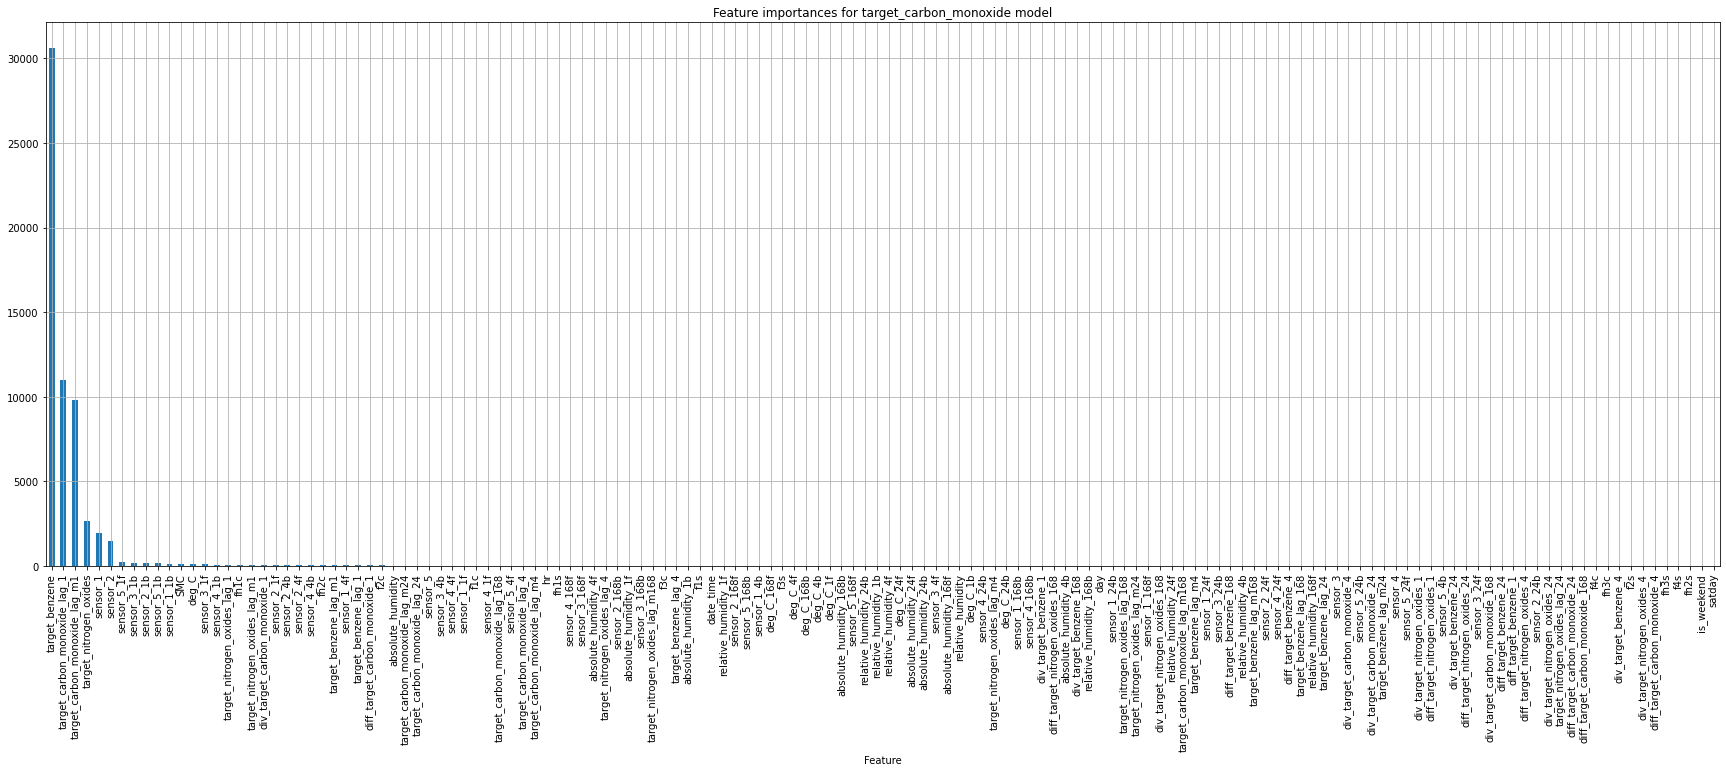

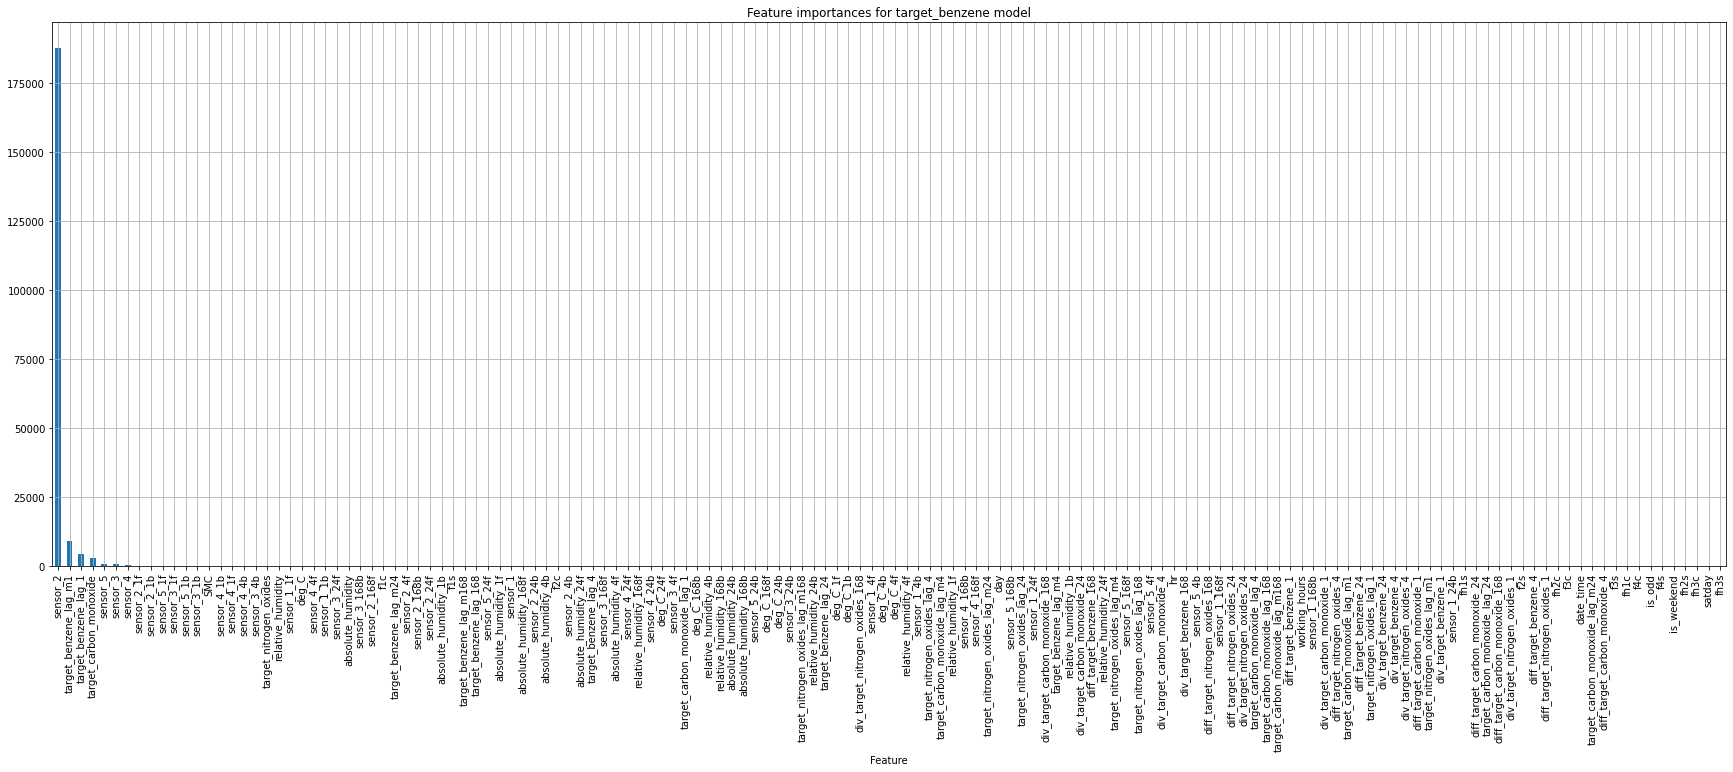

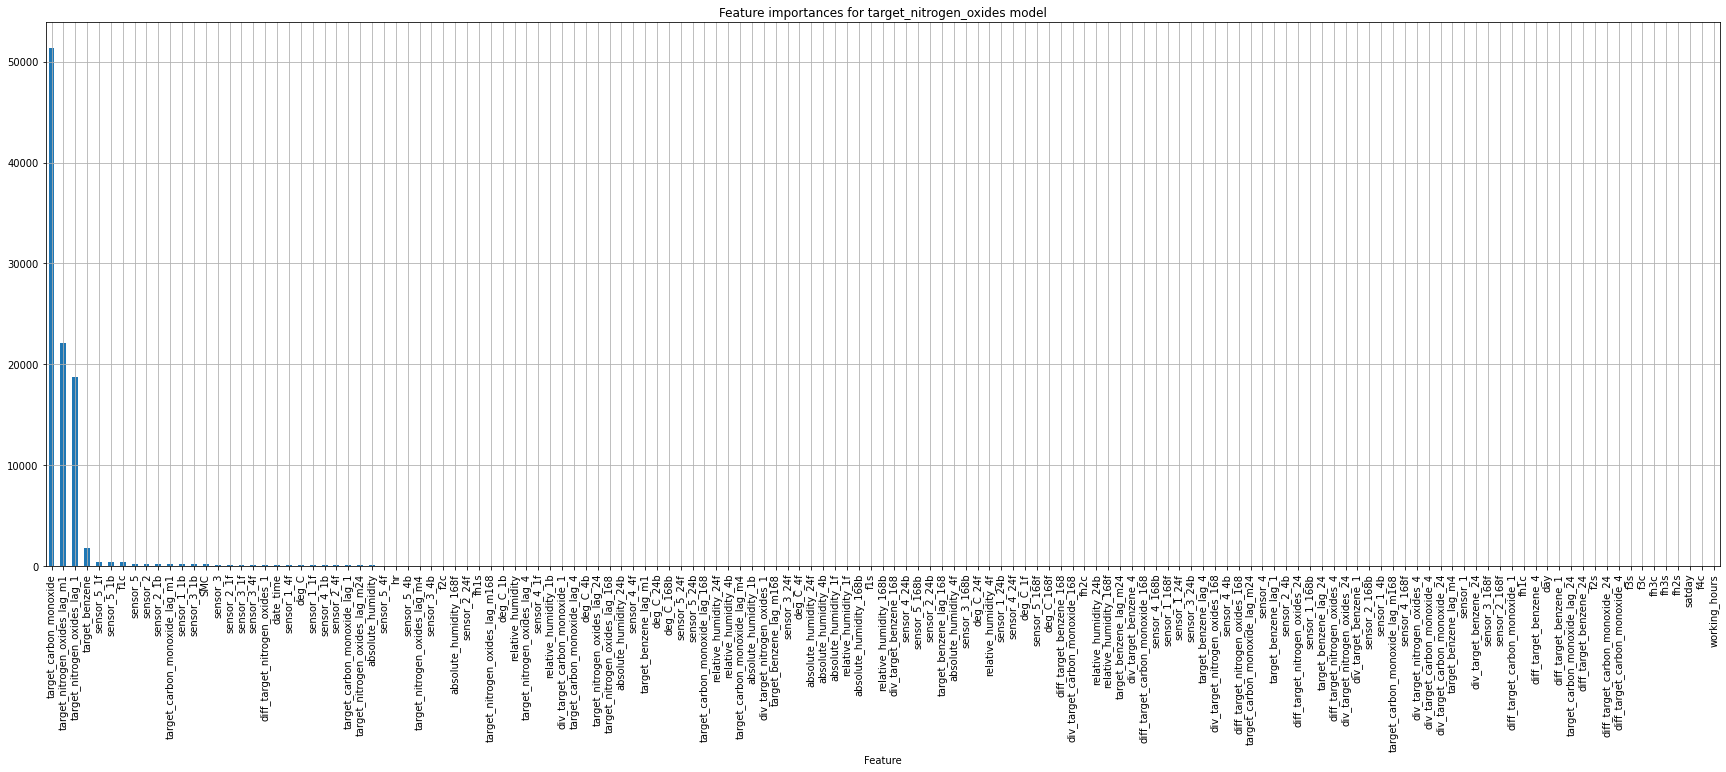

In [29]:
for targ in targets_and_drop:
    plt.figure(figsize = (30, 10))
    importances[targ].set_index('Feature')['Importance'].plot.bar()
    plt.title('Feature importances for {} model'.format(targ))
    plt.grid(True)
    plt.show()

# Step 4. Create submission file

In [30]:
sample_sub

,date_time,target_carbon_monoxide,target_benzene,target_nitrogen_oxides
0,2011-01-01 00:00:00,1.548732,4.724474,212.747604
1,2011-01-01 01:00:00,1.977099,8.149812,275.248169
2,2011-01-01 02:00:00,2.198140,7.494460,275.991913
3,2011-01-01 03:00:00,2.546735,7.818718,326.744995
4,2011-01-01 04:00:00,1.888648,5.842218,243.424393
...,...,...,...,...
2242,2011-04-04 10:00:00,3.168368,13.202240,479.155273
2243,2011-04-04 11:00:00,2.397324,10.998175,337.671021
2244,2011-04-04 12:00:00,2.484356,12.353018,308.412354
2245,2011-04-04 13:00:00,2.039073,10.113237,241.968628


In [31]:
pseudolabels_true[['target_carbon_monoxide','target_benzene','target_nitrogen_oxides']]

,target_carbon_monoxide,target_benzene,target_nitrogen_oxides
0,-200.0,4.247511,-200.0
1,1.6,8.763027,214.9
2,2.5,7.498693,299.8
3,2.7,7.563761,-200.0
4,1.9,5.560496,253.1
...,...,...,...
2242,3.1,13.529605,471.7
2243,2.4,11.355157,353.3
2244,2.4,12.374538,293.0
2245,2.1,9.547187,234.5


In [32]:
for targ in targets_and_drop:
    preds = sample_sub[targ].values
    real_values = pseudolabels_true[targ].values
    final_preds = np.where(real_values >= 0, real_values, preds)
    print(final_preds)
    sample_sub[targ] = final_preds

[1.54873157 1.6        2.5        ... 2.4        2.1        2.2       ]
[ 4.24751113  8.76302709  7.49869345 ... 12.3745384   9.54718667
 11.9320599 ]
[212.74760437 214.9        299.8        ... 293.         234.5
 265.2       ]


In [33]:
sample_sub.to_csv('lightautoml_with_pseudolabelling_kernel_version_15.csv', index = False)